# Context

This notebook continues from the separate [intro_eda](intro_eda.ipynb) notebook. Data scrubbing and exploration is done in that notebook.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sns
import joblib
import hashlib
import json
import pickle
import gzip
import re
from ml_tools import model_eval, nlp_prep, eda

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tag import StanfordPOSTagger

from wordcloud import WordCloud

import spacy

from sklearn import metrics
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, \
            cross_val_score, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [208]:
# Load in data that was previously dumped from intro_eda notebook
f = gzip.open('data/cleaned_data.pickle.gz','rb')
df = pickle.load(f)
f.close()

f = gzip.open('data/cleaned_article_data.pickle.gz','rb')
df_articles = pickle.load(f)
f.close()

# Model Facebook Posts Only

Initially, I used a target consisting of outliers, and gridsearched for the best hyperparameters using Multinomial Bayes and Logistic Regression without lemmatization. Logistic Regression slightly outperformed Multinomial Bayes.

I took the best params from the LR model using outlier-based target, and experimented with lemmas as well as modeling only text or only metadata. I then applied the best model so far (with lemmatization and text only) to the target using over 75th percentile and it performed better.

Performance didn't get much above 60% for the target class, so I decided to adjust the binary percentile target to use the mean percentile across all categories instead of the max. I also decided to create a multi-class target to see how that performed.

Generally, the best parameters for Logistic Regression were:
- using Tfidf normalization for the text 
- (1,2) ngrams
- 10,000 max features
- C = 0.1 (1.0 might get slightly better recall but is more overfit)
- saga solver
- fit_intercept = False

Text vectorization tended to take quite a while with lemmatization, which made the gridsearching too time-consuming if I wanted to experiment with vectorization parameters such as different stopwords lists, using/not using Tfidf normalization, using/not using lemmatization, and using different numbers of max features. Ultimately, since the best parameters for both the full set of Facebook posts and the text of the matched articles were the same, I decided to apply those up front. I  considered these my baseline models.

I then ran gridsearching using the text vectorization parameters with the model parameters held constant. I compared the results of the best gridsearch params to the baseline models. Ultimately, I wasn't able to find better parameters, so the original models were kept as the best performing.

In [3]:
df.columns

Index(['id', 'name', 'message', 'description', 'caption', 'post_type',
       'status_type', 'comments_count', 'shares_count', 'link', 'posted_at',
       'print_section', 'print_page', 'snippet', 'lead_paragraph',
       'main_headline', 'news_desk', 'section_name', 'type_of_material',
       'word_count', 'glocations', 'subject', 'persons', 'organizations',
       'creative_works', 'is_matched', 'all_text', 'likes_loves',
       'shares_outliers', 'comments_outliers', 'likelove_outliers',
       'comments_pct', 'shares_pct', 'likesloves_pct', 'max_pct', 'mean_pct',
       'all_binary', 'all_multi', 'comments_pct_m', 'shares_pct_m',
       'likesloves_pct_m', 'max_pct_m', 'mean_pct_m', 'm_binary', 'm_multi',
       'is_interactive', 'is_video', 'is_slideshow', 'word_count_cat',
       'has_person', 'has_org', 'has_geo', 'is_multimedia', 'day_name',
       'month', 'hour', 'year', 'hour_cat', 'on_weekend', 'text_hash',
       'cleaned', 'article_text'],
      dtype='object')

## Different stopwords and punc

I noticed that many of the posts I couldn't match to articles included questions to readers, and asked them to give their opinion in comments. I'm going to remove the question mark and the you/your permutations from the stopwords list to see whether keeping these in affect model performance.

In [4]:
nltk_stopwords = stopwords.words('english')
nltk_stopwords.sort()

import string
punc = list(string.punctuation)

you_list = ['you', "you'd", "you'll", "you're", "you've", 'your', 'yours',
            'yourself', 'yourselves']
custom_stopwords = [word for word in nltk_stopwords if word not in you_list]

custom_punc = punc.copy()
custom_punc.remove('?')

## Preprocessing

In [5]:
# constants for column names involved
text_col = 'cleaned'
cat_cols = ['post_type', 'hour_cat', 'on_weekend']

In [6]:
# initial X and y set for all posts
X = df[[text_col] + cat_cols]
y = df['all_binary']

In [7]:
# 0 is low, 1 is high engagement
class_labels = ['Low', 'High']

# 0 is low, 1 is moderate, 2 is high
mclass_labels = ['Low', 'Moderate', 'High']

In [8]:
# train test split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, 
                                            test_size=0.2, stratify=y)
print(len(X_train_all))
print(len(y_train_all))
print(len(X_test_all))
print(len(y_test_all))

38292
38292
9574
9574


I will want to be able to use the same train-test split for binary as I do for multi-class, so they will be directly comparable.

Thankfully, the indexes in the split dfs stay the same as the original df, so I should be able to generate the same y_train and y_test splits using the multi-class target.

In [9]:
# Create multi-class y_train using the same indices as binary
y_train_all_multi = df[df.index.isin(y_train_all.index)]['all_multi']
y_train_all_multi = y_train_all_multi.reindex(index=list(y_train_all.index))

# Create multi-class y_test using the same indices as binary
y_test_all_multi = df[df.index.isin(y_test_all.index)]['all_multi']
y_test_all_multi = y_test_all_multi.reindex(index=list(y_test_all.index))

In [10]:
print(y_train_all_multi.isna().sum())
y_test_all_multi.isna().sum()

0


0

### Which categories will be dropped as first?

In [11]:
print(X['post_type'].unique())

['link' 'photo' 'other' 'video']


The first will be `link`, which most of the posts.

In [12]:
print(X['hour_cat'].unique())

['3_Midday (11-15)' '4_Afternoon (15-19)' '5_Evening (19-23)'
 '2_Morning (7-11)' '6_Late night (23-3)' '1_Early morning (3-7)']


The first will be Early Morning, which is rare.

## Transform X up front

To save time gridsearching and evaluating models based on model hyperparameters only.

In [13]:
# Transform text and cat cols ahead of time to save time when gridsearching
# further
txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=nlp_prep.tokenize_lemma,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=10000)),
    ('tfidf', TfidfTransformer())
])

# NOTE: The text transformers expect a single column, in a 1-D array.
# If you pass a list of strings as column names for the text transformer,
# it will crap out because it will receive a 2D array...
all_cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt', txt_trans_pipe, text_col)
])

X_train_all_t = all_cols_trans.fit_transform(X_train_all)
X_test_all_t = all_cols_trans.transform(X_test_all)

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [153]:
X_train_all_t.shape

(38292, 10009)

In [14]:
# Path I'm going to use to save best estimators from gridsearching
save_path = "models/"

In [15]:
rerun_grid = False

## Baseline Dummy Classifiers

### Binary

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79     30067
         1.0       0.22      0.22      0.22      8225

    accuracy                           0.66     38292
   macro avg       0.50      0.50      0.50     38292
weighted avg       0.66      0.66      0.66     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78      7517
         1.0       0.22      0.23      0.22      2057

    accuracy                           0.66      9574
   macro avg       0.50      0.50      0.50      9574
weighted avg       0.66      0.66      0.66      9574


****************************** Training Scores ******************************
                  Training F1 = [0.7856 0.2205]
              Training Recall = [0.7846 0.2215]
            Training A

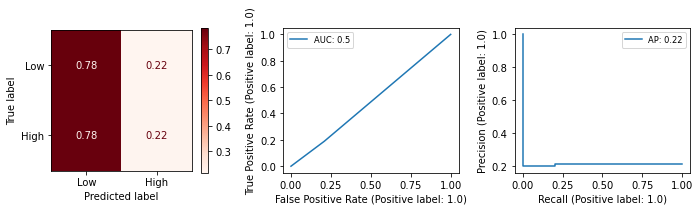

In [16]:
# Let's make a baseline classifier using the dummy model
dummy_clf = DummyClassifier(strategy='stratified')

dummy_clf.fit(X_train_all_t, y_train_all)

model_eval.eval_clf_model(dummy_clf, X_test_all_t, y_test_all, X_train_all_t, 
            y_train_all, labels=class_labels, score='std')

### Multi-class

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.22      0.22      0.22      8177
         1.0       0.57      0.57      0.57     21890
         2.0       0.21      0.22      0.21      8225

    accuracy                           0.42     38292
   macro avg       0.33      0.33      0.33     38292
weighted avg       0.42      0.42      0.42     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.21      0.22      0.21      2037
         1.0       0.57      0.56      0.56      5480
         2.0       0.21      0.21      0.21      2057

    accuracy                           0.41      9574
   macro avg       0.33      0.33      0.33      9574
weighted avg       0.42      0.41      0.41      9574


****************************** Training Scores ******************************
          

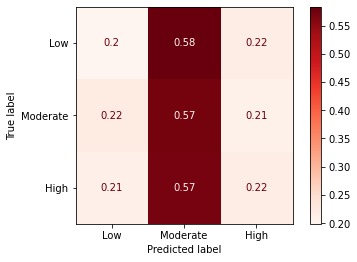

In [17]:
dummy_clf.fit(X_train_all_t, y_train_all_multi)

model_eval.eval_clf_model(dummy_clf, X_test_all_t, y_test_all_multi, 
        X_train_all_t, y_train_all_multi, labels=mclass_labels, score='std')

## Multinomial Bayes

### Baseline Binary

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


0.5907598784194528
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.91      0.74      0.81     30067
         1.0       0.43      0.72      0.54      8225

    accuracy                           0.73     38292
   macro avg       0.67      0.73      0.68     38292
weighted avg       0.80      0.73      0.75     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.86      0.72      0.78      7517
         1.0       0.36      0.58      0.44      2057

    accuracy                           0.69      9574
   macro avg       0.61      0.65      0.61      9574
weighted avg       0.75      0.69      0.71      9574


****************************** Training Scores ******************************
                  Training F1 = [0.8127 0.5386]
              Training Recall = [0.7361 0.7241]
   

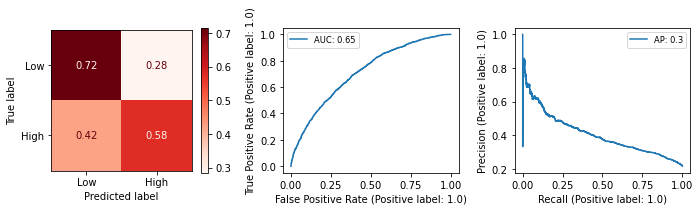

In [18]:
clf_mnb = MultinomialNB(fit_prior=False, alpha=0.5)

cv_scores = cross_val_score(clf_mnb, X_train_all_t, y_train_all, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

clf_mnb.fit(X_train_all_t, y_train_all)

model_eval.eval_clf_model(clf_mnb, X_test_all_t, y_test_all, X_train_all_t, 
            y_train_all, labels=class_labels, score='std')

### Baseline Multi-class

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


0.5031368857262668
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.50      0.66      0.57      8177
         1.0       0.76      0.54      0.63     21890
         2.0       0.46      0.67      0.55      8225

    accuracy                           0.59     38292
   macro avg       0.57      0.62      0.58     38292
weighted avg       0.64      0.59      0.60     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.40      0.55      0.46      2037
         1.0       0.64      0.46      0.53      5480
         2.0       0.37      0.51      0.43      2057

    accuracy                           0.49      9574
   macro avg       0.47      0.51      0.48      9574
weighted avg       0.53      0.49      0.50      9574


****************************** Training Scores **********************

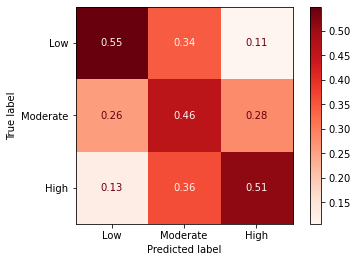

In [19]:
clf_mnb_multi = MultinomialNB(fit_prior=False, alpha=0.5)

cv_scores = cross_val_score(clf_mnb_multi, X_train_all_t, y_train_all_multi, 
            n_jobs=-1, scoring='recall_macro', verbose=1, error_score='raise')
print(np.mean(cv_scores))

clf_mnb_multi.fit(X_train_all_t, y_train_all_multi)

model_eval.eval_clf_model(clf_mnb_multi, X_test_all_t, y_test_all_multi,  
        X_train_all_t, y_train_all_multi, labels=mclass_labels, score='std')

## Logistic Regression

### Baseline Binary

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


0.6103343465045593
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.79     30067
         1.0       0.40      0.70      0.51      8225

    accuracy                           0.71     38292
   macro avg       0.65      0.70      0.65     38292
weighted avg       0.79      0.71      0.73     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.86      0.69      0.77      7517
         1.0       0.35      0.60      0.44      2057

    accuracy                           0.67      9574
   macro avg       0.61      0.65      0.60      9574
weighted avg       0.75      0.67      0.70      9574


****************************** Training Scores ******************************
                  Training F1 = [0.7908 0.5063]
              Training Recall = [0.7075 0.7015]
   

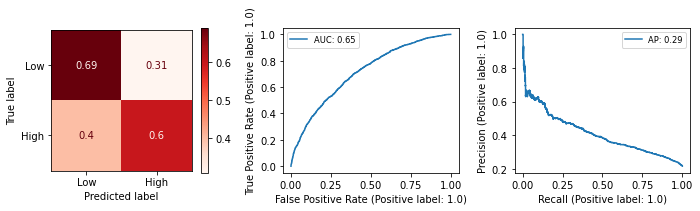

In [20]:
clf_lr = LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1)

cv_scores = cross_val_score(clf_lr, X_train_all_t, y_train_all, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

clf_lr.fit(X_train_all_t, y_train_all)

model_eval.eval_clf_model(clf_lr, X_test_all_t, y_test_all, X_train_all_t, 
            y_train_all, labels=class_labels, score='std')

### Gridsearch for Binary - no lemmas

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.

[('cols_trans', ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop='first'),
                                 ['post_type', 'hour_cat', 'on_weekend']),
                                ('txt',
                                 Pipeline(steps=[('vect',
                                                  CountVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['a',
                                                                              'about',
                                                                              'above',
                                                                              'after',
                                                                              'again',
                                                            

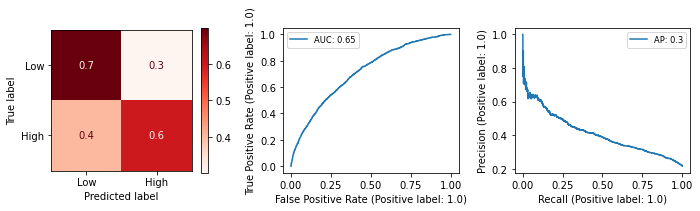

In [21]:
# Gridsearch was run in colab notebook, where I searched vectorization 
# parameters with no lemmatization. This just loads the best estimator.
# using the non-transformed X's since the gridsearch will do the transformation

gsfile_name = 'GSObject_LR_all_binary.joblib.gz'

best_LR_all_binary_pipe, best_LR_all_binary_gs = model_eval.\
        load_rebuild_eval_bestpipe(gsfile_name, X_train_all, y_train_all, 
        X_test_all, y_test_all, class_labels, load_path=save_path)

In [22]:
# what is the version of stopwords used?
best_LR_all_binary_pipe.named_steps['cols_trans'].named_transformers_['txt']\
    .named_steps['vect'].get_stop_words()


frozenset({'!',
           '"',
           '#',
           '$',
           '%',
           '&',
           "'",
           '(',
           ')',
           '*',
           '+',
           ',',
           '-',
           '.',
           '/',
           ':',
           ';',
           '<',
           '=',
           '>',
           '@',
           '[',
           '\\',
           ']',
           '^',
           '_',
           '`',
           'a',
           'about',
           'above',
           'after',
           'again',
           'against',
           'ain',
           'all',
           'am',
           'an',
           'and',
           'any',
           'are',
           'aren',
           "aren't",
           'as',
           'at',
           'be',
           'because',
           'been',
           'before',
           'being',
           'below',
           'between',
           'both',
           'but',
           'by',
           'can',
           'couldn',
           "could

The custom stopwords list (not including `?` or permutations of `your` was best, and lemmatization didn't add to performance.

The best binary classifier was ultimately using the same params I initially identified by experimenting with model params.

### Max Features 2000
### *** Best All Binary ***

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


0.6151975683890577
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.88      0.68      0.77     30067
         1.0       0.37      0.67      0.48      8225

    accuracy                           0.68     38292
   macro avg       0.63      0.68      0.62     38292
weighted avg       0.77      0.68      0.71     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.87      0.68      0.76      7517
         1.0       0.34      0.62      0.44      2057

    accuracy                           0.67      9574
   macro avg       0.61      0.65      0.60      9574
weighted avg       0.75      0.67      0.69      9574


****************************** Training Scores ******************************
                  Training F1 = [0.7717 0.4764]
              Training Recall = [0.6843 0.6734]
   

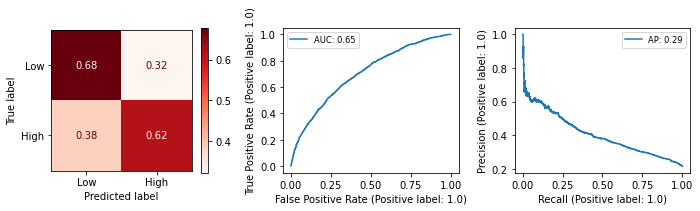

In [23]:
# Gridsearch of max features in my colab notebook showed that 2000 could 
# actually be better. Is it better compared to 10k on the same training split?

# set max_features to 2000, all othe params kept constant
best_LR_all_binary_pipe.set_params(**{'cols_trans__txt__vect__max_features': 2000})

# get cross-validated recall score using non-transformed data
cv_scores = cross_val_score(best_LR_all_binary_pipe, X_train_all, 
                            y_train_all, n_jobs=-1, scoring='recall', verbose=1)
print(np.mean(cv_scores))

# refit
best_LR_all_binary_pipe.fit(X_train_all, y_train_all)

model_eval.eval_clf_model(best_LR_all_binary_pipe, X_test_all, y_test_all, 
                          X_train_all, y_train_all, labels=class_labels, 
                          score='std')

### Baseline Multi-class

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


0.5114514834923659
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.45      0.70      0.55      8177
         1.0       0.76      0.43      0.55     21890
         2.0       0.43      0.69      0.53      8225

    accuracy                           0.54     38292
   macro avg       0.55      0.61      0.54     38292
weighted avg       0.63      0.54      0.55     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.39      0.62      0.48      2037
         1.0       0.65      0.36      0.46      5480
         2.0       0.36      0.57      0.44      2057

    accuracy                           0.46      9574
   macro avg       0.47      0.52      0.46      9574
weighted avg       0.53      0.46      0.46      9574


****************************** Training Scores **********************

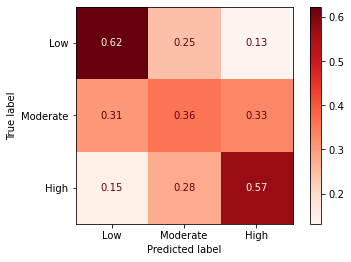

In [24]:
clf_lr = LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1)

cv_scores = cross_val_score(clf_lr, X_train_all_t, y_train_all_multi, n_jobs=-1, 
                            scoring='recall_macro', verbose=1)
print(np.mean(cv_scores))

clf_lr.fit(X_train_all_t, y_train_all_multi)

model_eval.eval_clf_model(clf_lr, X_test_all_t, y_test_all_multi, X_train_all_t, 
            y_train_all_multi, labels=mclass_labels, score='std')

### Gridsearch for Multi-class - no lemmas
### *** Best All Multi ***

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.

[('cols_trans', ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop='first'),
                                 ['post_type', 'hour_cat', 'on_weekend']),
                                ('txt',
                                 Pipeline(steps=[('vect',
                                                  CountVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['a',
                                                                              'about',
                                                                              'above',
                                                                              'after',
                                                                              'again',
                                                            

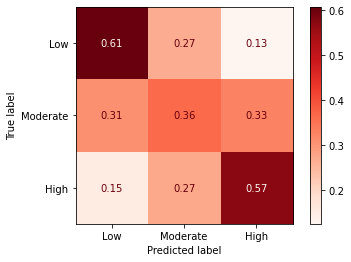

In [25]:
gsfile_name = 'GSObject_LR_all_multi.joblib.gz'

best_LR_all_multi_pipe, best_LR_all_multi_gs = model_eval.\
        load_rebuild_eval_bestpipe(gsfile_name, X_train_all, y_train_all_multi, 
        X_test_all, y_test_all_multi, mclass_labels, load_path=save_path)

In [26]:
# what is the version of stopwords used?
best_LR_all_multi_pipe.named_steps['cols_trans'].named_transformers_['txt']\
    .named_steps['vect'].get_stop_words()

frozenset({'!',
           '"',
           '#',
           '$',
           '%',
           '&',
           "'",
           '(',
           ')',
           '*',
           '+',
           ',',
           '-',
           '.',
           '/',
           ':',
           ';',
           '<',
           '=',
           '>',
           '@',
           '[',
           '\\',
           ']',
           '^',
           '_',
           '`',
           'a',
           'about',
           'above',
           'after',
           'again',
           'against',
           'ain',
           'all',
           'am',
           'an',
           'and',
           'any',
           'are',
           'aren',
           "aren't",
           'as',
           'at',
           'be',
           'because',
           'been',
           'before',
           'being',
           'below',
           'between',
           'both',
           'but',
           'by',
           'can',
           'couldn',
           "could

Custom stopwords again.

### LR results

The best binary LR identifies about 62% of high engagement posts correctly, and about 66% of low engagement posts correctly. As a reminder, for binary target, `high` defines posts with mean percentiles across all three engagement metrics greater than 75.

- Stopwords list that does not include permutations of `your` or `?` performs better than NLTK according to gridsearch optimized for recall.
- TF-IDF transformation does better than regular count or binary
- N-grams (1,2) are still better than (1,1), and max features 2k are best after searching several options
- There is a slight performance difference between lemmatizing versus not, but not very much. Using regular Tweet Tokenizer is slightly better, and is also easier to interpret.

The best multi-class LR finds about ~60% of Low and High engagement posts correctly, but only about 37% of Moderate. For the multi-class target, High engagement is defined the same way as binary, but Low is defined as mean percentile under 25%, and Moderate is mean percentile between 25% and 75%.

In multi-class, posts are mis-classified fairly evenly. Both High and Low are mis-classified as Moderate most frequently (about 30%) but are confused for each other only about 14%.

- As with binary, the best params are custom stopwords TF-IDF text vectorization normalization, (1,2) n-grams. 
- Multi-class did better with a slightly higher, 10k feature limit.
- Regular tweet-tokenizer actually did slightly better than using lemmatization in this case, although not by much.


# Model Matched Articles

## Preprocessing

In [27]:
cat_cols = ['section_name', 'word_count_cat', 'is_multimedia', 'has_person', 
            'has_org', 'has_geo']

Xmat = df_articles[['cleaned', 'subject'] + cat_cols]
ymat = df_articles['m_binary']

In [28]:
# train test split
X_train_mat, X_test_mat, y_train_mat, y_test_mat = train_test_split(Xmat, ymat, 
                                    test_size=0.2, stratify=ymat)
print(len(X_train_mat))
print(len(y_train_mat))
print(len(X_test_mat))
print(len(y_test_mat))

34581
34581
8646
8646


I will want to be able to use the same train-test split for binary as I do for multi-class, so they will be directly comparable.

Thankfully, the indexes in the split dfs stay the same as the original df, so I should be able to generate the same y_train and y_test splits using the multi-class target.

In [29]:
# Create multi-class y_train using the same indices as binary
y_train_mat_multi = df_articles[df_articles.index.isin(y_train_mat.index)]['m_multi']
y_train_mat_multi = y_train_mat_multi.reindex(index=list(y_train_mat.index))

# Create multi-class y_test using the same indices as binary
y_test_mat_multi = df_articles[df_articles.index.isin(y_test_mat.index)]['m_multi']
y_test_mat_multi = y_test_mat_multi.reindex(index=list(y_test_mat.index))

In [30]:
print(y_train_mat.value_counts())
print(y_train_mat_multi.value_counts())

0.0    27140
1.0     7441
Name: m_binary, dtype: int64
1.0    19781
2.0     7441
0.0     7359
Name: m_multi, dtype: int64


In [31]:
print(y_test_mat.value_counts())
print(y_test_mat_multi.value_counts())

0.0    6786
1.0    1860
Name: m_binary, dtype: int64
1.0    4950
2.0    1860
0.0    1836
Name: m_multi, dtype: int64


## Transform X up front

To save time gridsearching and evaluating models based on model hyperparameters only.

In [32]:
# Transform text and cat cols ahead of time to save time when gridsearching
# further
txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=nlp_prep.tokenize_lemma,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=10000)),
    ('tfidf', TfidfTransformer())
])

def no_analyzer(doc):
    """Pass-through function to avoid transforming tokens lists.
    """
    return doc

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
m_cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe, 'cleaned')
])

X_train_mat_t = m_cols_trans.fit_transform(X_train_mat)
X_test_mat_t = m_cols_trans.transform(X_test_mat)

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


When gridsearching different text vectorization options, using lemmas versus using a basic TweetTokenizer was the only param that was selected differently. Going to transform using TweetTokenizer and try both ways, with all other params held constant, to compare.

In [33]:
# No lemmatization
tweettokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

txt_trans_pipe2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=10000)),
    ('tfidf', TfidfTransformer())
])

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
m_cols_trans2 = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe2, 'cleaned')
])

X_train_mat_t2 = m_cols_trans2.fit_transform(X_train_mat)
X_test_mat_t2 = m_cols_trans2.transform(X_test_mat)

## Baseline Dummy Classifier

### Binary

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78     27140
         1.0       0.21      0.22      0.22      7441

    accuracy                           0.66     34581
   macro avg       0.50      0.50      0.50     34581
weighted avg       0.66      0.66      0.66     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78      6786
         1.0       0.20      0.19      0.20      1860

    accuracy                           0.66      8646
   macro avg       0.49      0.49      0.49      8646
weighted avg       0.66      0.66      0.66      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7821 0.2163]
              Training Recall = [0.7798 0.2187]
            Training A

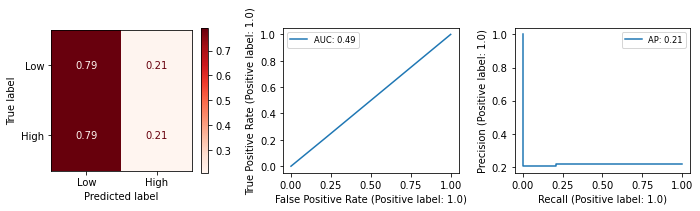

In [34]:
# Let's make a baseline classifier using the dummy model
dummy_clf = DummyClassifier(strategy='stratified')

dummy_clf.fit(X_train_mat_t, y_train_mat)

model_eval.eval_clf_model(dummy_clf, X_test_mat_t, y_test_mat, X_train_mat_t, 
            y_train_mat, labels=class_labels, score='std')

### Multi-class

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.22      0.22      0.22      7359
         1.0       0.58      0.58      0.58     19781
         2.0       0.21      0.21      0.21      7441

    accuracy                           0.42     34581
   macro avg       0.34      0.34      0.34     34581
weighted avg       0.42      0.42      0.42     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.20      0.19      0.20      1836
         1.0       0.56      0.56      0.56      4950
         2.0       0.21      0.21      0.21      1860

    accuracy                           0.41      8646
   macro avg       0.32      0.32      0.32      8646
weighted avg       0.41      0.41      0.41      8646


****************************** Training Scores ******************************
          

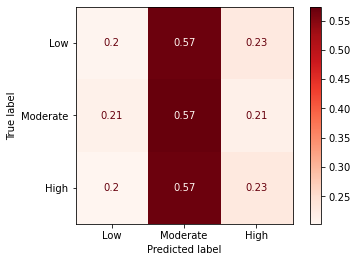

In [35]:
dummy_clf.fit(X_train_mat_t, y_train_mat_multi)

model_eval.eval_clf_model(dummy_clf, X_test_mat_t, y_test_mat_multi,  
        X_train_mat_t, y_train_mat_multi, labels=mclass_labels, score='std')

## Multinomial Bayes

### Baseline Binary

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


0.6113418654361373
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.78     27140
         1.0       0.39      0.72      0.51      7441

    accuracy                           0.70     34581
   macro avg       0.65      0.71      0.65     34581
weighted avg       0.79      0.70      0.72     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.87      0.68      0.76      6786
         1.0       0.35      0.62      0.45      1860

    accuracy                           0.67      8646
   macro avg       0.61      0.65      0.60      8646
weighted avg       0.76      0.67      0.69      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7843 0.5071]
              Training Recall = [0.6951 0.7175]
   

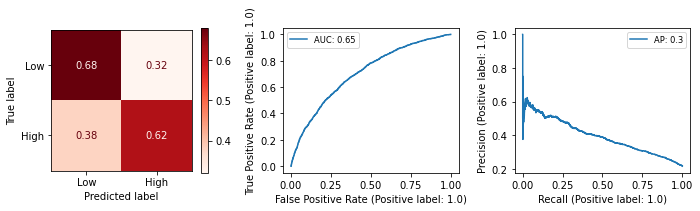

In [36]:
clf_mnb_m = MultinomialNB(fit_prior=False, alpha=0.5)

cv_scores = cross_val_score(clf_mnb_m, X_train_mat_t, y_train_mat, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

clf_mnb_m.fit(X_train_mat_t, y_train_mat)

model_eval.eval_clf_model(clf_mnb_m, X_test_mat_t, y_test_mat, X_train_mat_t, 
            y_train_mat, labels=class_labels, score='std')

### Binary - No lemmas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


0.6106701834961762
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78     27140
         1.0       0.39      0.72      0.51      7441

    accuracy                           0.70     34581
   macro avg       0.65      0.71      0.65     34581
weighted avg       0.79      0.70      0.72     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.87      0.67      0.76      6786
         1.0       0.34      0.62      0.44      1860

    accuracy                           0.66      8646
   macro avg       0.60      0.65      0.60      8646
weighted avg       0.75      0.66      0.69      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7833 0.5069]
              Training Recall = [0.6934 0.7193]
   

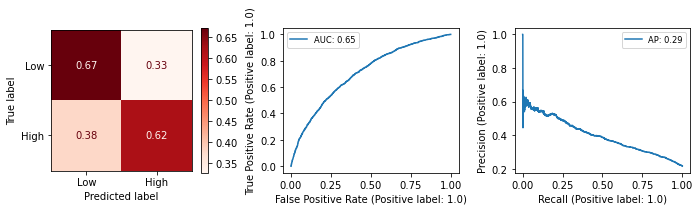

In [37]:
cv_scores = cross_val_score(clf_mnb_m, X_train_mat_t2, y_train_mat, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

clf_mnb_m.fit(X_train_mat_t2, y_train_mat)

model_eval.eval_clf_model(clf_mnb_m, X_test_mat_t2, y_test_mat, X_train_mat_t2, 
            y_train_mat, labels=class_labels, score='std')

### Baseline Multi-class

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


0.49427529958106736
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.44      0.68      0.53      7359
         1.0       0.75      0.43      0.55     19781
         2.0       0.42      0.66      0.51      7441

    accuracy                           0.53     34581
   macro avg       0.54      0.59      0.53     34581
weighted avg       0.61      0.53      0.54     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.37      0.57      0.45      1836
         1.0       0.64      0.38      0.48      4950
         2.0       0.36      0.57      0.44      1860

    accuracy                           0.46      8646
   macro avg       0.46      0.51      0.46      8646
weighted avg       0.53      0.46      0.47      8646


****************************** Training Scores *********************

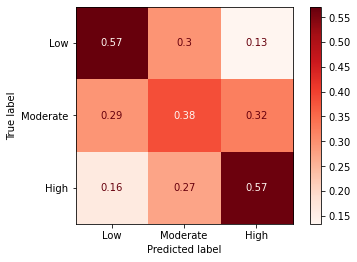

In [38]:
clf_mnb_m_multi = MultinomialNB(fit_prior=False, alpha=0.5)

clf_mnb_m_multi.fit(X_train_mat_t, y_train_mat_multi)

cv_scores = cross_val_score(clf_mnb_m_multi, X_train_mat_t, y_train_mat_multi, 
                            n_jobs=-1, scoring='recall_macro', verbose=1, )
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_mnb_m_multi, X_test_mat_t, y_test_mat_multi,  
            X_train_mat_t, y_train_mat_multi, labels=mclass_labels, score='std')

### Multi-class - No lemmas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


0.4938427150709586
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.44      0.68      0.54      7359
         1.0       0.75      0.43      0.54     19781
         2.0       0.42      0.67      0.51      7441

    accuracy                           0.53     34581
   macro avg       0.54      0.59      0.53     34581
weighted avg       0.61      0.53      0.54     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.37      0.57      0.45      1836
         1.0       0.64      0.38      0.48      4950
         2.0       0.36      0.56      0.44      1860

    accuracy                           0.46      8646
   macro avg       0.46      0.50      0.46      8646
weighted avg       0.52      0.46      0.46      8646


****************************** Training Scores **********************

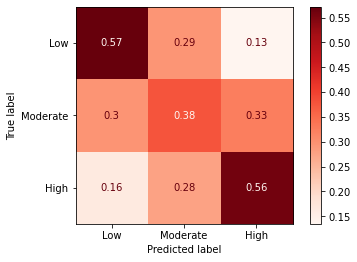

In [39]:
clf_mnb_m_multi.fit(X_train_mat_t2, y_train_mat_multi)

cv_scores = cross_val_score(clf_mnb_m_multi, X_train_mat_t2, y_train_mat_multi, 
                            n_jobs=-1, scoring='recall_macro', verbose=1, )
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_mnb_m_multi, X_test_mat_t2, y_test_mat_multi,  
            X_train_mat_t2, y_train_mat_multi, labels=mclass_labels, score='std')

## Logistic Regression

### Baseline Binary

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


0.5993807635925099
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.79     27140
         1.0       0.41      0.72      0.52      7441

    accuracy                           0.71     34581
   macro avg       0.65      0.72      0.66     34581
weighted avg       0.80      0.71      0.74     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.87      0.70      0.77      6786
         1.0       0.36      0.61      0.45      1860

    accuracy                           0.68      8646
   macro avg       0.61      0.66      0.61      8646
weighted avg       0.76      0.68      0.70      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7947 0.519 ]
              Training Recall = [0.7097 0.7214]
   

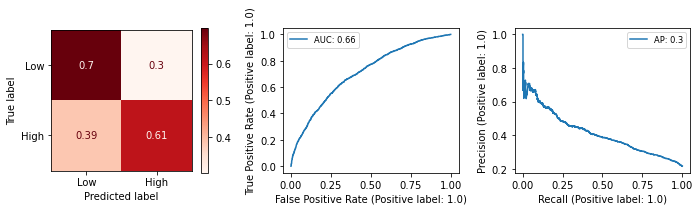

In [40]:
clf_lr_m = LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1)

clf_lr_m.fit(X_train_mat_t, y_train_mat)

cv_scores = cross_val_score(clf_lr_m, X_train_mat_t, y_train_mat, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_lr_m, X_test_mat_t, y_test_mat, X_train_mat_t, 
            y_train_mat, labels=class_labels, score='std')

### Binary - No lemmas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


0.5984397228420603
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.79     27140
         1.0       0.41      0.72      0.52      7441

    accuracy                           0.71     34581
   macro avg       0.65      0.72      0.66     34581
weighted avg       0.80      0.71      0.74     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.87      0.70      0.77      6786
         1.0       0.36      0.61      0.45      1860

    accuracy                           0.68      8646
   macro avg       0.61      0.65      0.61      8646
weighted avg       0.76      0.68      0.70      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7948 0.5185]
              Training Recall = [0.7102 0.7199]
   

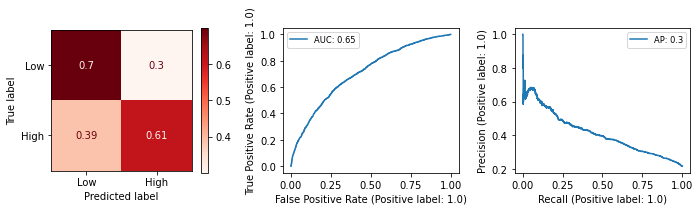

In [41]:
clf_lr_m.fit(X_train_mat_t2, y_train_mat)

cv_scores = cross_val_score(clf_lr_m, X_train_mat_t2, y_train_mat, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_lr_m, X_test_mat_t2, y_test_mat, X_train_mat_t2, 
            y_train_mat, labels=class_labels, score='std')

### Max Features 2000
### *** Best Matched Binary ***

Gridsearching on max features in my colab notebook, I determined that the best binary classifier for the matched posts used only 2000 features.

The best multi-class classifier still used 10,000 features, so that one I've left as-is.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


0.6015315720300123
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79     27140
         1.0       0.39      0.71      0.51      7441

    accuracy                           0.70     34581
   macro avg       0.65      0.70      0.65     34581
weighted avg       0.79      0.70      0.73     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77      6786
         1.0       0.35      0.61      0.45      1860

    accuracy                           0.67      8646
   macro avg       0.61      0.65      0.61      8646
weighted avg       0.76      0.67      0.70      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7879 0.5065]
              Training Recall = [0.7021 0.7077]
   

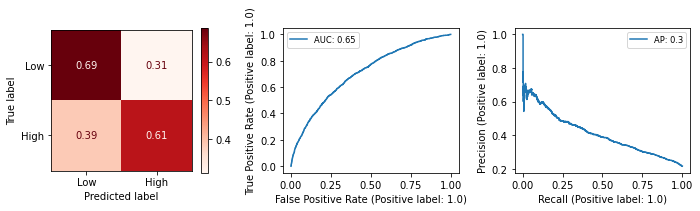

In [42]:
txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=2000)),
    ('tfidf', TfidfTransformer())
])

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
m_cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe, 'cleaned')
])

best_LR_mat_binary_pipe = Pipeline([
    ('cols_trans', m_cols_trans),
    ('clf', LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1))
])

cv_scores = cross_val_score(best_LR_mat_binary_pipe, X_train_mat, y_train_mat, 
                            n_jobs=-1, scoring='recall', verbose=1)
print(np.mean(cv_scores))

best_LR_mat_binary_pipe.fit(X_train_mat, y_train_mat)

model_eval.eval_clf_model(best_LR_mat_binary_pipe, X_test_mat, y_test_mat, 
            X_train_mat, y_train_mat, labels=class_labels, score='std')

### Baseline Multi-class

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


0.5003874250868758
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.44      0.72      0.55      7359
         1.0       0.78      0.43      0.55     19781
         2.0       0.44      0.69      0.54      7441

    accuracy                           0.55     34581
   macro avg       0.56      0.62      0.55     34581
weighted avg       0.64      0.55      0.55     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.37      0.61      0.46      1836
         1.0       0.65      0.37      0.47      4950
         2.0       0.37      0.56      0.45      1860

    accuracy                           0.46      8646
   macro avg       0.46      0.51      0.46      8646
weighted avg       0.53      0.46      0.46      8646


****************************** Training Scores **********************

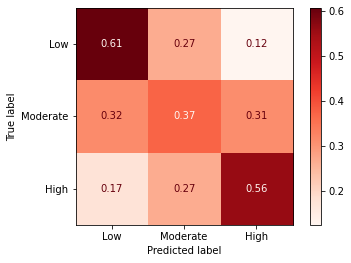

In [43]:
clf_lr_m_multi = LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1)

clf_lr_m_multi.fit(X_train_mat_t, y_train_mat_multi)

cv_scores = cross_val_score(clf_lr_m_multi, X_train_mat_t, y_train_mat_multi, 
                            n_jobs=-1, scoring='recall_macro', verbose=1)
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_lr_m_multi, X_test_mat_t, y_test_mat_multi,  
        X_train_mat_t, y_train_mat_multi, labels=mclass_labels, score='std')

### Multi-class - No lemmas
### *** Best Matched Multi ***

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


0.4998311856357368
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.45      0.73      0.55      7359
         1.0       0.78      0.43      0.56     19781
         2.0       0.44      0.70      0.54      7441

    accuracy                           0.55     34581
   macro avg       0.56      0.62      0.55     34581
weighted avg       0.64      0.55      0.55     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.37      0.61      0.46      1836
         1.0       0.65      0.37      0.47      4950
         2.0       0.37      0.55      0.44      1860

    accuracy                           0.46      8646
   macro avg       0.46      0.51      0.46      8646
weighted avg       0.53      0.46      0.46      8646


****************************** Training Scores **********************

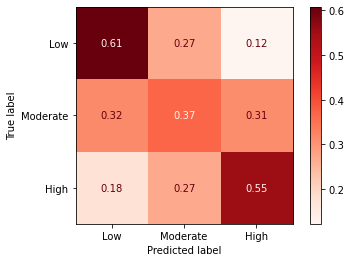

In [44]:
clf_lr_m_multi.fit(X_train_mat_t2, y_train_mat_multi)

cv_scores = cross_val_score(clf_lr_m_multi, X_train_mat_t2, y_train_mat_multi, 
                            n_jobs=-1, scoring='recall_macro', verbose=1)
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_lr_m_multi, X_test_mat_t2, y_test_mat_multi,  
        X_train_mat_t2, y_train_mat_multi, labels=mclass_labels, score='std')

### Build pipeline for best

In [45]:
best_LR_mat_multi_pipe = Pipeline([
    ('cols_trans', m_cols_trans),
    ('clf', LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1))
])

best_LR_mat_multi_pipe.fit(X_train_mat, y_train_mat_multi)

Pipeline(steps=[('cols_trans',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['section_name',
                                                   'word_count_cat',
                                                   'is_multimedia',
                                                   'has_person', 'has_org',
                                                   'has_geo']),
                                                 ('txt_kw',
                                                  CountVectorizer(analyzer=<function no_analyzer at 0x7ffa5f19ddc0>),
                                                  'subject'),
                                                 ('txt',
                                                  Pipeline(steps=[('vect',
                                                                   CountVectorizer(max_features=2000,
               

# iNTERPRET

## Best models overview

Binary classifiers performed slightly better on the `High engagement` target than multi-class. 

Binary classifiers were able to predict about 62% of high engagement posts correctly, and about 66% of low engagement posts correctly. There was little difference in performance between analyzing Facebook text and metadata versus text and metadata from the original NYT articles that I could match.

Multi-class classifiers for all posts using Facebook data were able to predict about 60% of high engagement, 60% of low engagement, and 37% of moderate engagement posts correctly. Classifiers on matched articles were slightly worse at predicting high and moderate engagement, but not by much.

Although the models are not highly accurate, they do all perform quite a bit better on the high/low classes than guessing based on class balance. Rather than pursue more complex models which may achieve better performance but will also be more prone to overfitting on this data and will also be more difficult to interpret, I'm going to use these and see what insights we can get that might be applicable to future data.

In some cases, Multinomial Bayes performed slightly better than Logistic Regression, but again the difference wasn't much. I'm going to use the Logistic Regression models since they are very easy to interpret.

I'm also going to use the versions without lemmatization, as it didn't seem to add much in performance, if anything.

In [46]:
# save out best pipes
joblib.dump(best_LR_all_binary_pipe, 
            f"{save_path}BestPipe_LR_all_binary.joblib.gz")

joblib.dump(best_LR_all_multi_pipe, 
            f"{save_path}BestPipe_LR_all_multi.joblib.gz")

joblib.dump(best_LR_mat_binary_pipe, 
            f"{save_path}BestPipe_LR_mat_binary.joblib.gz")

joblib.dump(best_LR_mat_multi_pipe, 
            f"{save_path}BestPipe_LR_mat_multi.joblib.gz")

['models/BestPipe_LR_mat_multi.joblib.gz']

## Best LR Binary Facebook model

In [47]:
# load it back in from file
best_all_binary_pipe = joblib.load(f"{save_path}BestPipe_LR_all_binary.joblib.gz")


In [158]:
from sklearn.model_selection import StratifiedShuffleSplit

In [159]:
# Interestingly, the train_test_split function is a wrapper around
# the ShuffleSplit() class

ss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=19)

# fit best model on entire dataset using cross-validation, so we can get
# cross-validated coefficients
binary_xval_results = cross_validate(best_all_binary_pipe, X, y, 
                                     return_estimator=True, cv=ss)

In [160]:
len(binary_xval_results['estimator'])

10

In [162]:
# did we get what we were looking for?
for pipe in binary_xval_results['estimator']:
    print(pipe.named_steps['clf'].coef_[0][:10])


[-0.33274269  0.40911579  0.59678447 -0.12598648 -0.07573755 -0.10798833
  0.28542964 -0.06134693  0.23271287 -0.04520403]
[-0.31999701  0.40584604  0.57961964 -0.09780225 -0.08073007 -0.12488777
  0.31624812 -0.06617937  0.21787048  0.05814685]
[-0.25883143  0.40033662  0.55935024 -0.08476021 -0.07640045 -0.11055334
  0.32554854 -0.04747412  0.22042784 -0.01071248]
[-0.27151303  0.43087155  0.58993738 -0.08980141 -0.08463182 -0.11280898
  0.31210397 -0.0581895   0.21883127  0.0025208 ]
[-0.31975783  0.42704194  0.57621475 -0.12001563 -0.08096562 -0.09413708
  0.31215788 -0.04930266  0.21302473  0.09048003]
[-0.28147596  0.40839696  0.55976847 -0.10416155 -0.06447051 -0.10681356
  0.30091626 -0.05441871  0.22083803  0.04454174]
[-0.28952488  0.43091658  0.5554795  -0.10330703 -0.06704865 -0.11401748
  0.31686937 -0.05541804  0.22394172 -0.03232907]
[-0.31034416  0.40363607  0.60072391 -0.09773004 -0.0753715  -0.12458257
  0.31151721 -0.06033861  0.22634724 -0.01533652]
[-0.2431133   0.

In [51]:
def get_all_data_features(pipe):
    """Get the feature names from specific pipeline used to transform the
    entire Facebook post dataset. Project-specific function.
    
    Returns (in this order):
    - full list of features names
    - OHE features
    - Bag of Words features
    - None (to match other workflows with more columns)
    """
    
    cat_cols = ['post_type', 'hour_cat', 'on_weekend']

    # get the feature names from OHE columns
    feature_names_ohe = list(pipe.named_steps['cols_trans']\
        .named_transformers_['ohe'].get_feature_names(cat_cols))

    # get the feature names from post bag of words
    feature_names_txt = pipe.named_steps['cols_trans']\
        .named_transformers_['txt'].named_steps['vect'].get_feature_names()

    # combine the feature lists
    feature_names = feature_names_ohe + feature_names_txt

    return feature_names, feature_names_ohe, feature_names_txt, None

In [52]:
def binary_target_oddsdf(pipe, clf, feature_func, class_label, class_int):
    """Generates a dataframe of features from a logistic regression model
    along with odds for that feature.
    
    Feed in a fitted model, list of feature names from get_feature_names() on
    the appropriate transformation step, and the label to use to represent
    the target class.
    
    Specify `class_int` of 0 to get odds of the 0 class, and 1 to get odds of
    the 1 class.
    """
    
    # get feature_names for each pipeline
    feature_names, _, _, _ = feature_func(pipe)
    
    # convert logit coefficients from log odds to odds ratios
    lr_odds = np.exp(clf.coef_[0])
    lr_odds_s = pd.Series(lr_odds, index=feature_names)
    
    # Create dataframe for odds greater than 1 (high engagement). 
    # Higher values represent greater odds of high engagement
    if class_int==1:
        df_odds = np.round(lr_odds_s.loc[lr_odds_s >= 1], 2).to_frame(
            name=class_label)
    elif class_int==0:
        df_odds = np.round(1/(lr_odds_s.loc[lr_odds_s < 1]), 2)\
            .to_frame(name=class_label)
    else:
        print("Error: `class_int` should be either 0 or 1.")
        return None
        
    df_odds.reset_index(inplace=True)
    df_odds.rename(columns={'index': 'Feature'}, inplace=True)
    
    # replace the 'sub_' prefix for keyword subjects. Specific to this project.
    df_odds['Formatted Feature'] = df_odds['Feature'].map(
        lambda x: x.replace("sub_", "").title() if x[:4]=="sub_" else x)

    # sort the dataframe by frequency
    df_odds.sort_values(by=class_label, ascending=False, inplace=True)
      
    return df_odds

In [175]:
def get_mean_coefs(xval_df, odds_label):
    """Get average odds ratios and confidence intervals for cross-validated
    scores.
    """

    # group results by formatted feature (word or subject or category name)
    grouped = xval_df.groupby(by=["Formatted Feature", "Feature"])
    eng = grouped[odds_label].describe()[['mean', 'std', 'min', 
                                                  'max', 'count']]

    # sort by mean odds, and make feature name a column instead of index
    eng.sort_values(by='mean', ascending=False, inplace=True)
    eng.reset_index(drop=False, inplace=True)

    # calculate standard error
    # se = sigma (std) / sqrt(n)
    eng['std_error'] = eng.apply(
                lambda x: x['std'] / np.sqrt(x['count']) , axis=1)

    # conf_min is going to be approximating the 95% confidence interval
    # by subtracting 2*SE rom the mean
    eng['conf_min'] = eng.apply(lambda x: x['mean'] - 2*(x['std_error']), 
                                          axis=1)

    # clean up column name
    eng.rename(columns={'mean': odds_label}, inplace=True)
    
    return eng

In [176]:
def plot_topfeatures_w_se(df, label_col, value_col, top_n, sub_title,
                            se, pos_neg=False):
    """Displays a horizontal bar plot of top n features, such as logistic 
    regression odds ratios. Suitable for scenarios where you have a set of
    text labels and values.
    
    Includes optional bars for confidence intervals.
    
    `df` should be a DataFrame where `word_col` is the column name containing 
    the word or ngram text, and `freq_col` is the column name containing the 
    frequency.
    """
    # reverse the order, since matplotlib annoyingly wants the data
    # listed smallest to largest  to plot it smallest at the bottom
    df = df.iloc[:top_n].sort_values(by=value_col).copy()
    
    if pos_neg:
        col_color = ['green' if c >= 0 else 'red' for c in df[value_col]]
    else:
        col_color='blue'
        
    
    # plot using matplotlib, since seaborn doesn't have a good way to do 
    # custom error bars
    fig, ax = plt.subplots(figsize=(8, len(df) / 2))
    
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='lightgray', linestyle='dashed')
    ax.xaxis.grid(color='lightgray', linestyle='dashed')
    
    ax.barh(y=df[label_col][-top_n:], width=df[value_col][-top_n:], 
           ecolor='black', xerr=np.array(df[se][-top_n:]), color=col_color)
    
    if pos_neg:
        ax.set_title(f"{sub_title}")
        ax.set_xlabel("Odds Ratio")
    else:
        ax.set_title(f"{value_col}\n{sub_title}")
        ax.set_xlabel(f"{value_col}")
    
    # https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(24)  
        
    for item in (ax.get_yticklabels() + ax.get_xticklabels()):
        item.set_fontsize(14)
    
    import matplotlib.ticker as mticker
    
    def format_odds(x, pos):
        if x < 0:
            x = str(np.round(np.abs(x) + 1, 2)) + "\nLow"
        elif x > 0:
            x = str(np.round(x + 1, 2)) + "\nHigh"
        elif x == 0:
            x = 'Even\nOdds'
        return x
        
    if pos_neg:
        # remove negatives from x tick labels
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_odds))

### High Engagement

In [177]:
high_label = 'Odds of High Engagement'

xval_high_dfs = []

# loop through each fitted estimator and get coefficients
for i, pipe in enumerate(binary_xval_results['estimator']):
    res_df = binary_target_oddsdf(pipe, pipe.named_steps['clf'], 
                                  get_all_data_features, 
                                  high_label, class_int=1)
    
    res_df['fit_num'] = i + 1
    
    xval_high_dfs.append(res_df)
    
# combine results from each fitted estimator into one dataframe
xval_high_df = pd.concat(xval_high_dfs)

xval_high_df['fit_num'].value_counts()

9     820
8     817
10    809
2     809
3     808
1     807
4     806
5     802
7     796
6     795
Name: fit_num, dtype: int64

In [178]:
high_eng = get_mean_coefs(xval_high_df, high_label)

In [179]:
xval_high_df.loc[xval_high_df['Formatted Feature'] == 'breaking news']

Feature  Odds of High Engagement Formatted Feature  fit_num
100  breaking news                     9.63     breaking news        1
102  breaking news                     9.92     breaking news        2
99   breaking news                     8.91     breaking news        3
97   breaking news                     9.28     breaking news        4
101  breaking news                     9.55     breaking news        5
96   breaking news                     9.46     breaking news        6
94   breaking news                     9.59     breaking news        7
100  breaking news                     9.72     breaking news        8
102  breaking news                     9.94     breaking news        9
97   breaking news                     9.10     breaking news       10

In [180]:
high_eng.head()

Formatted Feature         Feature  Odds of High Engagement       std   min  \
0     breaking news   breaking news                    9.510  0.333833  8.91   
1          breaking        breaking                    6.860  0.336221  6.21   
2    writes opinion  writes opinion                    3.771  0.188411  3.41   
3            recipe          recipe                    3.520  0.167664  3.26   
4      read opinion    read opinion                    3.314  0.130486  3.15   

    max  count  std_error  conf_min  
0  9.94   10.0   0.105567  9.298865  
1  7.36   10.0   0.106322  6.647355  
2  4.01   10.0   0.059581  3.651838  
3  3.85   10.0   0.053020  3.413960  
4  3.60   10.0   0.041263  3.231473

In [272]:
# high_eng[:300].to_csv('data/high_words.csv')

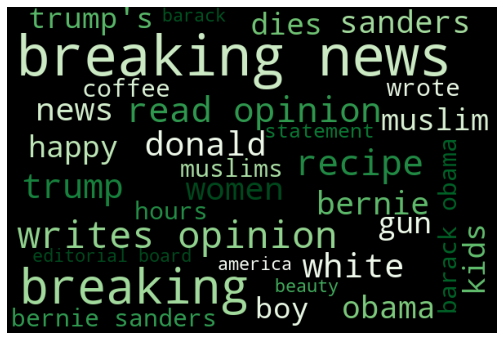

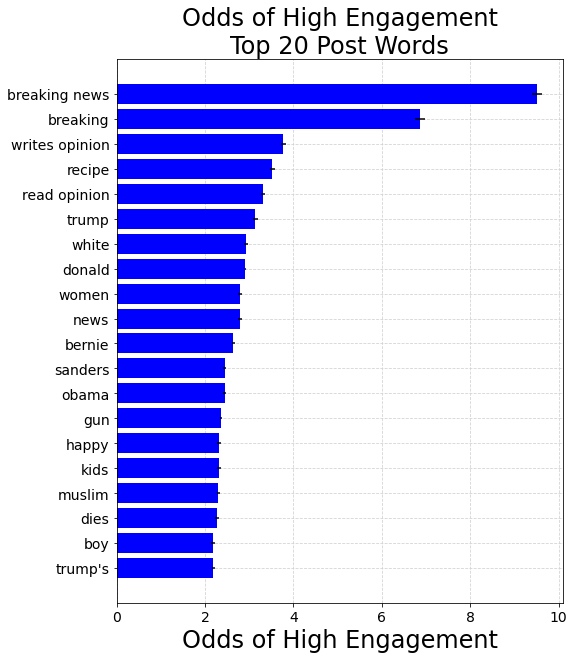

In [183]:
# Create visualizations for words with highest odds of high engagement
nlp_prep.generate_freqs_wordcloud(high_eng.loc[(high_eng['conf_min']>1) & 
                                                (high_eng['count']>1)], 
                        'Formatted Feature', high_label, 
                         cmap="Greens", min_font_size=16)

plot_topfeatures_w_se(high_eng.loc[(high_eng['conf_min']>1) & 
                                    (high_eng['count']>1)], 
                'Formatted Feature', high_label, 20, 
               f"Top 20 Post Words", 'std_error')

Of all the Facebook posts, the most common words associated with high engagement are:
- Names associated with the 2016 presidential race, such as Donald Trump, Hillary Clinton, Bernie Sanders, and Obama.
- The phrase `breaking news`
- `Recipe`, which I think mostly refers to recipes
- `writes opinion` and `opinion`, which probably refers to various opinion pieces
- The words `gun`, `women`, and `white`, which sound to me like they could represent the themes of gun violence, gender equality, and racial equality--all of which are hot topics.

### Categorical Features Only

In [184]:
_, all_ohe_feats, _, _ = get_all_data_features(best_all_binary_pipe)

high_eng.loc[high_eng["Feature"].isin(all_ohe_feats)]

Formatted Feature                     Feature  \
46              post_type_video             post_type_video   
105             post_type_photo             post_type_photo   
200  hour_cat_5_Evening (19-23)  hour_cat_5_Evening (19-23)   
322              on_weekend_1.0              on_weekend_1.0   

     Odds of High Engagement       std   min   max  count  std_error  conf_min  
46                     1.787  0.031990  1.74  1.83   10.0   0.010116  1.766768  
105                    1.512  0.021499  1.48  1.54   10.0   0.006799  1.498403  
200                    1.363  0.014181  1.33  1.38   10.0   0.004485  1.354031  
322                    1.250  0.009428  1.24  1.27   10.0   0.002981  1.244037

Being a video or photo Facebook post type both increase odds of high engagement compared to a link (which was the category dropped during OHE).

Posting in the evening (from 7 PM to 11 PM Eastern) or on the weekend also increased odds of high engagement somewhat. This may be because new posts would show up in users' feeds when they're online, so they would be seen right away as opposed to being buried under newer posts.

### Low Engagement

In [187]:
low_label = 'Odds of Low Engagement'

xval_low_dfs = []

# loop through each fitted estimator and get coefficients
for i, pipe in enumerate(binary_xval_results['estimator']):
    res_df = binary_target_oddsdf(pipe, pipe.named_steps['clf'], 
                                  get_all_data_features, 
                                  low_label, class_int=0)
    
    res_df['fit_num'] = i + 1
    
    xval_low_dfs.append(res_df)
    
# combine results from each fitted estimator into one dataframe
xval_low_df = pd.concat(xval_low_dfs)

# get average odds ratios and confidence intervals

low_eng = get_mean_coefs(xval_low_df, low_label)
low_eng[0:50]

Formatted Feature        Feature  Odds of Low Engagement       std   min  \
0              ebola          ebola                   3.326  0.200510  3.13   
1      quotation day  quotation day                   3.280  0.077028  3.09   
2          quotation      quotation                   3.147  0.084597  2.94   
3             sports         sports                   2.913  0.141974  2.77   
4               week           week                   2.692  0.108300  2.55   
5                  ?              ?                   2.681  0.163466  2.46   
6           ferguson       ferguson                   2.612  0.141798  2.47   
7          officials      officials                   2.538  0.118209  2.37   
8              watch          watch                   2.463  0.182577  2.25   
9          residents      residents                   2.379  0.134944  2.11   
10         political      political                   2.373  0.204616  2.14   
11             fight          fight                   2.350  0.174420  2.21   
12               new            new                   2.346  0.111475  2.15   
13             video          video                   2.292  0.091384  2.17   
14            search         search                   2.272  0.105704  2.14   
15        here's you     here's you                   2.198  0.072847  2.05   
16         need know      need know                   2.191  0.080753  2.06   
17         questions      questions                   2.190  0.092496  2.01   
18          military       military                   2.174  0.159527  1.94   
19            crisis         crisis                   2.127  0.119819  1.92   
20          politics       politics                   2.119  0.104078  1.95   
21            issues         issues                   2.114  0.125007  1.91   
22          football       football                   2.114  0.073364  2.00   
23        government     government                   2.102  0.110735  1.95   
24          pictures       pictures                   2.092  0.091748  1.95   
25        washington     washington                   2.085  0.127388  1.89   
26          security       security                   2.079  0.068710  1.98   
27              team           team                   2.074  0.113451  1.93   
28            market         market                   2.072  0.063210  1.98   
29           fashion        fashion                   2.064  0.079750  1.93   
30        basketball     basketball                   2.059  0.072334  1.97   
31            battle         battle                   2.040  0.052705  1.94   
32            island         island                   2.023  0.116433  1.84   
33              case           case                   2.018  0.114484  1.83   
34         companies      companies                   2.016  0.086178  1.86   
35             still          still                   2.011  0.180951  1.85   
36         elections      elections                   1.952  0.051164  1.87   
37            attack         attack                   1.950  0.114310  1.78   
38              look           look                   1.949  0.099939  1.83   
39         instagram      instagram                   1.934  0.075011  1.79   
40           ukraine        ukraine                   1.925  0.120023  1.75   
41             cases          cases                   1.899  0.078521  1.77   
42          economic       economic                   1.884  0.084748  1.77   
43           looking        looking                   1.879  0.066742  1.80   
44      fashion week   fashion week                   1.876  0.051683  1.78   
45             chief          chief                   1.876  0.093595  1.74   
46            follow         follow                   1.875  0.099023  1.75   
47            trying         trying                   1.870  0.120830  1.71   
48               day            day                   1.865  0.145392  1.66   
49          you need       you need                  

In [275]:
# low_eng[:300].to_csv('data/low_words.csv')

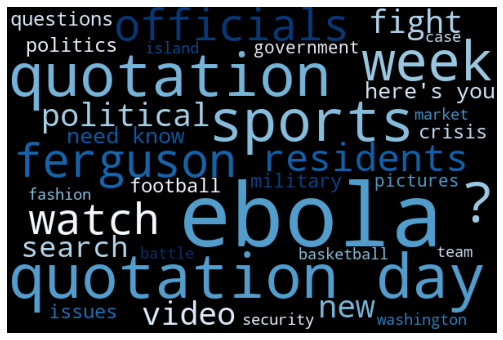

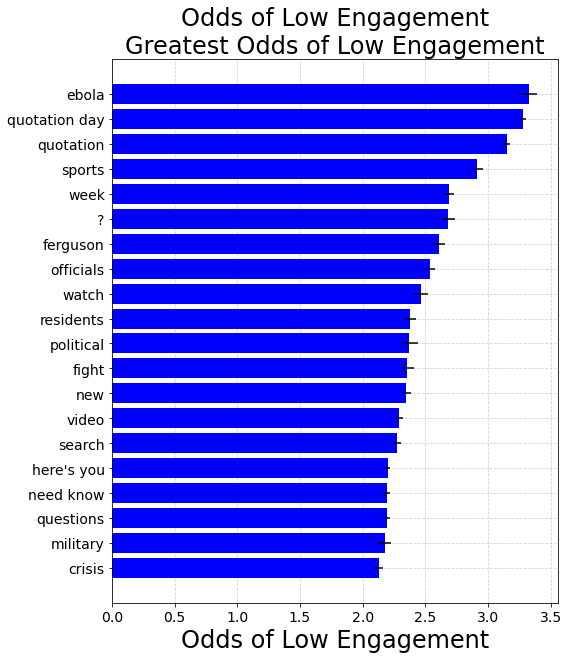

In [186]:
# Create visualizations for words with highest odds of low engagement
nlp_prep.generate_freqs_wordcloud(low_eng.loc[(low_eng['conf_min']>1) & 
                                              (low_eng['count']>1)], 
                        'Feature', low_label, 
                         cmap="Blues", min_font_size=16)

plot_topfeatures_w_se(low_eng.loc[(low_eng['conf_min']>1) & 
                                    (low_eng['count']>1)], 
                'Formatted Feature', low_label, 20, 
               f"Greatest {low_label}", 'std_error')

Words and phrases with the highest odds of low engagement are:
- `ebola`
- `quotation day`, which is probably `quotation of the day` in full
- `week`, which may be related to weekly recaps or overviews
- `politics`, `government`, `officials`, and `political`, which sound like terms related to general political happenings
- `sports` and `football`

### Categorical Features Only

In [188]:
low_eng.loc[low_eng["Feature"].isin(all_ohe_feats)]

Formatted Feature                       Feature  \
360                post_type_other               post_type_other   
889   hour_cat_4_Afternoon (15-19)  hour_cat_4_Afternoon (15-19)   
923      hour_cat_2_Morning (7-11)     hour_cat_2_Morning (7-11)   
1050     hour_cat_3_Midday (11-15)     hour_cat_3_Midday (11-15)   
1148  hour_cat_6_Late night (23-3)  hour_cat_6_Late night (23-3)   

      Odds of Low Engagement       std   min   max  count  std_error  conf_min  
360                    1.343  0.037431  1.28  1.39   10.0   0.011837  1.319326  
889                    1.118  0.010328  1.10  1.13   10.0   0.003266  1.111468  
923                    1.110  0.015635  1.09  1.13   10.0   0.004944  1.100112  
1050                   1.079  0.007379  1.07  1.09   10.0   0.002333  1.074333  
1148                   1.060  0.006667  1.05  1.07   10.0   0.002108  1.055784

The `Other` post type category consisted of status, event, and note. These have slightly higher odds of resulting in a post with low engagement.

Posting in the day between 7 AM and 7 PM (spans 3 categories), as well as from 11 PM to 3 AM, have slightly higher odds of low engagement compared to posting very late night (3 AM to 7 AM) which was the category dropped.

## Best LR Article Meta and Text model

In [189]:
# load it back in from file
best_mat_binary_pipe = joblib.load(f"{save_path}BestPipe_LR_mat_binary.joblib.gz")

In [191]:
binary_xval_art_results = cross_validate(best_mat_binary_pipe, Xmat, ymat, 
                                     return_estimator=True, cv=ss)

In [192]:
def get_matched_data_features(pipe):
    """Get the feature names from specific pipeline used to transform the
    matched article dataset.
    
    Returns (in order):
    - Full list of feature names
    - OHE features
    - Subject/Topic features
    - Bag of words features
    """
    cat_cols = ['section_name', 'word_count_cat', 'is_multimedia', 'has_person', 
                'has_org', 'has_geo']

    # get the feature names from OHE columns
    feature_names_ohe = list(pipe.named_steps['cols_trans']\
        .named_transformers_['ohe'].get_feature_names(cat_cols))

    # get the feature names from subject keywords
    feature_names_txt1 = pipe.named_steps['cols_trans']\
        .named_transformers_['txt_kw'].get_feature_names()

    # add "sub_" to beginning of each subject feature name so they can be told
    # apart from article text
    feature_names_txt1 = ['sub_' + kw for kw in feature_names_txt1]

    # get the feature names from bag of words
    feature_names_txt2 = pipe.named_steps['cols_trans']\
        .named_transformers_['txt'].named_steps['vect'].get_feature_names()

    # combine the feature lists
    feature_names = feature_names_ohe + feature_names_txt1 + feature_names_txt2

    return feature_names, feature_names_ohe, feature_names_txt1, \
        feature_names_txt2

### High Engagement

In [193]:
xval_high_art_dfs = []

# loop through each fitted estimator and get coefficients
for i, pipe in enumerate(binary_xval_art_results['estimator']):
    res_df = binary_target_oddsdf(pipe, pipe.named_steps['clf'], 
                                  get_matched_data_features, 
                                  high_label, class_int=1)
    
    res_df['fit_num'] = i + 1
    
    xval_high_art_dfs.append(res_df)
    
# combine results from each fitted estimator into one dataframe
xval_high_art_df = pd.concat(xval_high_art_dfs)

# get average odds ratios and confidence intervals

high_eng_art = get_mean_coefs(xval_high_art_df, high_label)
high_eng_art.head(20)

Formatted Feature                               Feature  \
0               section_name_Cooking                  section_name_Cooking   
1                              obama                                 obama   
2                               Cats                              sub_cats   
3                            sanders                               sanders   
4                             donald                                donald   
5       Archaeology And Anthropology      sub_archaeology and anthropology   
6      Presidential Election Of 2016     sub_presidential election of 2016   
7                           comments                              comments   
8                          president                             president   
9                             bernie                                bernie   
10                           world's                               world's   
11                         Happiness                         sub_happiness   
12                            letter                                letter   
13                              Hair                              sub_hair   
14                             trump                                 trump   
15                              said                                  said   
16      Vaccination And Immunization      sub_vaccination and immunization   
17                               boy                                   boy   
18  Chronic Traumatic Encephalopathy  sub_chronic traumatic encephalopathy   
19  Animal Abuse, Rights And Welfare  sub_animal abuse, rights and welfare   

    Odds of High Engagement       std   min   max  count  std_error  conf_min  
0                     3.140  0.148997  2.93  3.39   10.0   0.047117  3.045766  
1                     2.807  0.114606  2.62  2.95   10.0   0.036241  2.734517  
2                     2.288  0.113510  2.12  2.46   10.0   0.035895  2.216210  
3                     2.192  0.127436  1.99  2.37   10.0   0.040299  2.111402  
4                     2.140  0.094751  2.05  2.36   10.0   0.029963  2.080074  
5                     2.074  0.099577  1.94  2.22   10.0   0.031489  2.011022  
6                     2.067  0.038020  2.00  2.13   10.0   0.012023  2.042954  
7                     2.012  0.092592  1.87  2.19   10.0   0.029280  1.953439  
8                     1.984  0.116065  1.84  2.21   10.0   0.036703  1.910594  
9                     1.975  0.057783  1.90  2.07   10.0   0.018273  1.938455  
10                    1.967  0.163643  1.71  2.17   10.0   0.051748  1.863503  
11                    1.952  0.159638  1.73  2.19   10.0   0.050482  1.851036  
12                    1.932  0.128045  1.76  2.13   10.0   0.040491  1.851017  
13                    1.906  0.078768  1.78  2.01   10.0   0.024909  1.856183  
14                    1.900  0.092976  1.75  2.04   10.0   0.029401  1.841197  
15                    1.898  0.070836  1.84  2.08   10.0   0.022400  1.853199  
16                    1.883  0.123022  1.64  2.11   10.0   0.038903  1.805194  
17                    1.873  0.076311  1.73  1.99   10.0   0.024132  1.824737  
18                    1.867  0.125437  1.66  2.04   10.0   0.039667  1.787667  
19                    1.866  0.097205  1.72  2.03   10.0   0.030739  1.804522

I see an interesting mix of predictors of high engagement from the matched articles model. The subject metadata definitely made the results differ from the Facebook post data, in which we didn't have subjects.

- As with the Facebook model, words and phrases related to the president and election are top predictors. The subject "Presidential Election of 2016" is also a top predictor.
- Apart from that, we have a pretty eclectic mix of subjects. Some are fairly neutral topics that people probably don't have strong feelings about: Cooking, Archeology and Anthropology, Cats, Walking, Happiness, Mathematics, iPhone.
- Other subjects may be controversial, or at the least subjects that people tend to have strong feelings about: Muslim Americans, Animal Abuse, Rights and Welfare
- Another trend in top subjects is beauty related: Hair, Beauty Contests, Cosmetics and Toiletries
- Although Sports was a top predictor of low engagement in the Facebook model, the 2016 Olympics was a top subject here
- Deaths and Obituaries are also a top predictor of high engagement, which I had seen during EDA

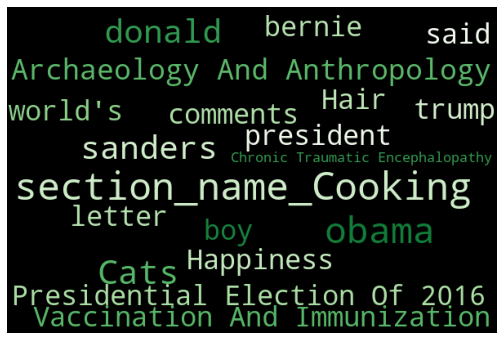

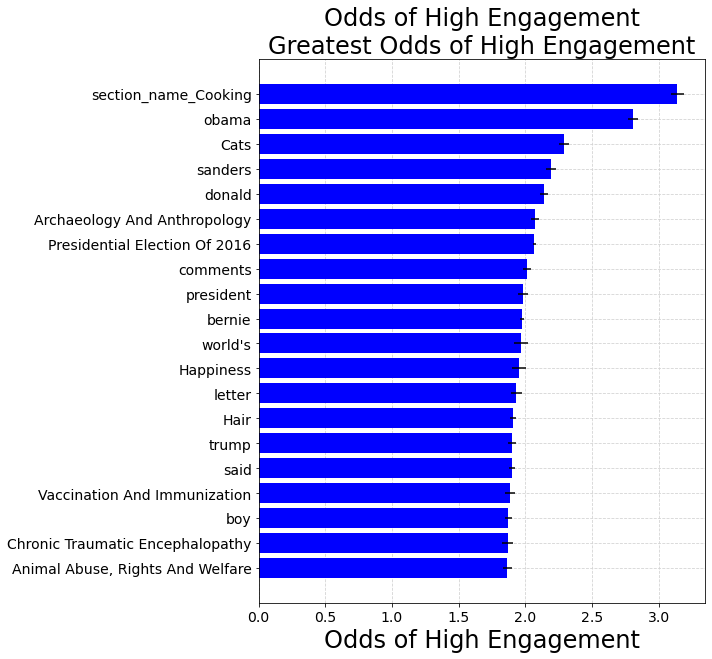

In [194]:
# Create visualizations for words with highest odds of high engagement
nlp_prep.generate_freqs_wordcloud(high_eng_art.loc[(high_eng_art['conf_min']>1) 
                                            & (high_eng_art['count']>1)], 
                        'Formatted Feature', high_label, 
                         cmap="Greens", min_font_size=16)

plot_topfeatures_w_se(high_eng_art.loc[(high_eng_art['conf_min']>1) 
                        & (high_eng_art['count']>1)], 
               'Formatted Feature', high_label, 20, 
               f"Greatest {high_label}", 'std_error')

### Categorical Features Only

In [195]:
_, mat_ohe_feats, mat_sub_feats, _ = get_matched_data_features(
    best_mat_binary_pipe)

high_eng_art.loc[(high_eng_art["Feature"].isin(mat_ohe_feats)) & 
                 (high_eng_art["conf_min"]>1) & 
                 (high_eng_art["count"]>1)]

Formatted Feature                   Feature  \
0         section_name_Cooking      section_name_Cooking   
651        section_name_Travel       section_name_Travel   
695         section_name_Style        section_name_Style   
783         word_count_cat_Low        word_count_cat_Low   
800        word_count_cat_None       word_count_cat_None   
979   section_name_Real Estate  section_name_Real Estate   
1048      section_name_Opinion      section_name_Opinion   
1441              has_person_1              has_person_1   
2153      section_name_NYT Now      section_name_NYT Now   

      Odds of High Engagement       std   min   max  count  std_error  \
0                       3.140  0.148997  2.93  3.39   10.0   0.047117   
651                     1.202  0.044672  1.14  1.28   10.0   0.014126   
695                     1.190  0.024037  1.15  1.22   10.0   0.007601   
783                     1.171  0.009944  1.16  1.18   10.0   0.003145   
800                     1.167  0.034335  1.13  1.24   10.0   0.010858   
979                     1.137  0.041110  1.09  1.23   10.0   0.013000   
1048                    1.127  0.016364  1.11  1.15   10.0   0.005175   
1441                    1.086  0.008433  1.07  1.10   10.0   0.002667   
2153                    1.038  0.013038  1.03  1.06    5.0   0.005831   

      conf_min  
0     3.045766  
651   1.173747  
695   1.174798  
783   1.164711  
800   1.145285  
979   1.111000  
1048  1.116651  
1441  1.080667  
2153  1.026338

### Subject KWs Only

In [273]:
# high_eng_art.loc[(high_eng_art["Feature"].isin(mat_sub_feats)) & 
#                  (high_eng_art["conf_min"]>1) & 
#                  (high_eng_art["count"]>1)][:300].\
#     to_csv('data/high_kws.csv')

In [197]:
high_eng_art.loc[(high_eng_art["Feature"].isin(mat_sub_feats)) & 
                  (high_eng_art["conf_min"]>1) & 
                  (high_eng_art["count"]>1), ['Formatted Feature', high_label]][:20]

Formatted Feature  Odds of High Engagement
2                               Cats                    2.288
5       Archaeology And Anthropology                    2.074
6      Presidential Election Of 2016                    2.067
11                         Happiness                    1.952
13                              Hair                    1.906
16      Vaccination And Immunization                    1.883
18  Chronic Traumatic Encephalopathy                    1.867
19  Animal Abuse, Rights And Welfare                    1.866
20               Deaths (Obituaries)                    1.850
21                   Beauty Contests                    1.835
22                 First Ladies (Us)                    1.833
26              Olympic Games (2016)                    1.786
28                  Muslim Americans                    1.766
29                            Iphone                    1.754
30                       Mathematics                    1.739
32          Cosmetics And Toiletries                    1.735
35                            Coffee                    1.697
38          Records And Achievements                    1.688
40                     Immune System                    1.683
43                         Marriages                    1.676

### Low Engagement

In [198]:
xval_low_art_dfs = []

# loop through each fitted estimator and get coefficients
for i, pipe in enumerate(binary_xval_art_results['estimator']):
    res_df = binary_target_oddsdf(pipe, pipe.named_steps['clf'], 
                                  get_matched_data_features, 
                                  low_label, class_int=0)
    
    res_df['fit_num'] = i + 1
    
    xval_low_art_dfs.append(res_df)
    
# combine results from each fitted estimator into one dataframe
xval_low_art_df = pd.concat(xval_low_art_dfs)

# get average odds ratios and confidence intervals

low_eng_art = get_mean_coefs(xval_low_art_df, low_label)
low_eng_art.head(20)

Formatted Feature  \
0                       Midterm Elections (2014)   
1                                       ferguson   
2                            Mobile Applications   
3                                       security   
4                  Murders And Attempted Murders   
5                                            may   
6         Automobile Safety Features And Defects   
7                                       briefing   
8   Middle East And North Africa Unrest (2010- )   
9                                         toward   
10                            section_name_Blogs   
11                       section_name_Technology   
12                                        sports   
13                                     Detainees   
14                                   Ebola Virus   
15                                           new   
16                 September Fashion Week (2014)   
17                                        forces   
18                                        future   
19                                        issues   

                                             Feature  Odds of Low Engagement  \
0                       sub_midterm elections (2014)                   2.941   
1                                           ferguson                   2.420   
2                            sub_mobile applications                   2.231   
3                                           security                   2.139   
4                  sub_murders and attempted murders                   2.002   
5                                                may                   1.985   
6         sub_automobile safety features and defects                   1.984   
7                                           briefing                   1.914   
8   sub_middle east and north africa unrest (2010- )                   1.911   
9                                             toward                   1.897   
10                                section_name_Blogs                   1.885   
11                           section_name_Technology                   1.874   
12                                            sports                   1.871   
13                                     sub_detainees                   1.852   
14                                   sub_ebola virus                   1.847   
15                                               new                   1.846   
16                 sub_september fashion week (2014)                   1.845   
17                                            forces                   1.837   
18                                            future                   1.832   
19                                            issues                   1.820   

         std   min   max  count  std_error  conf_min  
0   0.183027  2.72  3.39   10.0   0.057878  2.825244  
1   0.120922  2.27  2.64   10.0   0.038239  2.343522  
2   0.125914  2.09  2.49   10.0   0.039818  2.151365  
3   0.114061  2.01  2.33   10.0   0.036069  2.066861  
4   0.110534  1.86  2.26   10.0   0.034954  1.932092  
5   0.080173  1.86  2.12   10.0   0.025353  1.934294  
6   0.131926  1.78  2.17   10.0   0.041719  1.900563  
7   0.058348  1.85  2.03   10.0   0.018451  1.877098  
8   0.108059  1.75  2.12   10.0   0.034171  1.842658  
9   0.100449  1.72  2.08   10.0   0.031765  1.833470  
10  0.175452  1.68  2.32   10.0   0.055483  1.774035  
11  0.071523  1.74  1.98   10.0   0.022618  1.828765  
12  0.081711  1.76  1.99   10.0   0.025839  1.819322  
13  0.091627  1.73  2.04   10.0   0.028975  1.794050  
14  0.084202  1.68  1.94   10.0   0.026627  1.793746  
15  0.101017  1.65  1.97   10.0   0.031944  1.782111  
16  0.104483  1.76  2.04   10.0   0.033040  1.778919  
17  0.087946  1.68  1.93   10.0   0.027811  1.781378  
18  0.112625  1.67  2.01   10.0   0.035615  1.760770  
19  0.102307  1.69  2.01   10.0   0.032352  1.755296

- Although the presidential election was a top predictor of high engagement, general words such as `government`, and subjects such as 2014 Midterm Elections, Political Advertising, Jury System, and Politics and Government are top predictors of low engagement. My reading of this is that the competition of the presidential election drew people in, but every day political events are less engaging.
- Some top predictors are also far away from the US, such as Ebola Virus, Middle East and North Africa Unrest, Brussels Attacks.
- Interestingly, the subject Multimedia/Photos is a top predictor of low, although when looking at the types of Facebook posts videos and photos seemed to get more engagement. It may be there is a difference between these classifications.

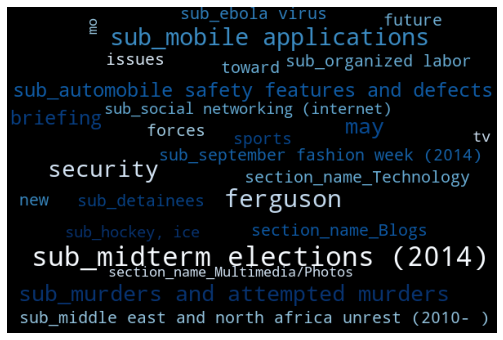

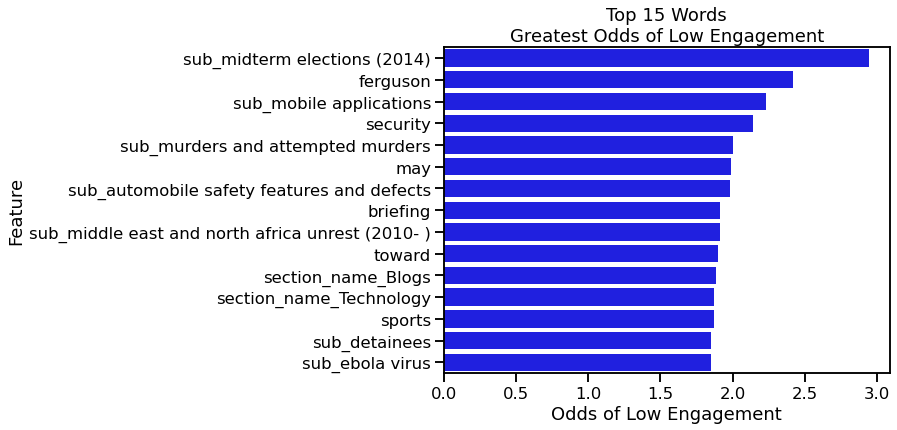

In [199]:
# Create visualizations for words with highest odds of low engagement
nlp_prep.generate_freqs_wordcloud(low_eng_art, 'Feature', low_label, 
                         cmap="Blues", min_font_size=16)

nlp_prep.plot_wordfreqs(low_eng_art, 'Feature', low_label, 15, 
               f"Greatest {low_label}")

### Categorical Features Only

In [200]:
low_eng_art.loc[(low_eng_art["Feature"].isin(mat_ohe_feats)) & 
                 (low_eng_art["conf_min"]>1) & 
                 (low_eng_art["count"]>1)]

Formatted Feature                         Feature  \
10                section_name_Blogs              section_name_Blogs   
11           section_name_Technology         section_name_Technology   
24    section_name_Multimedia/Photos  section_name_Multimedia/Photos   
53             section_name_New York           section_name_New York   
77            section_name_Education          section_name_Education   
79                section_name_Books              section_name_Books   
104             section_name_Theater            section_name_Theater   
106              section_name_Sports             section_name_Sports   
111               section_name_World              section_name_World   
127             section_name_Science            section_name_Science   
190          section_name_Your Money         section_name_Your Money   
244                section_name_Food               section_name_Food   
294        section_name_Business Day       section_name_Business Day   
489          section_name_The Upshot         section_name_The Upshot   
490               section_name_Other              section_name_Other   
568          section_name_T Magazine         section_name_T Magazine   
827                section_name_U.S.               section_name_U.S.   
1371    section_name_Fashion & Style    section_name_Fashion & Style   
1406               is_multimedia_1.0               is_multimedia_1.0   
1812             section_name_Health             section_name_Health   
2118             section_name_Movies             section_name_Movies   
2133                       has_org_1                       has_org_1   
2189           section_name_Magazine           section_name_Magazine   
3450            section_name_NYT Now            section_name_NYT Now   
3487                       has_geo_1                       has_geo_1   
3829             word_count_cat_High             word_count_cat_High   

      Odds of Low Engagement       std   min   max  count  std_error  conf_min  
10                   1.88500  0.175452  1.68  2.32   10.0   0.055483  1.774035  
11                   1.87400  0.071523  1.74  1.98   10.0   0.022618  1.828765  
24                   1.79200  0.071926  1.62  1.86   10.0   0.022745  1.746510  
53                   1.63300  0.024060  1.60  1.67   10.0   0.007608  1.617783  
77                   1.58500  0.056224  1.53  1.70   10.0   0.017780  1.549441  
79                   1.57900  0.064713  1.51  1.71   10.0   0.020464  1.538072  
104                  1.52400  0.079470  1.39  1.64   10.0   0.025131  1.473738  
106                  1.52300  0.031990  1.47  1.57   10.0   0.010116  1.502768  
111                  1.51600  0.032387  1.46  1.57   10.0   0.010242  1.495517  
127                  1.49200  0.028206  1.43  1.52   10.0   0.008919  1.474161  
190                  1.42000  0.066165  1.31  1.51   10.0   0.020923  1.378154  
244                  1.38300  0.061292  1.27  1.45   10.0   0.019382  1.344236  
294                  1.35500  0.032059  1.30  1.40   10.0   0.010138  1.334724  
489                  1.27200  0.035839  1.19  1.31   10.0   0.011333  1.249333  
490                  1.27100  0.061183  1.18  1.39   10.0   0.019348  1.232305  
568                  1.25300  0.048086  1.16  1.31   10.0   0.015206  1.222588  
827                  1.19500  0.021731  1.17  1.22   10.0   0.006872  1.181256  
1371                 1.11600  0.037178  1.05  1.15   10.0   0.011757  1.092486  
1406                 1.11300  0.037431  1.05  1.17   10.0   0.011837  1.089326  
1812                 1.08200  0.022010  1.04  1.11   10.0   0.006960  1.068080  
2118                 1.06700  0.049001  1.01  1.16   10.0   0.015496  1.036009  
2133                 1.06600  0.011738  1.05  1.08   10.0   0.003712  1.058576  
2189                 1.06400  0.027162  1.02  1.12   10.0   0.008589  1.046821  
3450                 1.02800  0.016432  1.01  1.05    5.0   0.007348  1.013303  
3487                 1.02625  0.007440  1.02  1.0

### Subject KWs Only

In [274]:
# low_eng_art.loc[(low_eng_art["Feature"].isin(mat_sub_feats)) & 
#                  (low_eng_art["conf_min"]>1) & 
#                  (low_eng_art["count"]>1)][:300].\
#     to_csv('data/low_kws.csv')

## FB - Review Prediction Accuracy

In [205]:
# Get predictions for X (binary problem)
preds_all = best_all_binary_pipe.predict(X_test_all)

In [210]:
Xtest_all_df = X_test_all.copy()
Xtest_all_df['fb_pred'] = preds_all
Xtest_all_df.tail()

cleaned post_type  \
44053  Republicans Worry a Falling Donald Trump Tide ...      link   
22120  Baltimore Police Finish Inquiry Into Death of ...      link   
23779  Champions League Final Is Just Latest Moment i...      link   
31553  A Year Without Tamir. 'In my head it's like: '...      link   
44190  Your Monday Briefing. Daily Briefing: Here's w...      link   

                    hour_cat  on_weekend  fb_pred  
44053  1_Early morning (3-7)         0.0      1.0  
22120       3_Midday (11-15)         0.0      0.0  
23779  1_Early morning (3-7)         1.0      0.0  
31553    6_Late night (23-3)         0.0      1.0  
44190  1_Early morning (3-7)         0.0      0.0

In [211]:
df = df.join(Xtest_all_df[['fb_pred']])
df[['cleaned', 'fb_pred', 'all_binary']].head()

cleaned  fb_pred  all_binary
0  Did Barack Obama Save Ohio?. 'There are severa...      NaN         0.0
1  The Weatherman Is Not a Moron. In , the chance...      NaN         0.0
2  The Organic Fable. 'Organic has long since bec...      NaN         0.0
3  Timeline Photos. Our special Arts & Leisure se...      NaN         0.0
4  Pot for Parents. 'When I'm rolling around the ...      1.0         0.0

In [212]:
predict_cols = ['cleaned', 'fb_pred', 'all_binary',
            'max_pct', 'mean_pct', 'comments_pct', 'comments_count',  
            'shares_pct', 'shares_count', 'likesloves_pct', 'likes_loves']

df.loc[df['fb_pred'].isna()==False, predict_cols]

cleaned  fb_pred  all_binary  \
4      Pot for Parents. 'When I'm rolling around the ...      1.0         0.0   
19     A Terrifying Way to Discipline Children. Op-Ed...      0.0         0.0   
20     Teacher Strike Begins in Chicago, Amid Signs T...      0.0         0.0   
24     Video of Police Altercation May Take Key Role ...      0.0         0.0   
25     What Work Is Really For. Is work good or bad? ...      0.0         0.0   
...                                                  ...      ...         ...   
47840  How to Be Mindful in the Voting Booth. Let go ...      0.0         0.0   
47850  A Coup Against the Supreme Court. Regardless o...      1.0         1.0   
47852  Naturalization: Becoming an American. Carmen J...      1.0         0.0   
47854  An Unfinished Presidency: Obama Passes the Bat...      1.0         1.0   
47861  'Westworld' Season , Episode : The Tipping Poi...      0.0         0.0   

        max_pct  mean_pct  comments_pct  comments_count  shares_pct  \
4      0.540039  0.487263      0.540039              83    0.539130   
19     0.668700  0.471570      0.585551              96    0.668700   
20     0.216114  0.146962      0.122237              19    0.216114   
24     0.289893  0.248520      0.289893              38    0.279227   
25     0.756215  0.583438      0.456733              64    0.756215   
...         ...       ...           ...             ...         ...   
47840  0.380521  0.253809      0.380521              51    0.232472   
47850  0.965497  0.899894      0.877314             327    0.965497   
47852  0.914334  0.726096      0.709042             147    0.554914   
47854  0.860705  0.755721      0.860705             294    0.592675   
47861  0.436552  0.297020      0.282058              37    0.172450   

       shares_count  likesloves_pct  likes_loves  
4               170        0.382620          502  
19              283        0.160458          244  
20               49        0.102536          187  
24               65        0.176440          260  
25              416        0.537365          782  
...             ...             ...          ...  
47840            53        0.148435          232  
47850          2309        0.856871         2801  
47852           181        0.914334         4339  
47854           209        0.813782         2190  
47861            40        0.436552          586  

[9574 rows x 11 columns]

### Was High, predicted Low

In [213]:
total = len(df.loc[df['fb_pred'].isna()==False])
print(total)

total_wrong = len(df.loc[(df['all_binary']==1) & (df['fb_pred']==0)])
total_wrong

9574


789

In [214]:
df.loc[(df['all_binary']==1) & (df['fb_pred']==0), predict_cols].describe()

fb_pred  all_binary     max_pct    mean_pct  comments_pct  \
count    789.0       789.0  789.000000  789.000000    789.000000   
mean       0.0         1.0    0.919822    0.850712      0.830185   
std        0.0         0.0    0.053606    0.066234      0.114003   
min        0.0         1.0    0.765899    0.750313      0.410949   
25%        0.0         1.0    0.880730    0.792964      0.752204   
50%        0.0         1.0    0.929240    0.843602      0.852275   
75%        0.0         1.0    0.966020    0.903752      0.922293   
max        0.0         1.0    0.999749    0.996915      0.999603   

       comments_count  shares_pct  shares_count  likesloves_pct    likes_loves  
count      789.000000  789.000000    789.000000      789.000000     789.000000  
mean       402.844106    0.869542   1384.351077        0.852410    4923.868188  
std        454.374298    0.089934   1678.909225        0.100645    8096.751332  
min         56.000000    0.519179    158.000000        0.404076     534.000000  
25%        174.000000    0.814670    565.000000        0.791125    1960.000000  
50%        280.000000    0.886255    904.000000        0.866471    2990.000000  
75%        462.000000    0.940480   1569.000000        0.932520    5252.000000  
max       7762.000000    0.999081  21985.000000        0.999749  172585.000000

799 of the 9,574 posts in the test set were incorrectly classified as low engagement although they should have been high (defined as average engagement metric percentile being above 75th). 

The percentiles for comments, shares, and likes/loves are all consistently above 75, so I don't see any particular patterns. The model just wasn't able to pick up on whatever trends these represented.

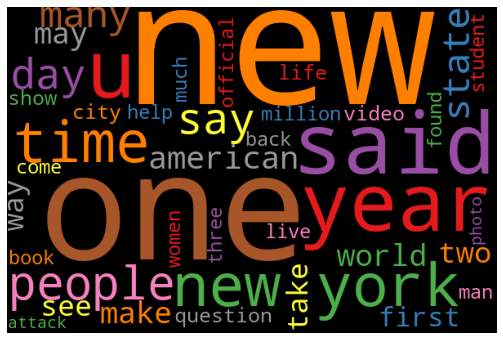

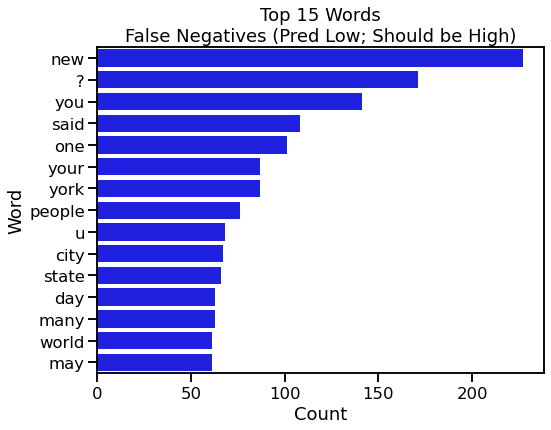

In [215]:
# False Negatives word frequencies
fn_token_dict = nlp_prep.tokenize_corpus_dict_tweet(
    df.loc[(df['all_binary']==1) & (df['fb_pred']==0)], [0, 1], 
    target_col='all_binary', stop_list=custom_stopwords + custom_punc, 
                                                 verbose=False)

fn_tokens = []
[fn_tokens.extend(tokens) for tokens in fn_token_dict.values()]

fn_corpus = FreqDist(fn_tokens)

fn_freq_df = pd.DataFrame(fn_corpus.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=fn_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='')

nlp_prep.plot_wordfreqs(fn_freq_df, 'Word', 'Count', 15, 
               "False Negatives (Pred Low; Should be High)")

Even though I removed the you/your permutations from the stopwords list during modeling, the models still didn't pick up on those words being predictors of High engagement. I see here that you and your appear frequently in the posts that should have been classified as High but were mis-classified as Low. It's possible that TF-IDF normalization worked against me in that regard. These words look like ones that would be quite common across the entire corpus.

Otherwise, the top words look pretty average to me.

### Was Low, predicted High

In [216]:
print(total)

total_wrong2 = len(df.loc[(df['all_binary']==0) & (df['fb_pred']==1)])
total_wrong2

9574


2417

In [217]:
df.loc[(df['all_binary']==0) & (df['fb_pred']==1), predict_cols].describe()

fb_pred  all_binary      max_pct     mean_pct  comments_pct  \
count   2417.0      2417.0  2417.000000  2417.000000   2417.000000   
mean       1.0         0.0     0.622396     0.474369      0.481038   
std        0.0         0.0     0.217424     0.187862      0.247415   
min        1.0         0.0     0.006069     0.002490      0.000460   
25%        1.0         0.0     0.478241     0.338138      0.282058   
50%        1.0         0.0     0.668846     0.504077      0.479641   
75%        1.0         0.0     0.794113     0.633115      0.679553   
max        1.0         0.0     0.995717     0.749969      0.995717   

       comments_count   shares_pct  shares_count  likesloves_pct   likes_loves  
count     2417.000000  2417.000000    2417.00000     2417.000000   2417.000000  
mean       107.848573     0.465137     193.29789        0.476933    923.175424  
std        124.992497     0.229945     196.14474        0.233114    882.960545  
min          0.000000     0.006069       0.00000        0.000731      9.000000  
25%         37.000000     0.291167      68.00000        0.301519    396.000000  
50%         69.000000     0.483026     139.00000        0.489314    681.000000  
75%        132.000000     0.642272     254.00000        0.661607   1164.000000  
max       2270.000000     0.987319    4342.00000        0.984373  14730.000000

2,408 of the 9,574 posts in the test set were incorrectly classified as high engagement although they should have been low (defined as average engagement metric percentile being below 75th). 

The percentiles for comments, shares, and likes/loves are all consistently below 75, so I don't see any particular patterns.

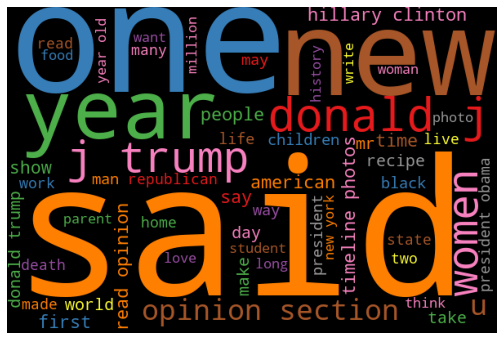

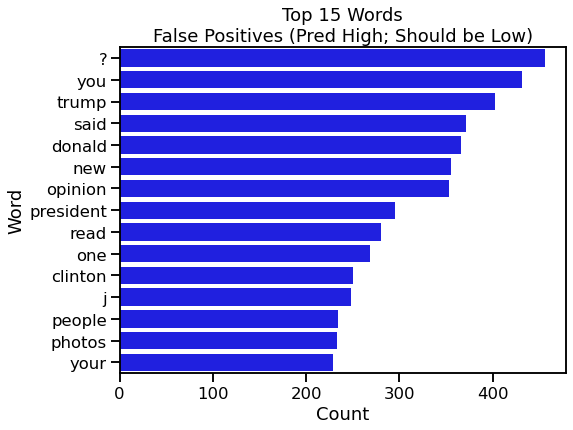

In [218]:
# False Positives word frequencies
fp_token_dict = nlp_prep.tokenize_corpus_dict_tweet(
    df.loc[(df['all_binary']==0) & (df['fb_pred']==1)], [0, 1], 
    target_col='all_binary', stop_list=custom_stopwords + custom_punc, 
                                                 verbose=False)

fp_tokens = []
[fp_tokens.extend(tokens) for tokens in fp_token_dict.values()]

fp_corpus = FreqDist(fp_tokens)

fp_freq_df = pd.DataFrame(fp_corpus.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=fp_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='False Positives (should be Low)')

nlp_prep.plot_wordfreqs(fp_freq_df, 'Word', 'Count', 15, 
               "False Positives (Pred High; Should be Low)")

I see lots of mentions of presidential stuff (Trump, Clinton, President), as well as Opinion. I can see why these might have been mis-classified as High even though they were Low.

## Matched - Review Prediction Accuracy

In [219]:
# Get predictions for X (binary problem)
preds_mat = best_mat_binary_pipe.predict(X_test_mat)

In [220]:
Xtest_mat_df = X_test_mat.copy()
Xtest_mat_df['mat_pred'] = preds_mat
Xtest_mat_df.tail()

cleaned  \
24466  The People v. the Coal Baron . Don Blankenship...   
47591  Trump, Waking a 'Sleeping Giant,' Helps Clinto...   
37810  Sorry, You Can't Speed Read. Don't be fooled b...   
37535  In California, Marijuana Is Smelling More Like...   
12708  Savannah, Both Sides. Beneath its trademark So...   

                                                 subject  section_name  \
24466  [coal, explosions (accidental), deaths (fatali...  Business Day   
47591  [presidential election of 2016, minorities, wo...          U.S.   
37810  [reading and writing skills (education), resea...       Opinion   
37535  [marijuana, agriculture and farming, law and l...          U.S.   
12708  [travel and vacations, blacks, black people, s...        Travel   

      word_count_cat  is_multimedia  has_person  has_org  has_geo  mat_pred  
24466           High            0.0           1        1        1       0.0  
47591           High            0.0           1        1        1       1.0  
37810            Low            0.0           0        1        0       1.0  
37535        Average            0.0           0        0        1       0.0  
12708           High            0.0           1        0        1       0.0

In [221]:
df = df.join(Xtest_mat_df[['mat_pred']])
df[['cleaned', 'mat_pred', 'm_binary']].head()

cleaned  mat_pred  m_binary
0  Did Barack Obama Save Ohio?. 'There are severa...       NaN       0.0
1  The Weatherman Is Not a Moron. In , the chance...       NaN       0.0
2  The Organic Fable. 'Organic has long since bec...       NaN       0.0
3  Timeline Photos. Our special Arts & Leisure se...       NaN       0.0
4  Pot for Parents. 'When I'm rolling around the ...       NaN       0.0

In [222]:
predict_cols = ['cleaned', 'mat_pred', 'm_binary',
            'max_pct', 'mean_pct', 'comments_pct', 'comments_count',  
            'shares_pct', 'shares_count', 'likesloves_pct', 'likes_loves']

df.loc[df['mat_pred'].isna()==False, predict_cols]

cleaned  mat_pred  m_binary  \
6      Debt Collectors Cashing In on Student Loan Rou...       1.0       0.0   
17     What Keeps the Chinese Up at Night. Op-Ed cont...       0.0       0.0   
18     Biden and the Bikers. Vice President Joe Biden...       0.0       0.0   
39     Reclaiming the Title of Fastest in the Land. W...       1.0       0.0   
40     Vets and Physicians Find Parallels in Medical ...       0.0       0.0   
...                                                  ...       ...       ...   
47830  After Bill Cosby, States Shift on Statutes of ...       0.0       0.0   
47834  Presidential Election: The Day Before the Stor...       1.0       0.0   
47841  Listening to This New Podcast Could Save Your ...       0.0       0.0   
47842  On Election Day, the Hillary Clinton White Sui...       1.0       1.0   
47847  Whole-Roasted Stuffed Squash Recipe. A vegetar...       1.0       0.0   

        max_pct  mean_pct  comments_pct  comments_count  shares_pct  \
6      0.502789  0.354319      0.502789              74    0.383727   
17     0.365322  0.187778      0.131711              20    0.365322   
18     0.169087  0.119048      0.169087              24    0.105910   
39     0.614789  0.533636      0.597982             100    0.614789   
40     0.443739  0.296205      0.159915              23    0.443739   
...         ...       ...           ...             ...         ...   
47830  0.346373  0.286849      0.312006              41    0.202169   
47834  0.705522  0.561401      0.705522             145    0.386819   
47841  0.249300  0.104350      0.249300              33    0.041700   
47842  0.973405  0.940535      0.905309             399    0.942893   
47847  0.515554  0.371367      0.386819              52    0.515554   

       shares_count  likesloves_pct  likes_loves  
6                96        0.176440          260  
17               90        0.066300          147  
18               27        0.082146          165  
39              228        0.388136          510  
40              120        0.284962          377  
...             ...             ...          ...  
47830            46        0.346373          452  
47834            97        0.591861          919  
47841            13        0.022051           88  
47842          1617        0.973405        10409  
47847           156        0.211726          297  

[8646 rows x 11 columns]

### Was High, predicted Low

In [223]:
total = len(df.loc[df['mat_pred'].isna()==False])
print(total)

total_wrong = len(df.loc[(df['m_binary']==1) & (df['mat_pred']==0)])
total_wrong

8646


719

In [224]:
df.loc[(df['m_binary']==1) & (df['mat_pred']==0), predict_cols].describe()

mat_pred  m_binary     max_pct    mean_pct  comments_pct  \
count     719.0     719.0  719.000000  719.000000    719.000000   
mean        0.0       1.0    0.913014    0.842229      0.819872   
std         0.0       0.0    0.054408    0.066069      0.112351   
min         0.0       1.0    0.760529    0.745122      0.445943   
25%         0.0       1.0    0.875867    0.786806      0.745895   
50%         0.0       1.0    0.918711    0.834068      0.838163   
75%         0.0       1.0    0.958708    0.894475      0.906217   
max         0.0       1.0    0.999645    0.997458      0.998997   

       comments_count  shares_pct  shares_count  likesloves_pct    likes_loves  
count      719.000000  719.000000    719.000000      719.000000     719.000000  
mean       371.584145    0.860873   1276.255911        0.845941    4692.228095  
std        406.088994    0.091168   1541.406627        0.102378    8333.374544  
min         62.000000    0.445817    121.000000        0.411158     545.000000  
25%        170.000000    0.806152    536.500000        0.784550    1895.000000  
50%        258.000000    0.871600    808.000000        0.864058    2936.000000  
75%        401.500000    0.933961   1436.000000        0.922215    4683.500000  
max       4372.000000    0.998788  18607.000000        0.999645  132853.000000

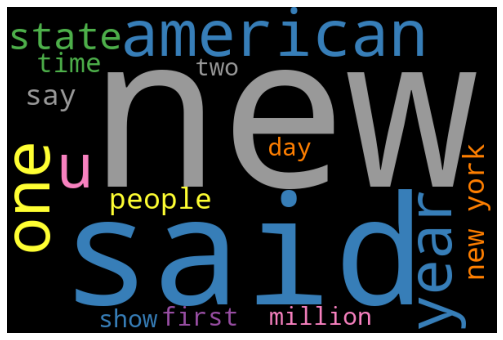

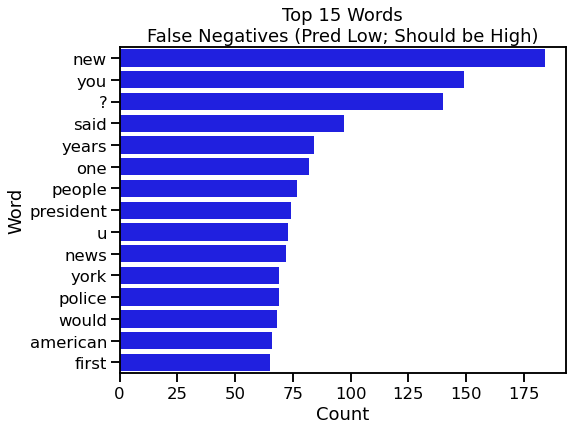

In [225]:
# False Negatives word frequencies
fn_token_dict = nlp_prep.tokenize_corpus_dict_tweet(
    df.loc[(df['m_binary']==1) & (df['mat_pred']==0)], [0, 1], 
    target_col='m_binary', stop_list=custom_stopwords + custom_punc, 
                                                 verbose=False)

fn_tokens = []
[fn_tokens.extend(tokens) for tokens in fn_token_dict.values()]

fn_corpus = FreqDist(fn_tokens)

fn_freq_df = pd.DataFrame(fn_corpus.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=fn_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='')

nlp_prep.plot_wordfreqs(fn_freq_df, 'Word', 'Count', 15, 
               "False Negatives (Pred Low; Should be High)")

### Was Low, predicted High

In [226]:
print(total)

total_wrong2 = len(df.loc[(df['m_binary']==0) & (df['mat_pred']==1)])
total_wrong2

8646


2123

In [227]:
df.loc[(df['m_binary']==0) & (df['mat_pred']==1), predict_cols].describe()

mat_pred  m_binary      max_pct     mean_pct  comments_pct  \
count    2123.0    2123.0  2123.000000  2123.000000   2123.000000   
mean        1.0       0.0     0.622351     0.476926      0.488478   
std         0.0       0.0     0.212718     0.184116      0.241897   
min         1.0       0.0     0.015376     0.007333      0.000460   
25%         1.0       0.0     0.489256     0.344859      0.297476   
50%         1.0       0.0     0.666235     0.508740      0.493482   
75%         1.0       0.0     0.788341     0.633069      0.671312   
max         1.0       0.0     0.986849     0.745996      0.986849   

       comments_count   shares_pct  shares_count  likesloves_pct  likes_loves  
count     2123.000000  2123.000000   2123.000000     2123.000000  2123.000000  
mean       108.593971     0.473599    194.562412        0.468701   870.788036  
std        118.557899     0.219869    179.628114        0.231339   713.408058  
min          0.000000     0.006069      0.000000        0.000345     6.000000  
25%         39.000000     0.305833     72.000000        0.286592   379.000000  
50%         72.000000     0.495487    145.000000        0.488865   680.000000  
75%        128.000000     0.642324    254.000000        0.651569  1124.000000  
max       1351.000000     0.935758   1471.000000        0.929198  5055.000000

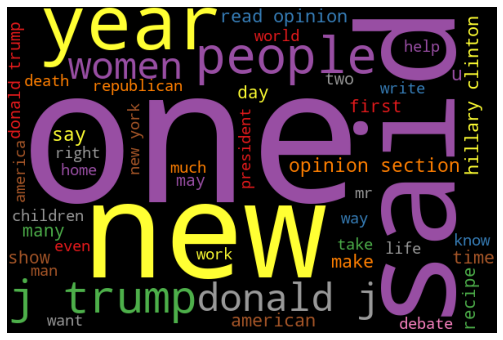

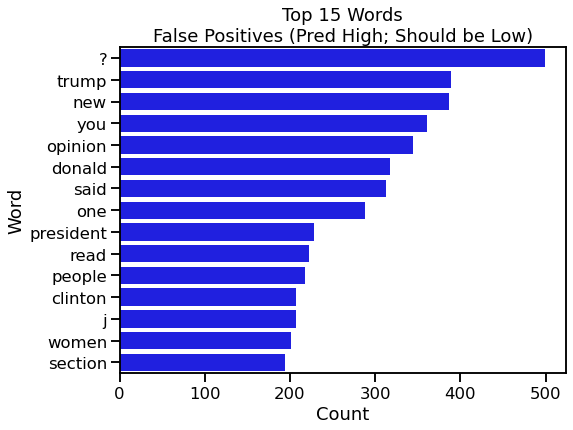

In [228]:
# False Positives word frequencies
fp_token_dict = nlp_prep.tokenize_corpus_dict_tweet(
    df.loc[(df['m_binary']==0) & (df['mat_pred']==1)], [0, 1], 
    target_col='m_binary', stop_list=custom_stopwords + custom_punc, 
                                                 verbose=False)

fp_tokens = []
[fp_tokens.extend(tokens) for tokens in fp_token_dict.values()]

fp_corpus = FreqDist(fp_tokens)

fp_freq_df = pd.DataFrame(fp_corpus.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=fp_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='False Positives (should be Avg)')

nlp_prep.plot_wordfreqs(fp_freq_df, 'Word', 'Count', 15, 
               "False Positives (Pred High; Should be Low)")

I see lots of mentions of presidential stuff (Trump, Clinton, President), as well as Opinion. I can see why these might have been mis-classified as High even though they were Low.

### Performance Insights

The binary classifiers performed slightly better than the multi-class, but looking at the confusion matrices for the multi-class classifiers, they show that High and Low posts are most often classified as Moderate.

I think one challenge to achieve better performance with these models is that there is no clear delineation between High engagement and any other level. I chose a reasonable cutoff point, but it could easily have been drawn elsewhere. Initially I also tried calling outliers in terms of any engagement category high engagement, but that didn't perform any better. The engagement metric distributions all had a pretty smooth taper off, so I'm not surprised that the models uniformly got confused.

The posts that were misclassified in both the Facebook and the matched article models shared most frequent words in common with the other class, so I can see why the models got confused.

Facebook has its own algorithm that ultimately decides what content is presented to users in their feed in what priority. I think it's likely the effect of their algorithm (which we can't model here) is the reason some posts got less engagement than others with similar words and topics.

Since the two models based on slightly different text agreed on many words, I think that although these models didn't achieve a high degree of accuracy, they did pick up on the strongest signals in the data. Because they only picked up on the strongest signals, with a little interpretation I think the results will be fairly applicable to future articles.

However, since the specific terms associated with topical themes will differ over time (candidates for a given presidential election year, for example) the model would probably not be very accurate in predicting future high engagement articles unless it was continually retrained. I believe that a general understanding of the topics and themes of highly engaging content is much more useful than using the model itself to choose which articles to post.

## Explore Top Predictors of High Engagement

In [229]:
def plot_hits_vs_pop(df, re_string, subset_title, display_hits=True,
                    search_text_col='cleaned', full_text_col='all_text'):
    """Searches for a regex string in the `cleaned` text column and marks hits.
    
    Re-formats dataframe to be able to plot engagement metric counts in the hits
    subset versus counts in the entire population.
    
    Plots engagement metric counts for entire population versus hits, using
    specified estimator (mean or median).
    """
    
    #search_text_col = 'cleaned'
    #full_text_col = 'all_text'
    value_cols = ['comments_count', 'shares_count', 'likes_loves']
    pct_cols = ['comments_pct', 'shares_pct', 'likesloves_pct', 'mean_pct']
    copy_cols = [search_text_col, full_text_col] + value_cols + pct_cols

    # copy relevant columns from main df
    df_temp = df[copy_cols].copy()
    df_temp['Population'] = 'All Posts'

    # copy relevant columns only for hits
    df_temp2 = df.loc[(df[search_text_col].str.contains(re_string, regex=True, 
                    case=False)), copy_cols].copy()
    df_temp2['Population'] = 'Subset'

    # concat dfs
    df_temp = df_temp.append(df_temp2, ignore_index=True)

    # melt df to convert to long form
    df_melted = pd.melt(df_temp, id_vars=['Population'], 
            value_vars=value_cols)

    # dict to map plotting-friendly names
    engage_dict = {'comments_count': "Comments", 'shares_count': 'Shares', 
                   'likes_loves': 'Likes/Loves'}
    
    # map plotting-friendly names
    df_melted['variable'] = df_melted['variable'].map(lambda x: engage_dict[x])
    
    print(f"Number of hits: {len(df_temp2)}")
    print()

    # plot
    my_palette = sns.color_palette(palette=['grey', 'limegreen'])

    with sns.plotting_context('talk'):
        # plot median
        fig, ax = plt.subplots(figsize=(8, 6))

        sns.barplot(data=df_melted, x='variable', y='value', hue='Population',
               estimator=np.median, palette=my_palette)

        ax.set_title(f'Median Engagement Counts for Subset:\n {subset_title}')
        ax.set_xlabel('Engagement Type')
        ax.set_ylabel(f'Median Count');
        
        fig, ax = plt.subplots(figsize=(8, 6))

        sns.barplot(data=df_melted, x='variable', y='value', hue='Population',
               estimator=np.mean, palette=my_palette)

        ax.set_title(f'Mean Engagement Counts for Subset:\n {subset_title}')
        ax.set_xlabel('Engagement Type')
        ax.set_ylabel(f'Mean Count');
        
    df_temp2.sort_values(by='mean_pct', inplace=True, ascending=False)
    
    if display_hits:
    
        # display top engagement
        print()
        print("Top engagement:")
        display(df_temp2[[full_text_col] + value_cols].head(10)\
                .style.set_properties(**{'white-space': 'pre-wrap', 
                                         'text-align': 'left'}))

        # display least engagement
        print()
        print("Least engagement:")
        display(df_temp2[[full_text_col] + value_cols].tail()\
                .style.set_properties(**{'white-space': 'pre-wrap', 
                                         'text-align': 'left'}))
        
    return df_temp2

In [230]:
def plot_listmatches_vs_pop(df, search_list, subset_title, display_hits=True,
                    search_text_col='cleaned', full_text_col='all_text'):
    """Searches list of values in a dataframe column that contains a list.
    
    Re-formats dataframe to be able to plot engagement metric counts in the hits
    subset versus counts in the entire population.
    
    Plots engagement metric counts for entire population versus hits, using
    specified estimator (mean or median).
    """
    
    #search_text_col = 'cleaned'
    #full_text_col = 'all_text'
    value_cols = ['comments_count', 'shares_count', 'likes_loves']
    pct_cols = ['comments_pct', 'shares_pct', 'likesloves_pct', 'mean_pct']
    copy_cols = [search_text_col, full_text_col] + value_cols + pct_cols

    # copy relevant columns from main df
    df_temp = df[copy_cols].copy()
    df_temp['Population'] = 'All Posts'

    # copy relevant columns only for hits
    df_temp2 = df.loc[df[search_text_col].map(
        lambda x: not set(search_list).isdisjoint(x)), copy_cols].copy()
    
    df_temp2['Population'] = 'Subset'

    # concat dfs
    df_temp = df_temp.append(df_temp2, ignore_index=True)

    # melt df to convert to long form
    df_melted = pd.melt(df_temp, id_vars=['Population'], 
            value_vars=value_cols)

    # dict to map plotting-friendly names
    engage_dict = {'comments_count': "Comments", 'shares_count': 'Shares', 
                   'likes_loves': 'Likes/Loves'}
    
    # map plotting-friendly names
    df_melted['variable'] = df_melted['variable'].map(lambda x: engage_dict[x])

    # plot
    my_palette = sns.color_palette(palette=['grey', 'limegreen'])

    with sns.plotting_context('talk'):
        # plot median
        fig, ax = plt.subplots(figsize=(8, 6))

        sns.barplot(data=df_melted, x='variable', y='value', hue='Population',
               estimator=np.median, palette=my_palette)

        ax.set_title(f'Median Engagement Counts for Subset:\n {subset_title}')
        ax.set_xlabel('Engagement Type')
        ax.set_ylabel(f'Median Count');
        
        fig, ax = plt.subplots(figsize=(8, 6))

        sns.barplot(data=df_melted, x='variable', y='value', hue='Population',
               estimator=np.mean, palette=my_palette)

        ax.set_title(f'Mean Engagement Counts for Subset:\n {subset_title}')
        ax.set_xlabel('Engagement Type')
        ax.set_ylabel(f'Mean Count');
        
    df_temp2.sort_values(by='mean_pct', inplace=True, ascending=False)
    
    if display_hits:
    
        # display top engagement
        print()
        print("Top engagement:")
        display(df_temp2[[full_text_col] + value_cols].head(10)\
                .style.set_properties(**{'white-space': 'pre-wrap', 
                                         'text-align': 'left'}))

        # display least engagement
        print()
        print("Least engagement:")
        display(df_temp2[[full_text_col] + value_cols].tail()\
                .style.set_properties(**{'white-space': 'pre-wrap', 
                                         'text-align': 'left'}))
        
    return df_temp2

### Names of 2016 Presidential Candidates

Number of hits: 3652


Top engagement:



Least engagement:


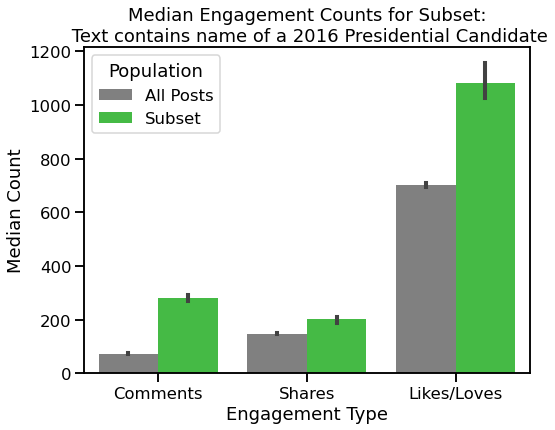

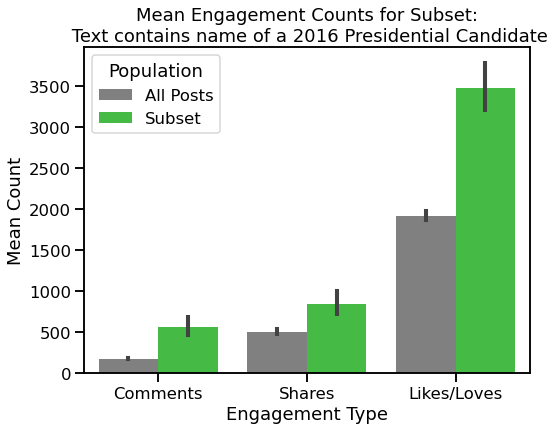

In [231]:
# posts containing 2016 presidential candidates names
terms = ['trump', 'donald', 'bernie', 'sanders', 'clinton', 'hillary']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains name of a 2016 Presidential Candidate'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

More likes/loves and comments than shares. People may not have been as eager to share these types of posts widely, given the polarity of that race and likelihood that they have friends in the opposite political party.

### Obama

Number of hits: 2094


Top engagement:



Least engagement:


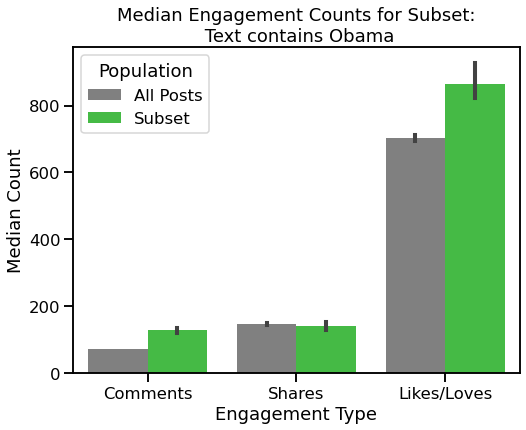

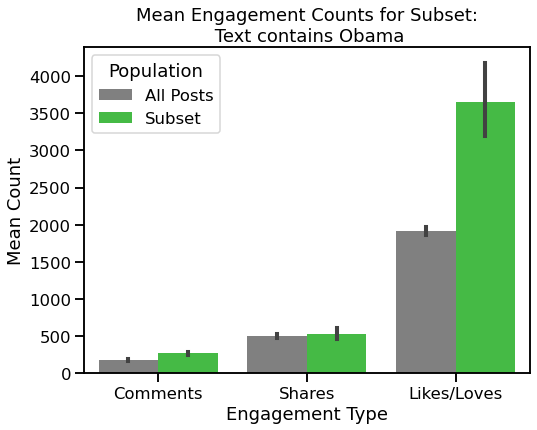

In [232]:
terms = ['obama', 'barack']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Obama'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Women

Number of hits: 1677


Top engagement:



Least engagement:


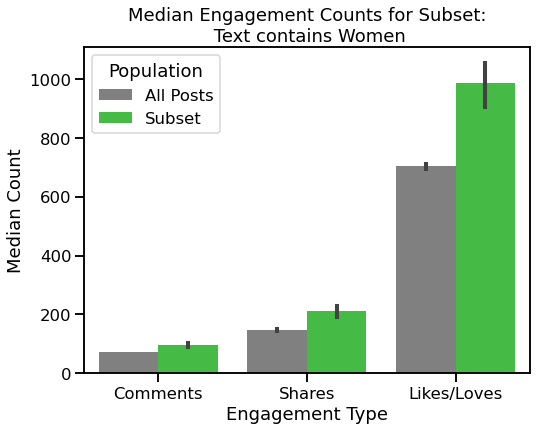

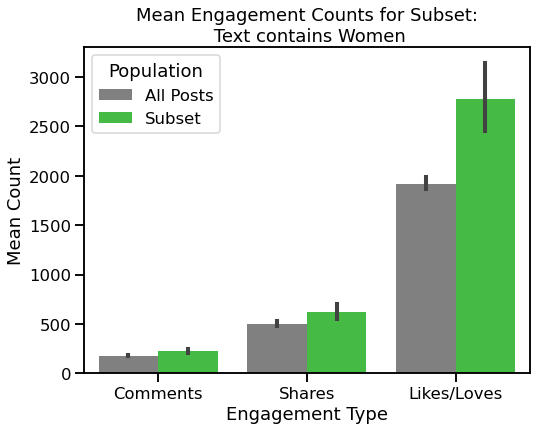

In [233]:
# posts containing women
terms = ['women']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Women'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

Many of the posts with the word 'women' are actually related to Donald Trump's words and actions regarding women, so I think the strength of this word is definitely partially due to its relation to the presidential race.

### Breaking News

Number of hits: 1074


Top engagement:



Least engagement:


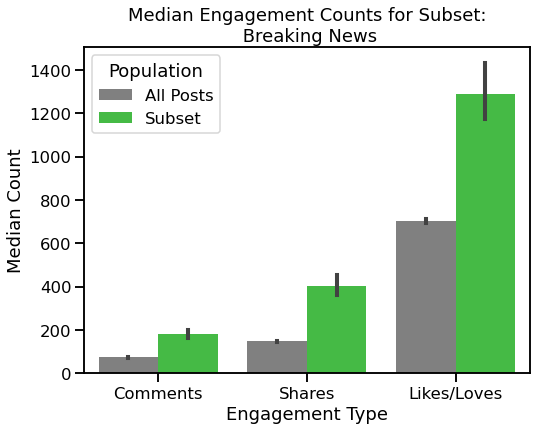

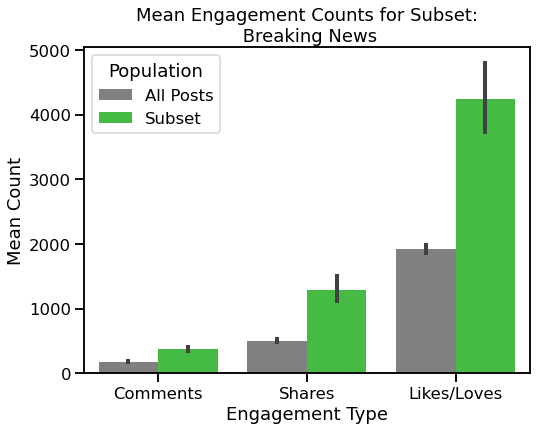

In [234]:
# posts containing breaking or breaking news
terms = ['breaking news', 'breaking']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Breaking News'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)


A pretty broad set of topics here, and significantly higher engagement across all categories.

### Opinion

Number of hits: 4342


Top engagement:



Least engagement:


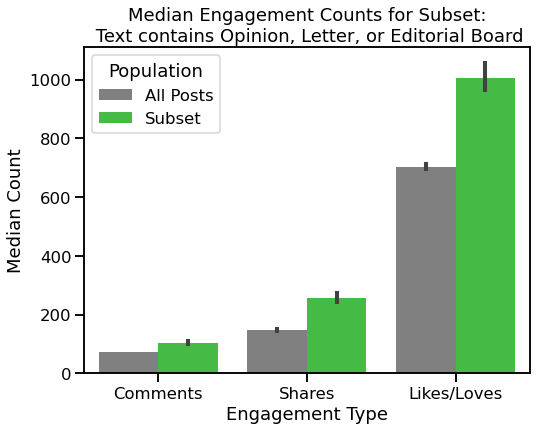

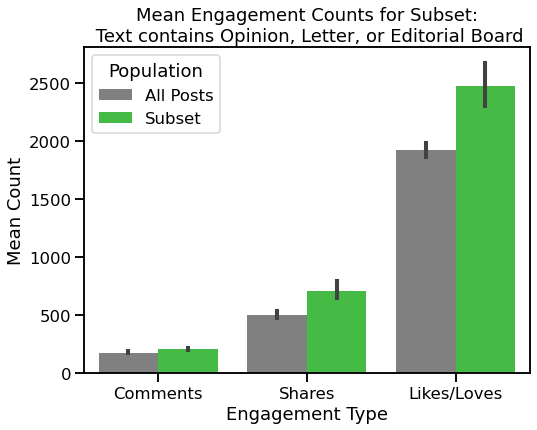

In [235]:
# posts containing opinion
terms = ['writes opinion', 'read opinion', 'opinion', 'editorial board',
        'letter', 'board writes', 'board', 'editorial']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Opinion, Letter, or Editorial Board'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

The top opinion-related posts are also related to the presidential candidates, Trump's views on women, and gun violence.

### Recipe

Number of hits: 935


Top engagement:



Least engagement:


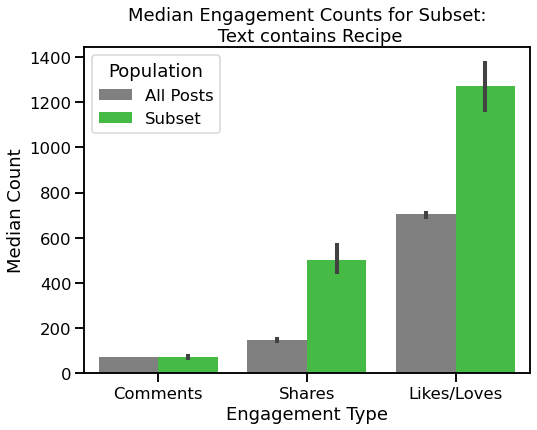

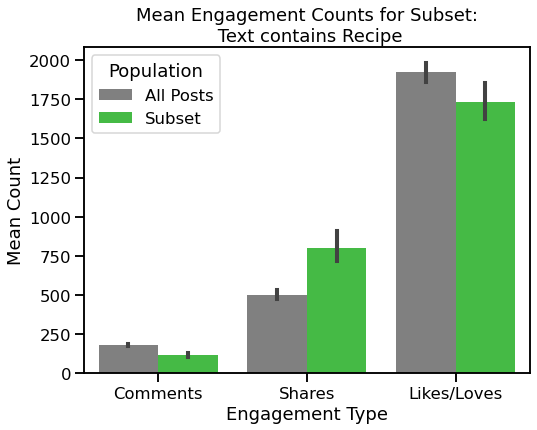

In [236]:
# posts containing recipe
terms = ['recipe']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Recipe'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

Recipes get a lot more likes/loves and shares than comments. Shares in particular make sense, since people like sharing recipes with each other offline too.

5 out of the top 10 recipes are for dessrts.

### Gun

Number of hits: 447


Top engagement:



Least engagement:


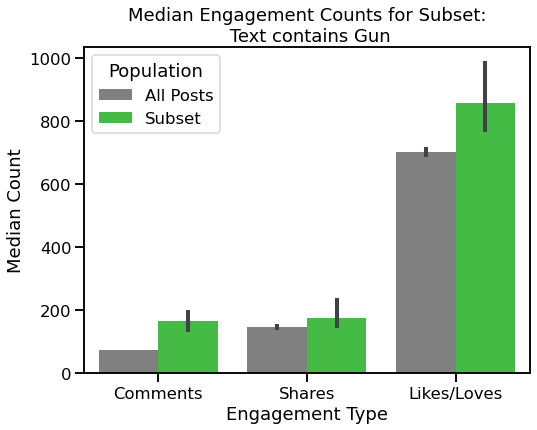

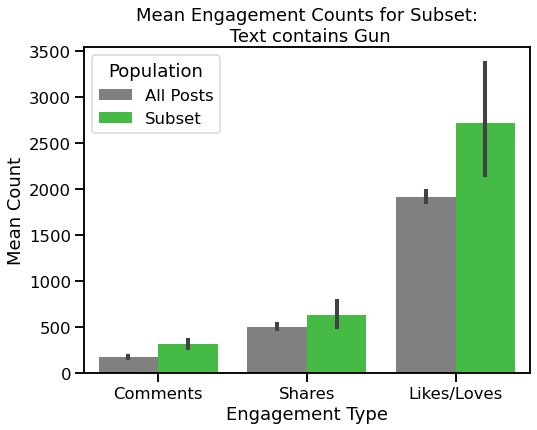

In [237]:
# posts containing gun
terms = ['gun']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Gun'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

Comments have the most significant increase over the general population; shares and likes/loves aren't significantly higher.

The topics are mostly on mass shootings and the gun control debate.

### White

Number of hits: 1140


Top engagement:



Least engagement:


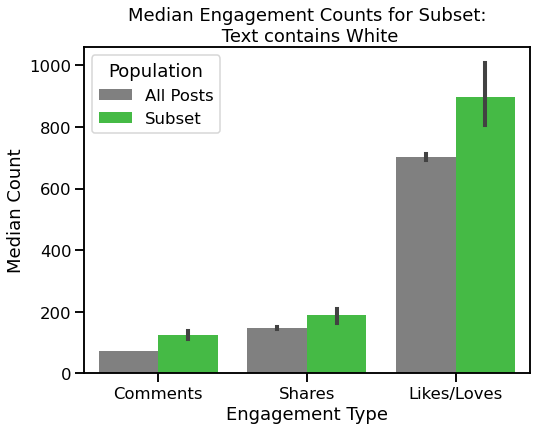

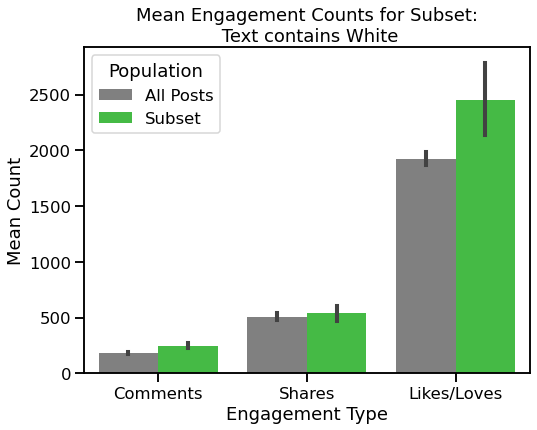

In [238]:
# posts containing recipe
terms = ['white']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains White'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

Some of these are about racial equity, but others are about the White House.

The engagement increase is most significant in likes/loves.

### Kids

Number of hits: 331


Top engagement:



Least engagement:


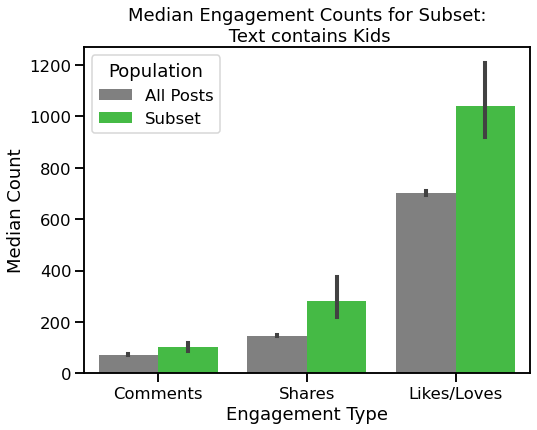

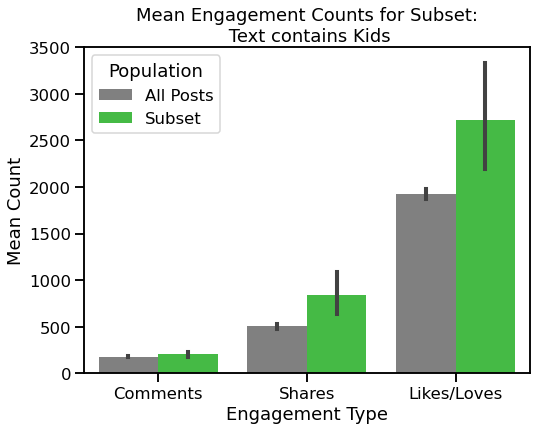

In [239]:
# posts containing kids
terms = ['kids']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Kids'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

- Video posts get significantly more comments, shares, and likes/loves.
- Photo posts get slightly more shares, and significantly more likes/loves.

### Obituaries


Top engagement:



Least engagement:


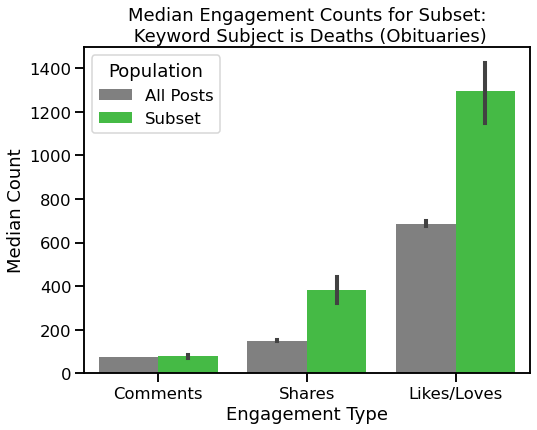

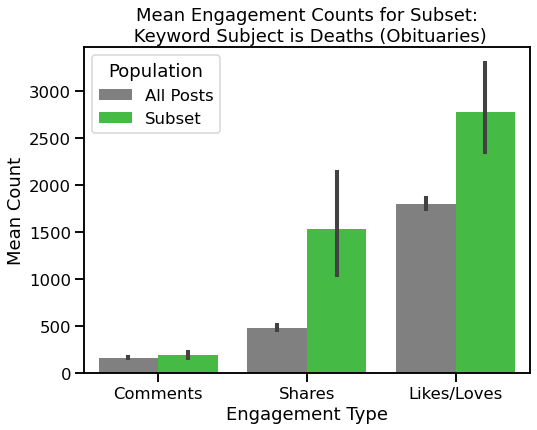

In [240]:
terms = ['deaths (obituaries)']

subset_title = 'Keyword Subject is Deaths (Obituaries)'

df_hits = plot_listmatches_vs_pop(df_articles, terms, subset_title, 
                           search_text_col='subject', 
                           full_text_col='article_text')

### Beauty


Top engagement:



Least engagement:


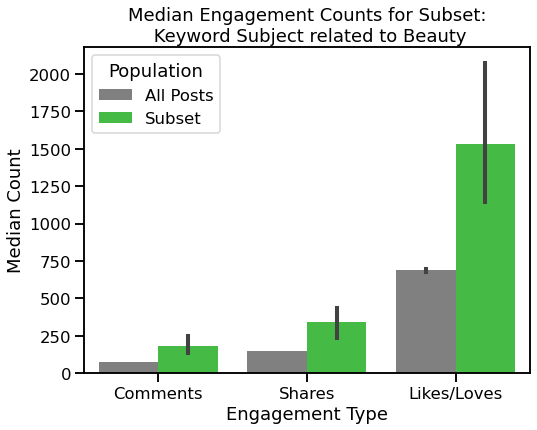

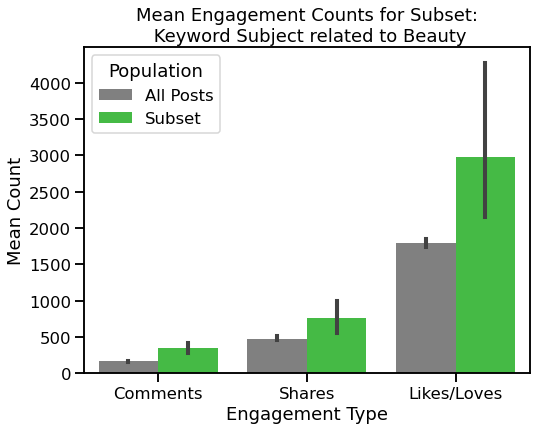

In [241]:
terms = ['beauty contests', 'hair', 'cosmetics and toiletries']

subset_title = 'Keyword Subject related to Beauty'

df_hits = plot_listmatches_vs_pop(df_articles, terms, subset_title, 
                           search_text_col='subject', 
                           full_text_col='article_text')

### Post Type

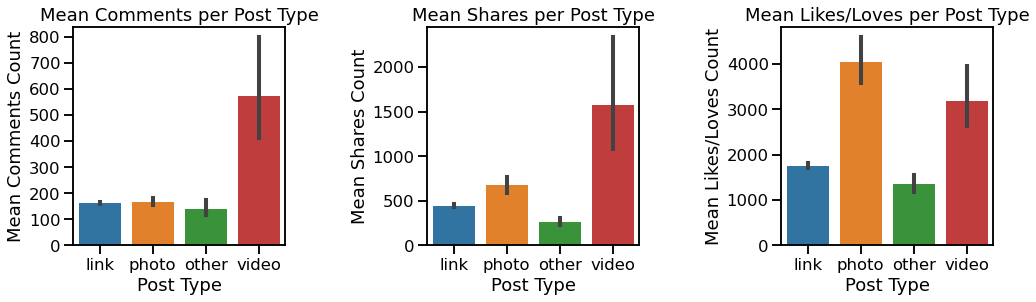

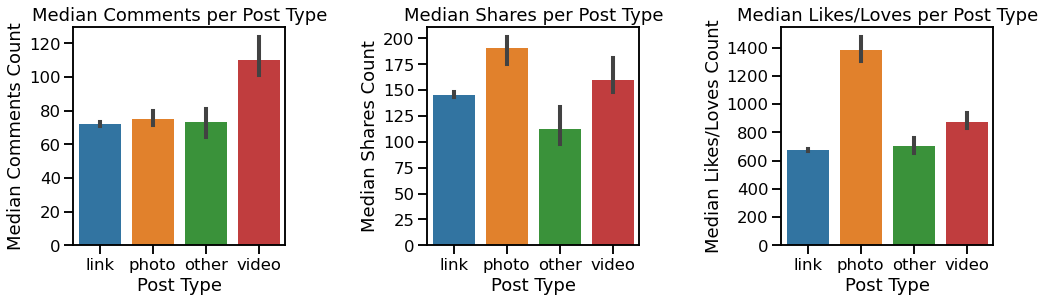

In [242]:
engage_dict = {'comments_count': "Comments", 'shares_count': 'Shares', 
                   'likes_loves': 'Likes/Loves'}
pred_col = 'post_type'
pred_label = 'Post Type'

with sns.plotting_context('talk'):

    fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=3)
    plt.tight_layout(pad=5)

    for i, target in enumerate(engage_dict.keys()):
        sns.barplot(data=df, y=target, x=pred_col, ax=axes[i], 
                    estimator=np.mean)
        axes[i].set_title(f"Mean {engage_dict[target]} per {pred_label}")
        axes[i].set_xlabel(pred_label)
        axes[i].set_ylabel(f"Mean {engage_dict[target]} Count");
        
    fig2, axes2 = plt.subplots(figsize=(16, 6), nrows=1, ncols=3)
    plt.tight_layout(pad=5)

    for i, target in enumerate(engage_dict.keys()):
        sns.barplot(data=df, y=target, x=pred_col, ax=axes2[i], 
                    estimator=np.median)
        axes2[i].set_title(f"Median {engage_dict[target]} per {pred_label}")
        axes2[i].set_xlabel(pred_label)
        axes2[i].set_ylabel(f"Median {engage_dict[target]} Count");

### Time of Day

In [243]:
# make categorical column
sorted_hours = list(df['hour_cat'].unique())
sorted_hours.sort()

cat_type = pd.api.types.CategoricalDtype(categories=sorted_hours, ordered=True)

df["hour_cat"] = df["hour_cat"].astype(cat_type)

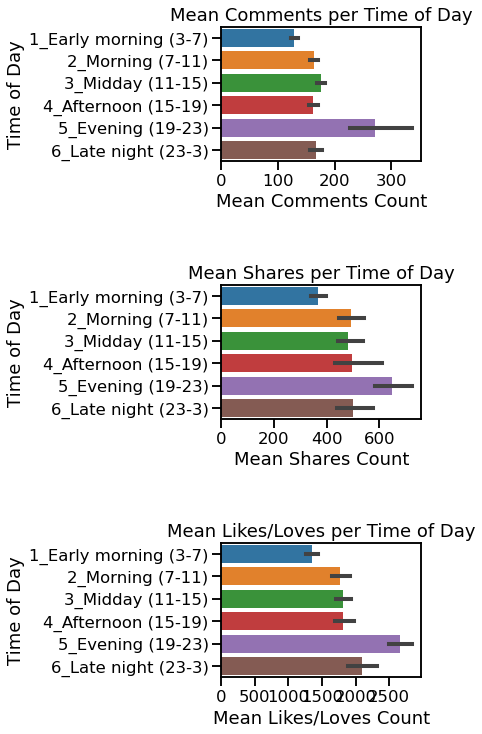

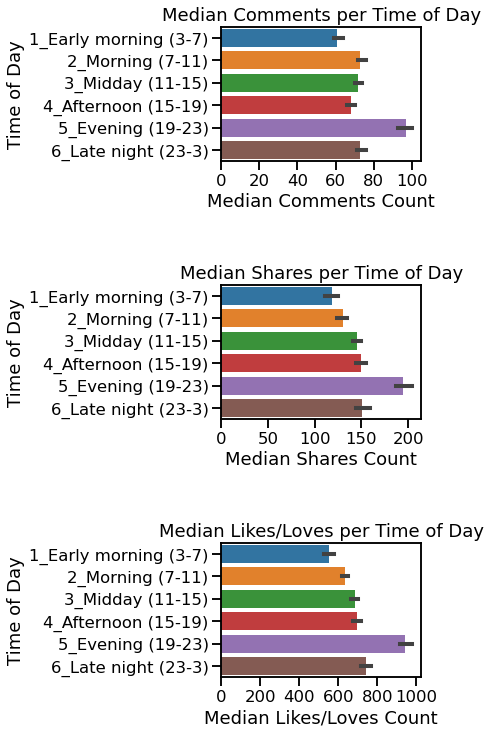

In [244]:
pred_col = 'hour_cat'
pred_label = 'Time of Day'

with sns.plotting_context('talk'):

    fig, axes = plt.subplots(figsize=(6, 12), nrows=3, ncols=1)
    plt.tight_layout(pad=5)

    for i, target in enumerate(engage_dict.keys()):
        sns.barplot(data=df, x=target, y=pred_col, ax=axes[i], 
                    estimator=np.mean)
        axes[i].set_title(f"Mean {engage_dict[target]} per {pred_label}")
        axes[i].set_ylabel(pred_label)
        axes[i].set_xlabel(f"Mean {engage_dict[target]} Count");
        #for tick in axes[i].get_ticklabels():
        #   tick.set_rotation(90);
        
    fig2, axes2 = plt.subplots(figsize=(6, 12), nrows=3, ncols=1)
    plt.tight_layout(pad=5)

    for i, target in enumerate(engage_dict.keys()):
        sns.barplot(data=df, x=target, y=pred_col, ax=axes2[i], 
                    estimator=np.median)
        axes2[i].set_title(f"Median {engage_dict[target]} per {pred_label}")
        axes2[i].set_ylabel(pred_label)
        axes2[i].set_xlabel(f"Median {engage_dict[target]} Count");
        #for tick in axes2[i].get_xticklabels():
        #    tick.set_rotation(90);

### Weekend

In [245]:
weekend_dict = {0:'Weekday', 1:'Weekend'}
df['on_weekend_plot'] = df['on_weekend'].map(lambda x: weekend_dict[x])

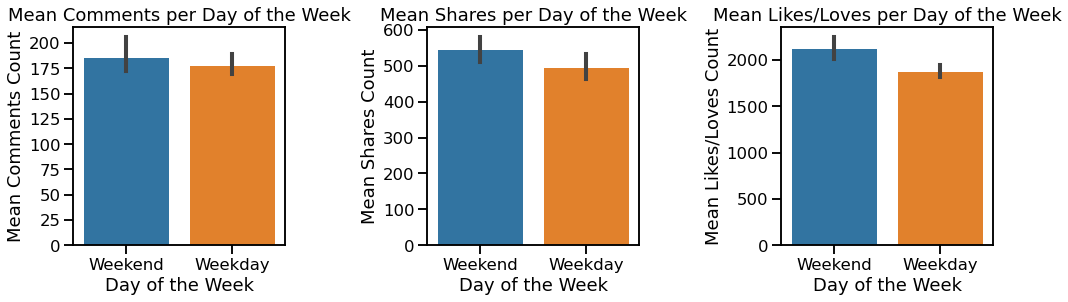

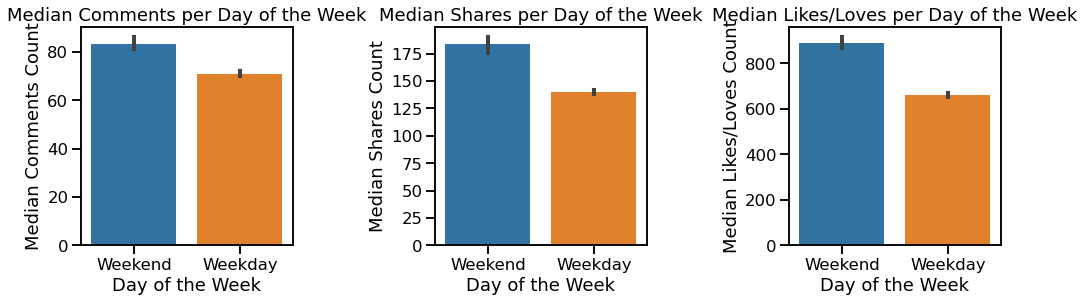

In [246]:
pred_col = 'on_weekend_plot'
pred_label = 'Day of the Week'

with sns.plotting_context('talk'):

    fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=3)
    plt.tight_layout(pad=5)

    for i, target in enumerate(engage_dict.keys()):
        sns.barplot(data=df, y=target, x=pred_col, ax=axes[i], 
                    estimator=np.mean)
        axes[i].set_title(f"Mean {engage_dict[target]} per {pred_label}")
        axes[i].set_xlabel(pred_label)
        axes[i].set_ylabel(f"Mean {engage_dict[target]} Count");
        
    fig2, axes2 = plt.subplots(figsize=(16, 6), nrows=1, ncols=3)
    plt.tight_layout(pad=5)

    for i, target in enumerate(engage_dict.keys()):
        sns.barplot(data=df, y=target, x=pred_col, ax=axes2[i], 
                    estimator=np.median)
        axes2[i].set_title(f"Median {engage_dict[target]} per {pred_label}")
        axes2[i].set_xlabel(pred_label)
        axes2[i].set_ylabel(f"Median {engage_dict[target]} Count");

## Explore Top Predictors of Low Engagement

### Ethics and Op-Ed

Number of hits: 752


Top engagement:



Least engagement:


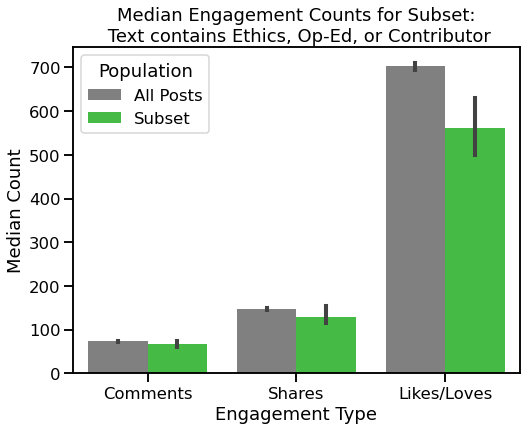

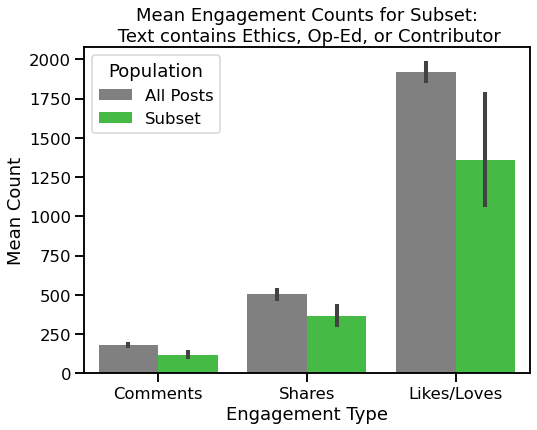

In [247]:
# posts containing Ethics and Op-Ed
terms = ['ethics', 'ethicist', 'op-ed', 'contributor']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Ethics, Op-Ed, or Contributor'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Quotation of the Day

Number of hits: 1085


Top engagement:



Least engagement:


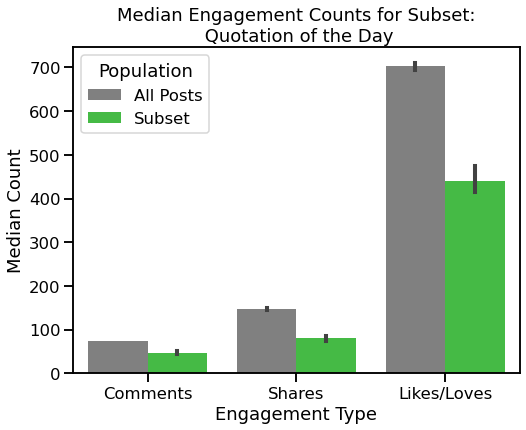

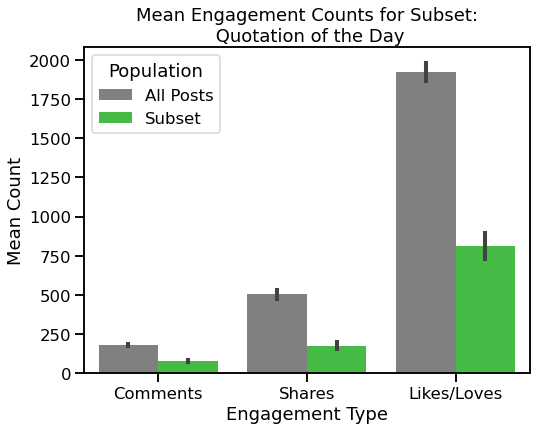

In [248]:
terms = ['quotation of the day', 'quote of the day', 'quote']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Quotation of the Day'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Daily Briefing

Number of hits: 188


Top engagement:



Least engagement:


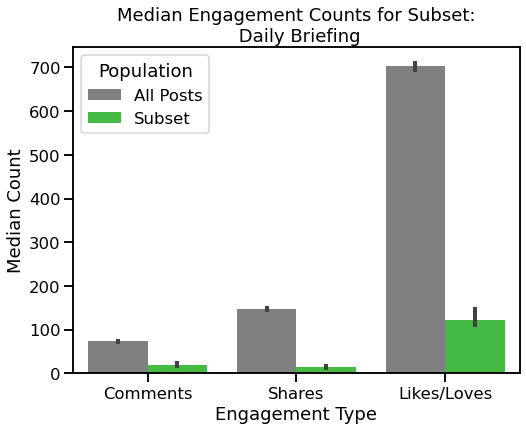

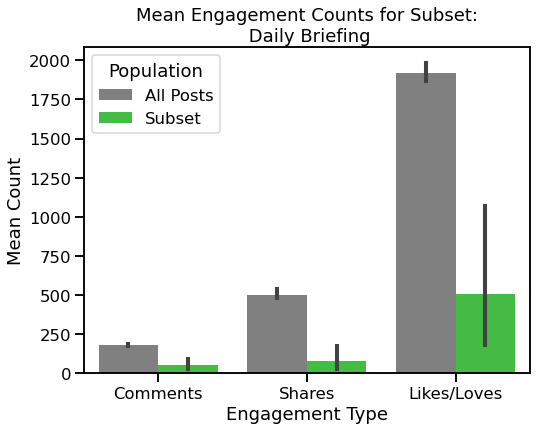

In [249]:
terms = ["daily briefing", "here's what you need to know to start your day",
        'briefing']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Daily Briefing"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Week

Number of hits: 1712


Top engagement:



Least engagement:


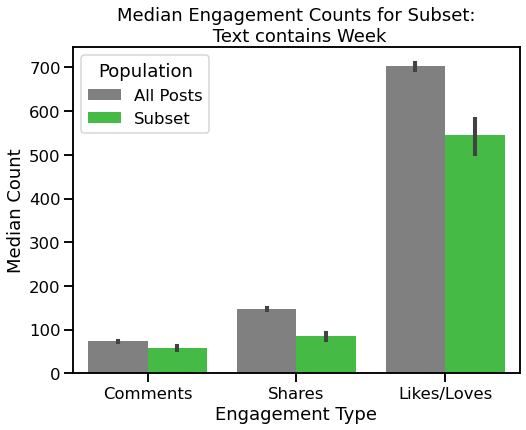

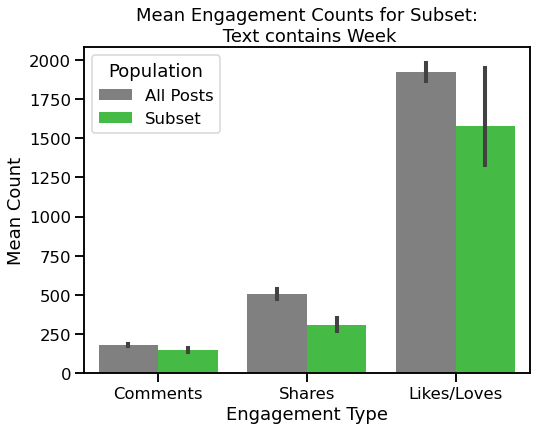

In [250]:
terms = ["week"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Week"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

Number of hits: 71


Top engagement:



Least engagement:


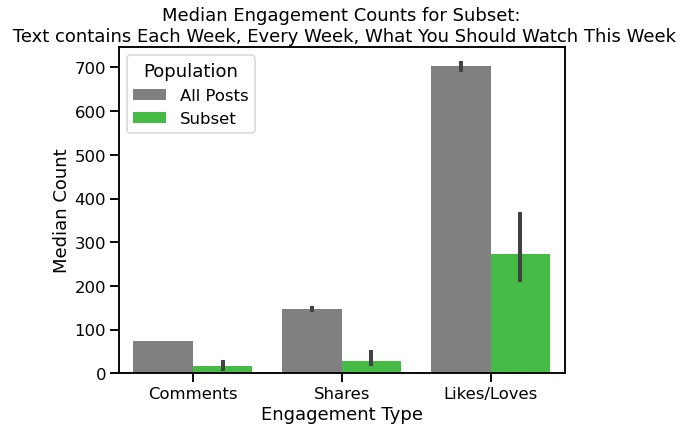

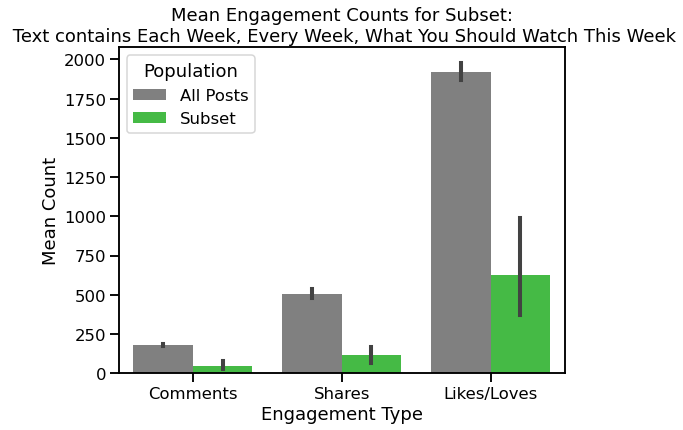

In [251]:
terms = ["each week", "every week", "what you should watch this week"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Each Week, Every Week, What You Should Watch This Week"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

In [252]:
df.loc[(df['cleaned'].str.contains('week', regex=False, case=False)),
      'name'].value_counts()[:30]

Timeline Photos                                            131
The New York Times Styles                                   30
Video From The New York Times                               25
Press Play                                                  15
What You Should Watch This Weekend                          12
What We're Reading                                          11
What You Should Watch This Week                              9
Do You Live Near I-35? Contribute to Our Reporting           8
The New York Times Food                                      7
Photos from The New York Times's post                        7
What to Cook This Week                                       7
The New York Times - Well - Health                           6
The New York Times - Science                                 4
The New York Times - Lens - Photography                      4
36 Hours in Madrid                                           4
Fashion Week Now Spring 2015                           

Number of hits: 49


Top engagement:



Least engagement:


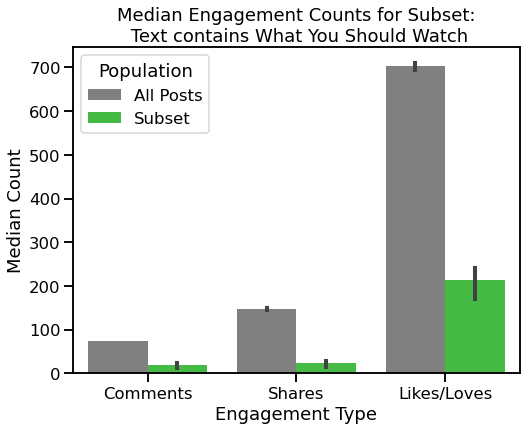

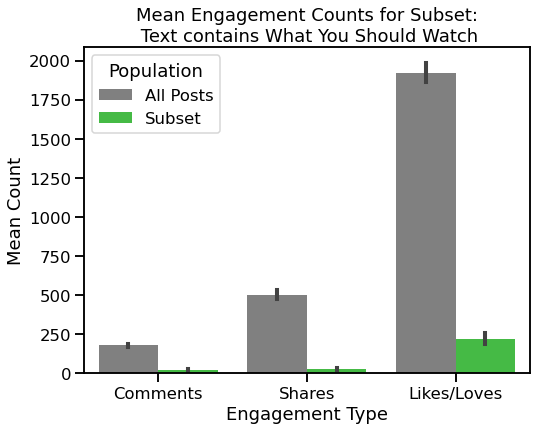

In [253]:
terms = ["what you should watch"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains What You Should Watch"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### New York Today

Number of hits: 8111


Top engagement:



Least engagement:


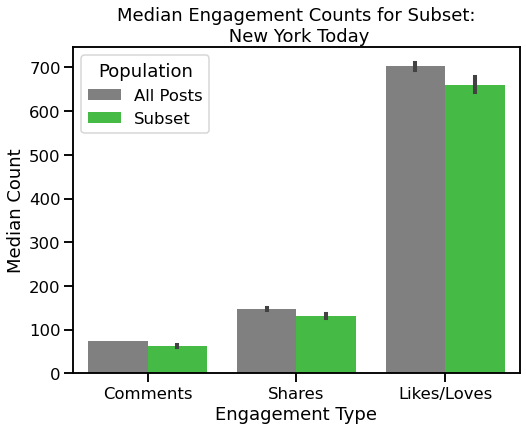

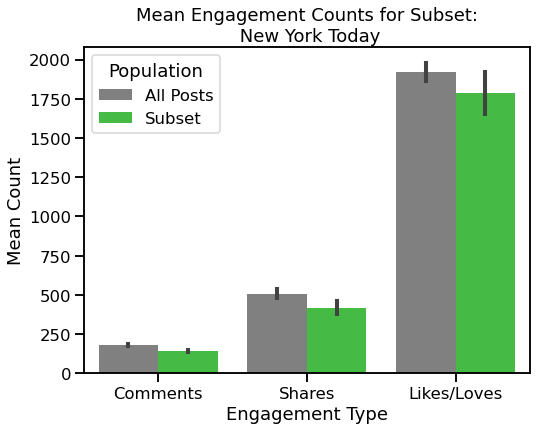

In [254]:
terms = ["new york today", 'new']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "New York Today"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Moments

Number of hits: 279


Top engagement:



Least engagement:


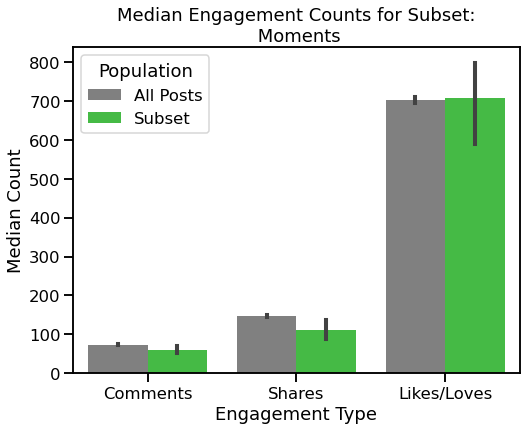

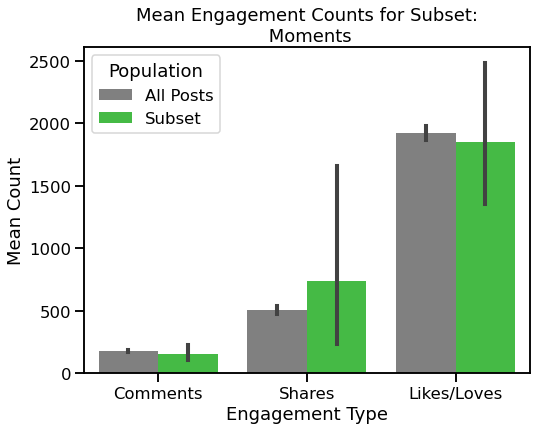

In [255]:
terms = ["moments"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Moments"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Collection

Number of hits: 227


Top engagement:



Least engagement:


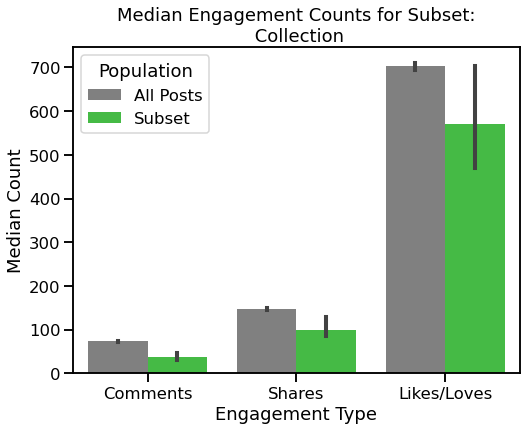

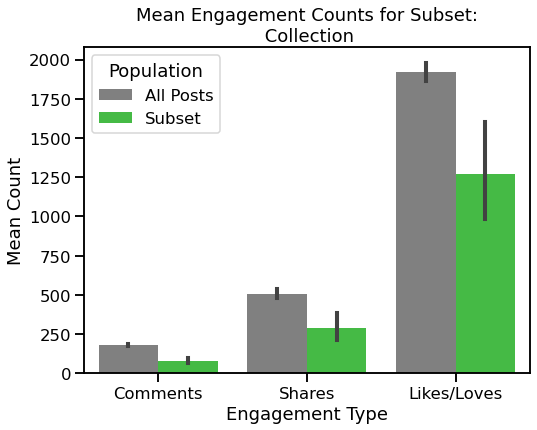

In [256]:
terms = ["collection"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Collection"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Question mark

Number of hits: 8245


Top engagement:



Least engagement:


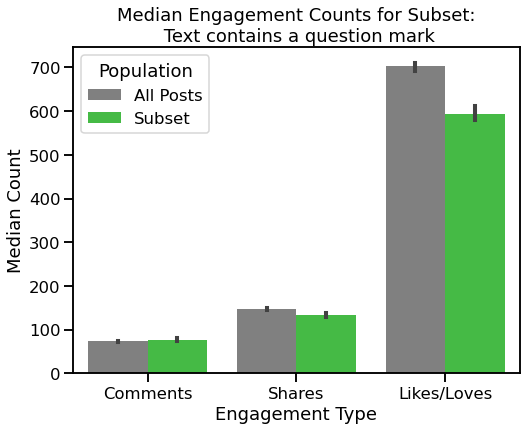

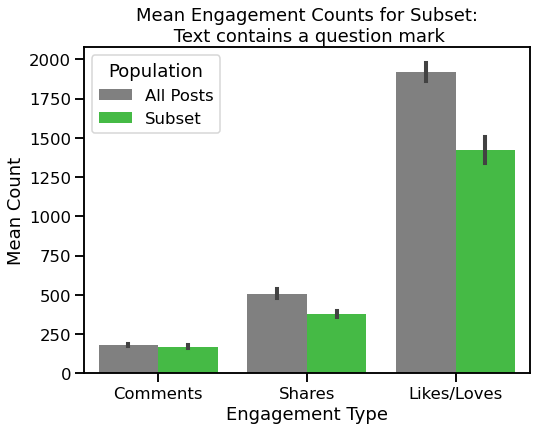

In [257]:
re_string = "[?]"

subset_title = "Text contains a question mark"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Here's what you need to know

Number of hits: 471


Top engagement:



Least engagement:


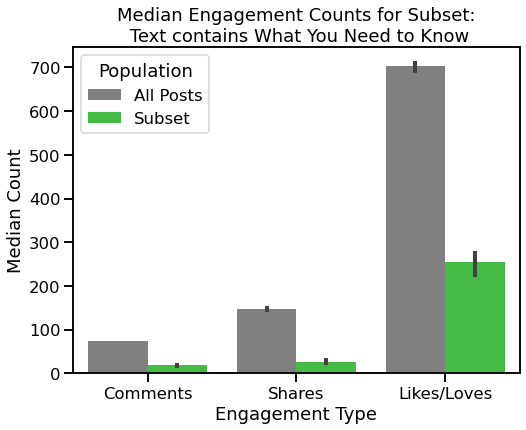

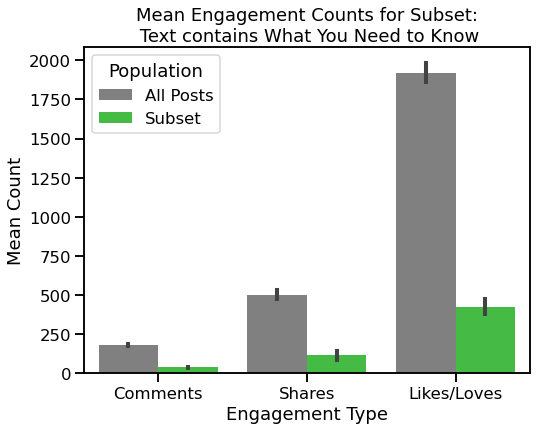

In [258]:
terms = ["what you need to know"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains What You Need to Know"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Ebola

Number of hits: 436


Top engagement:



Least engagement:


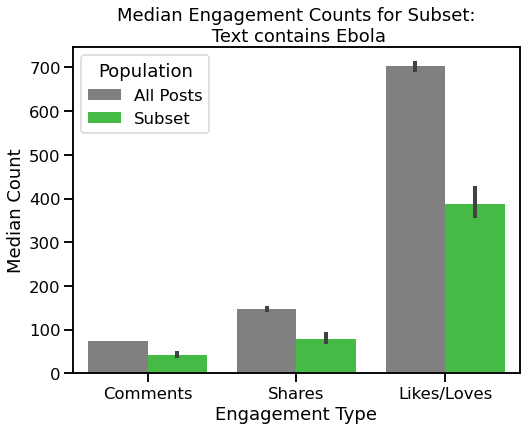

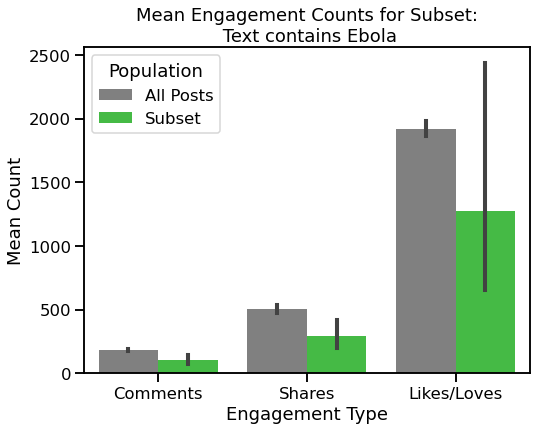

In [259]:
terms = ["ebola"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Ebola"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### General Government and Politics

Number of hits: 5428


Top engagement:



Least engagement:


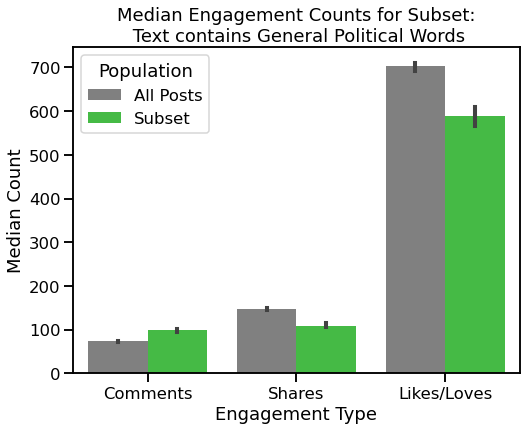

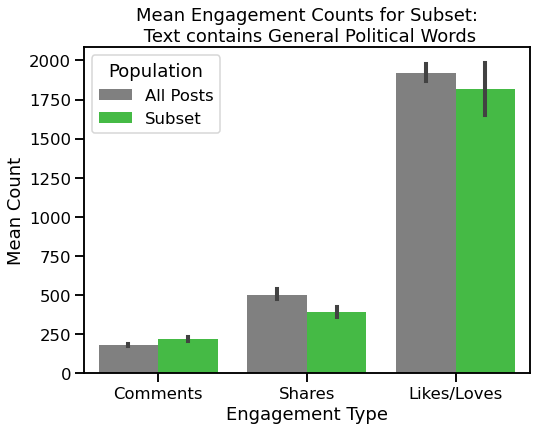

In [260]:
terms = ["government", 'political', 'politics', 'voters', 'polls', 
         'washington', 'bush', 'senate', 'campaign', 'elections']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains General Political Words"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)


Top engagement:



Least engagement:


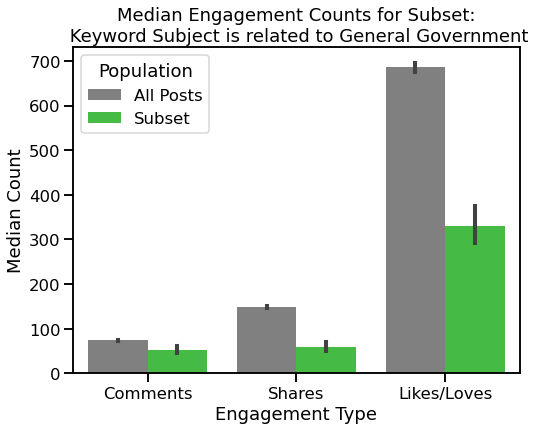

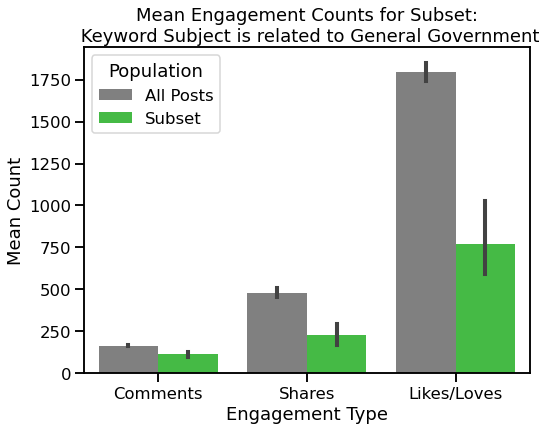

In [261]:
terms = ['midterm elections (2014)', 'politics and government', 'jury system',
        'political action commitees', 'third-party politics (us)']

subset_title = 'Keyword Subject is related to General Government'

df_hits = plot_listmatches_vs_pop(df_articles, terms, subset_title, 
                           search_text_col='subject', 
                           full_text_col='article_text')

### Fashion

Number of hits: 568


Top engagement:



Least engagement:


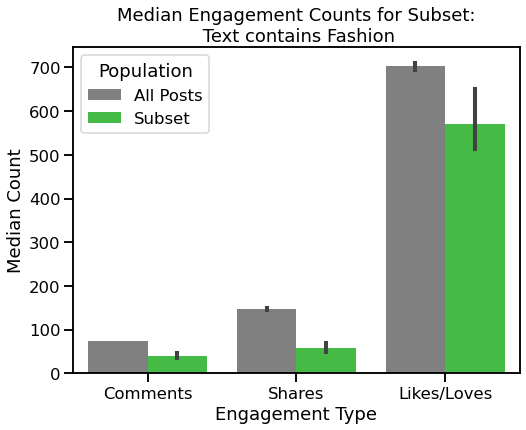

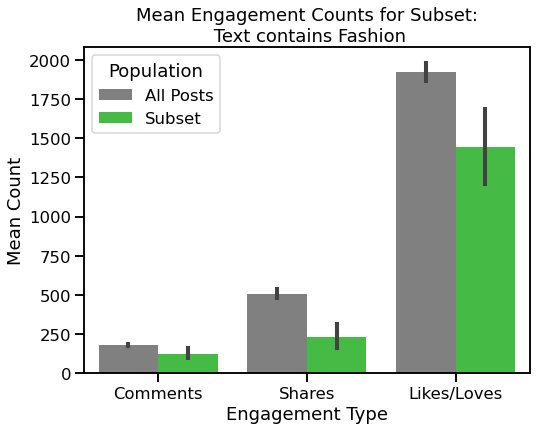

In [262]:
terms = ['fashion' ]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Fashion"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Sports

Number of hits: 718


Top engagement:



Least engagement:


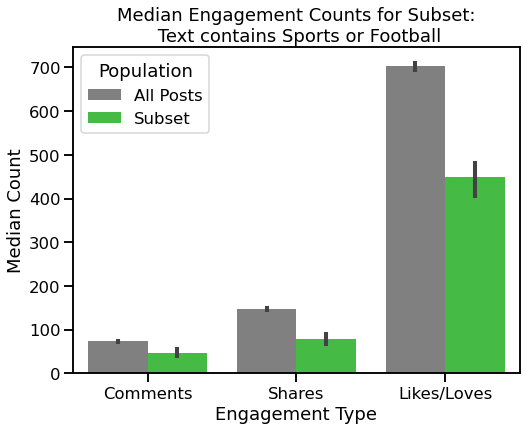

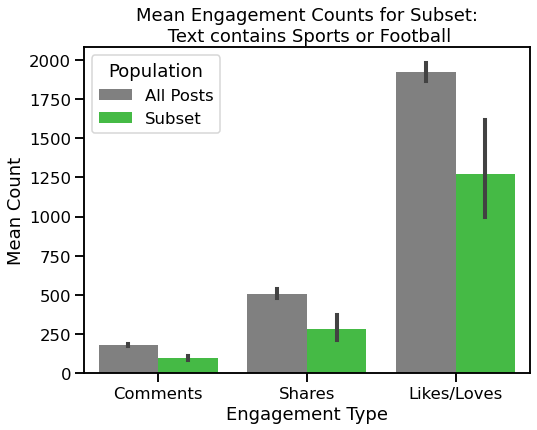

In [263]:
terms = ['sports', 'football' ]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Sports or Football"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)


Top engagement:



Least engagement:


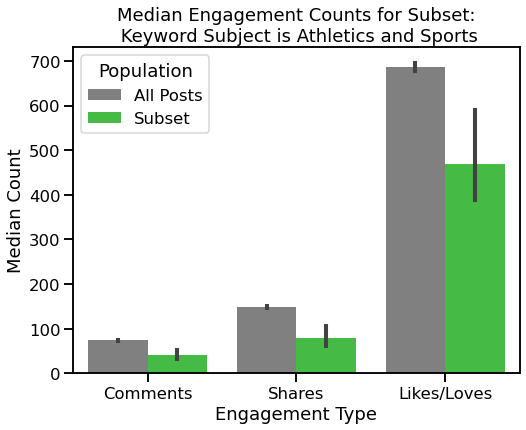

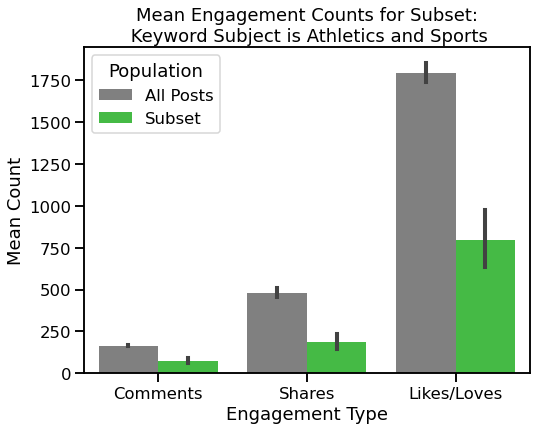

In [264]:
terms = ['athletics and sports']

subset_title = 'Keyword Subject is Athletics and Sports'

df_hits = plot_listmatches_vs_pop(df_articles, terms, subset_title, 
                           search_text_col='subject', 
                           full_text_col='article_text')

Some of these are about protecting kids (from gun violence, from Trump as president), but most are actually on the topic of raising kids.

Likes/loves and shares have the most significant elevation in engagement.

In [265]:
high_eng.head(25)

Formatted Feature         Feature  Odds of High Engagement       std   min  \
0      breaking news   breaking news                    9.510  0.333833  8.91   
1           breaking        breaking                    6.860  0.336221  6.21   
2     writes opinion  writes opinion                    3.771  0.188411  3.41   
3             recipe          recipe                    3.520  0.167664  3.26   
4       read opinion    read opinion                    3.314  0.130486  3.15   
5              trump           trump                    3.141  0.177667  2.90   
6              white           white                    2.929  0.156379  2.68   
7             donald          donald                    2.910  0.043461  2.82   
8              women           women                    2.796  0.140174  2.53   
9               news            news                    2.785  0.150794  2.50   
10            bernie          bernie                    2.641  0.100714  2.49   
11           sanders         sanders                    2.444  0.088217  2.27   
12             obama           obama                    2.442  0.092592  2.32   
13               gun             gun                    2.367  0.082199  2.18   
14             happy           happy                    2.325  0.135175  2.12   
15              kids            kids                    2.322  0.161369  2.16   
16            muslim          muslim                    2.300  0.115374  2.07   
17              dies            dies                    2.263  0.141661  2.06   
18               boy             boy                    2.190  0.141814  1.97   
19           trump's         trump's                    2.188  0.086255  2.02   
20    bernie sanders  bernie sanders                    2.176  0.064153  2.04   
21             hours           hours                    2.165  0.125808  1.99   
22           muslims         muslims                    2.149  0.098257  2.03   
23            coffee          coffee                    2.115  0.102008  2.01   
24             wrote           wrote                    2.073  0.108120  1.92   

     max  count  std_error  conf_min  
0   9.94   10.0   0.105567  9.298865  
1   7.36   10.0   0.106322  6.647355  
2   4.01   10.0   0.059581  3.651838  
3   3.85   10.0   0.053020  3.413960  
4   3.60   10.0   0.041263  3.231473  
5   3.42   10.0   0.056183  3.028634  
6   3.15   10.0   0.049451  2.830097  
7   2.96   10.0   0.013744  2.882513  
8   2.96   10.0   0.044327  2.707346  
9   2.99   10.0   0.047685  2.689629  
10  2.79   10.0   0.031849  2.577303  
11  2.55   10.0   0.027897  2.388207  
12  2.63   10.0   0.029280  2.383439  
13  2.47   10.0   0.025994  2.315013  
14  2.56   10.0   0.042746  2.239508  
15  2.72   10.0   0.051029  2.219941  
16  2.46   10.0   0.036484  2.227031  
17  2.49   10.0   0.044797  2.173406  
18  2.38   10.0   0.044845  2.100309  
19  2.30   10.0   0.027276  2.133447  
20  2.25   10.0   0.020287  2.135426  
21  2.34   10.0   0.039784  2.085432  
22  2.30   10.0   0.031072  2.086857  
23  2.30   10.0   0.032258  2.050485  
24  2.27   10.0   0.034191  2.004619

### Video or Watch

Number of hits: 987


Top engagement:



Least engagement:


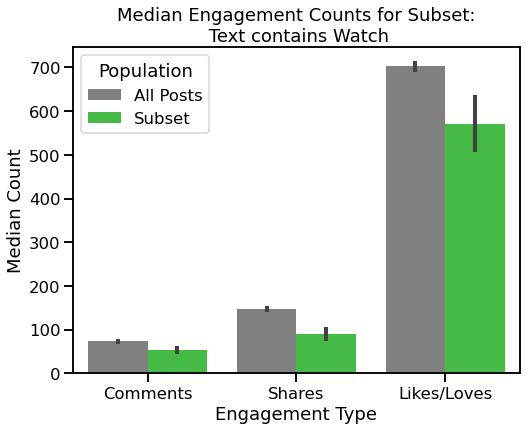

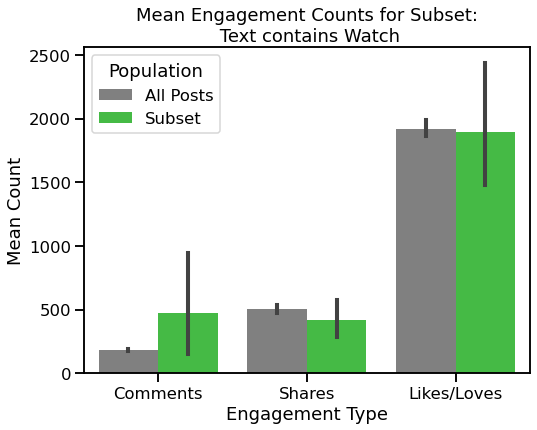

In [266]:
terms = ['watch' ]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Watch"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

Number of hits: 2253


Top engagement:



Least engagement:


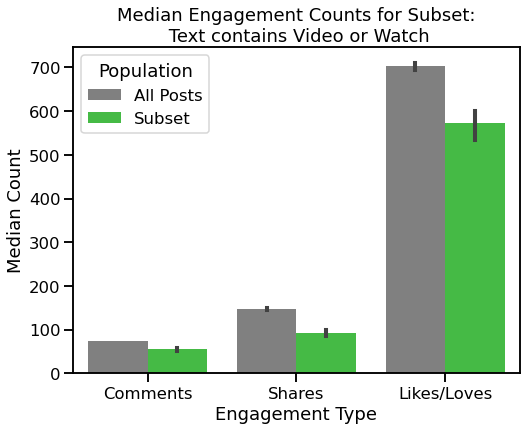

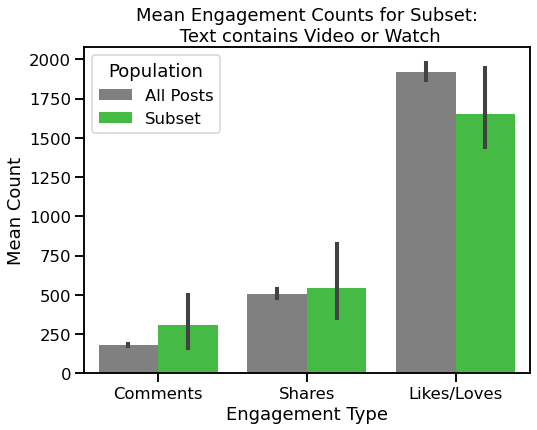

In [267]:
terms = ['video', 'watch' ]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Video or Watch"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

# CONCLUSIONS & RECOMMENDATIONS

To finalize my conclusions, I exported the top 300 high and low word features, top 300 high and low subject features, and all categorical features to Excel, and performed a manual categorization exercise. Not every word and subject was ultimately assigned a categories, but where they stood out clearly, I assigned them.

In [276]:
# import categorized features from Excel
df_results = pd.read_excel('data/Results.xlsx', sheet_name='New Categories')

df_results['Category'].value_counts()

General Politics and Government        36
Modern Tech                            35
Food, Cooking, and Recipes             34
Minority Groups and Social Equality    32
Crime and Justice                      32
                                       ..
Aging                                   3
Breaking News                           2
Farming and Agriculture                 2
Generations                             2
Social Issues                           2
Name: Category, Length: 71, dtype: int64

In [277]:
timing_dict = {'hour_cat_3_Midday (11-15)': 'Posted Midday (11 AM to 3 PM ET)', 
'hour_cat_4_Afternoon (15-19)': 'Posted Afternoon (3 PM  to 7 PM ET)', 
'hour_cat_2_Morning (7-11)': 'Posted Morning (7 AM to 11 AM ET)', 
'hour_cat_5_Evening (19-23)': 'Posted Evening (7 PM to 11 PM ET)', 
'hour_cat_6_Late night (23-3)': 'Posted Late Night (11 PM to 3 AM ET)', 
'hour_cat_1_Early morning (3-7)': 'Posted Early Morning (3 AM to 7 AM ET)'}

def format_featurenames(x):
    """Formats the feature names currently using OHE column prefixes,
    and makes them nicer looking for viz.
    """
    from textwrap import wrap
    
    if x.startswith("sub_"):
        x = '(Subject) ' + x.replace("sub_", "").title()
    elif x.startswith("section_name_"):
        x = '(Section Name) ' + x.replace("section_name_", "").title()
    elif x.startswith("post_type_"):
        x = '(Post Type) ' + x.replace("post_type_", "").title()
    elif x.startswith("hour_cat_"):
        x = timing_dict[x]
    elif x == 'on_weekend_1.0':
        x = 'Posted on Weekend Day'
        
    x = '\n'.join(wrap(x, 40))
    
    return x


# Format section feature names better
df_results['Formatted Feature'] = df_results['Feature']\
        .map(lambda x: format_featurenames(x))


In [278]:
# Add/Subtract 1 from  odds ratios
df_results[high_label] = df_results[high_label]\
        .map(lambda x: x - 1 if x > 1 else x + 1)


## Prioritize Presidential Topics over General Politics

- Content related to the 2016 presidential election and the current sitting president generally get high engagement.
- Content related to politics in general, however, tend to get lower engagement

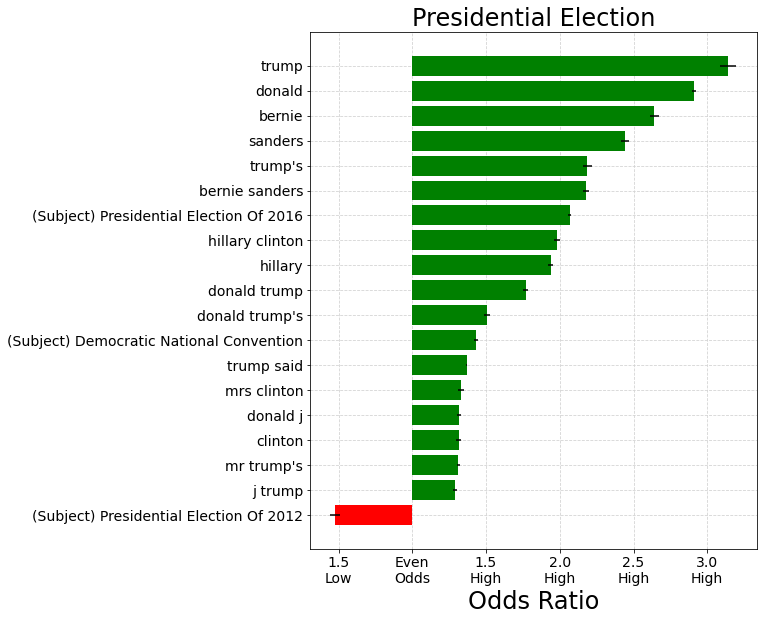

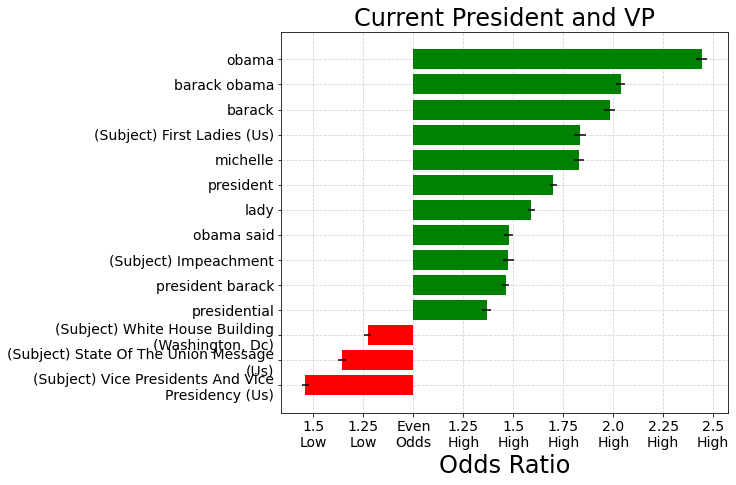

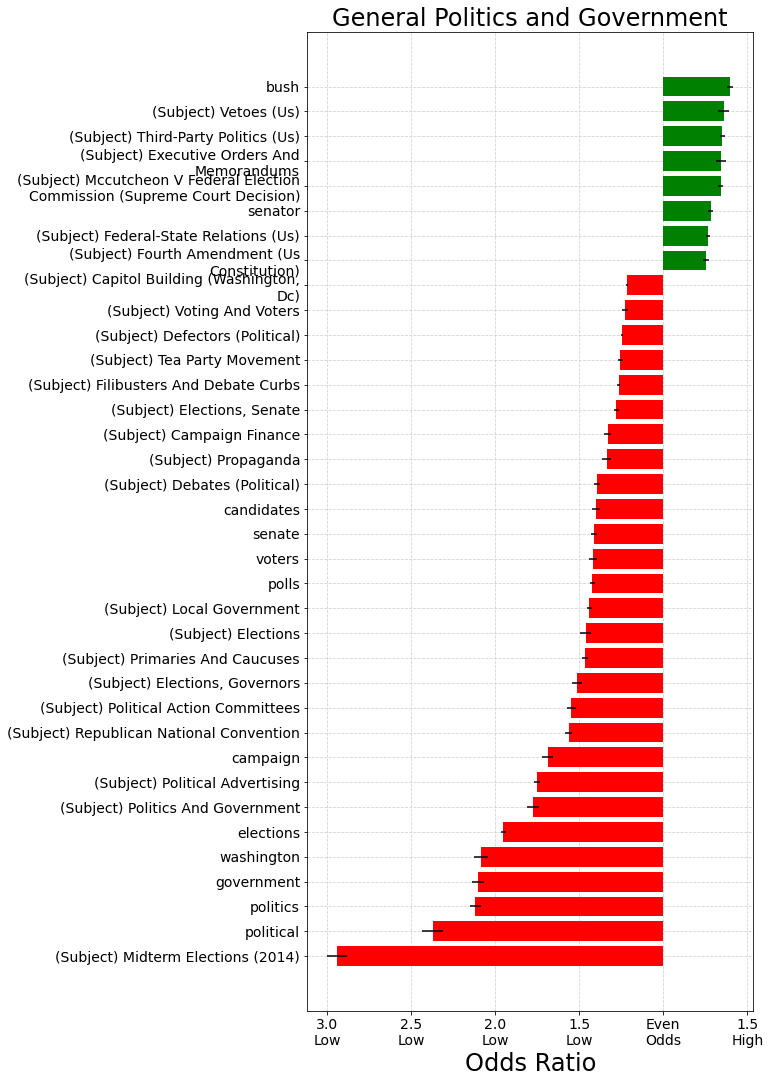

In [280]:
for cat in ['Presidential Election', 'Current President and VP',
            'General Politics and Government']:

    plot_topfeatures_w_se(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'std_error', pos_neg=True)

## Prioritize Breaking News over Recurring Content

- Breaking news is one of the top predictors of high engagement
- Conversely, regular or recurring features typically get low engagement. Examples include "Quotation of the Day", "New York Today", "Daily Briefing".

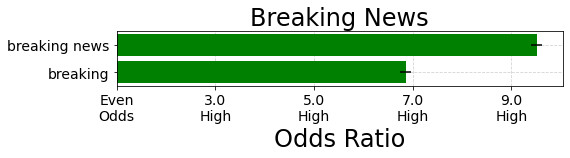

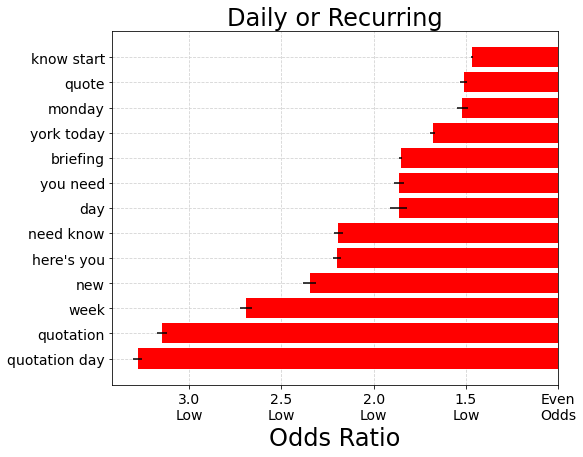

In [281]:
for cat in ['Breaking News', 'Daily or Recurring']:

    plot_topfeatures_w_se(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'std_error', pos_neg=True)

## Prioritize U.S. National Content over Local or Foreign

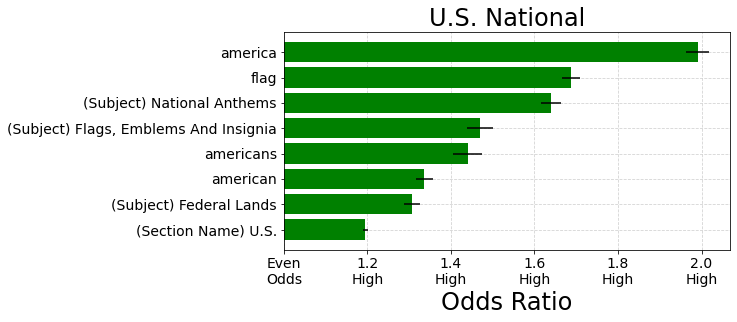

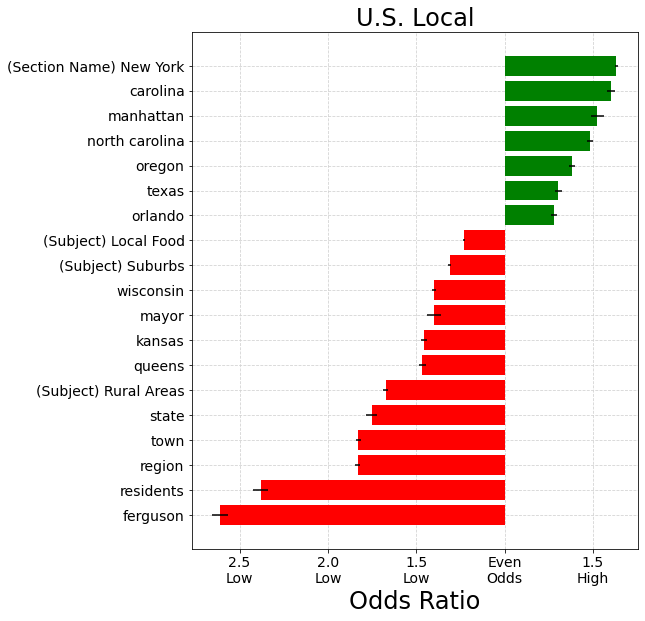

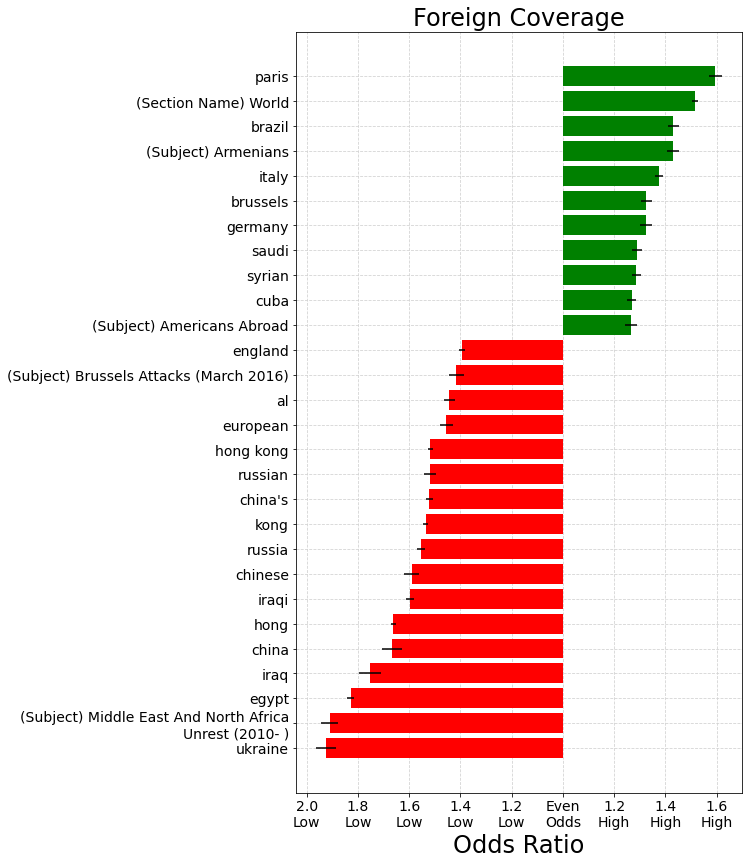

In [282]:
for cat in ['U.S. National', 'U.S. Local', 'Foreign Coverage']:

    plot_topfeatures_w_se(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'std_error', pos_neg=True)

## Controversial Topics can be Highly Engaging (but it depends)

- Gender and religious topics seem to get more engagement than race and sexuality
- Gun topics are generally higher engagement, but vary widely.
- Immigration and refugee coverage tend to get less engagement.

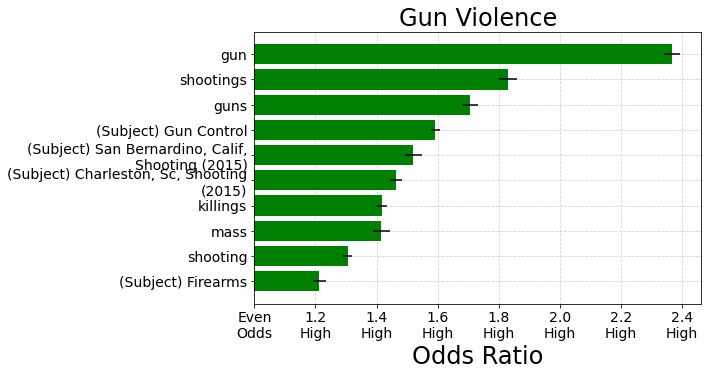

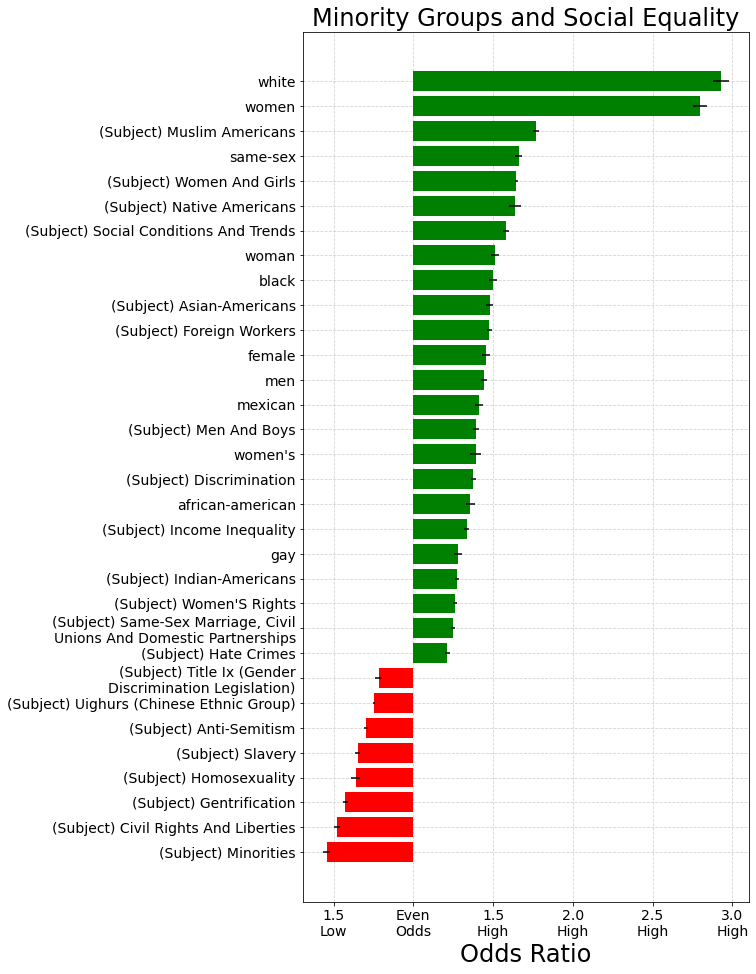

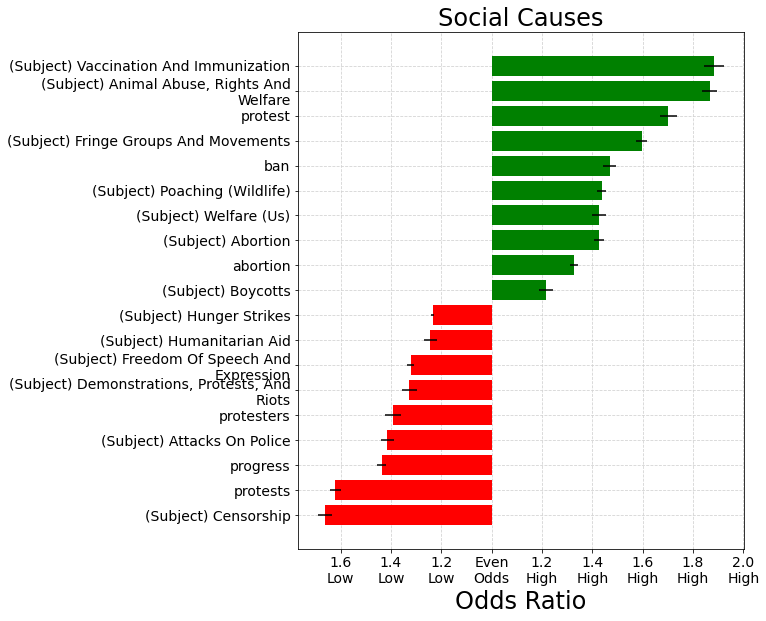

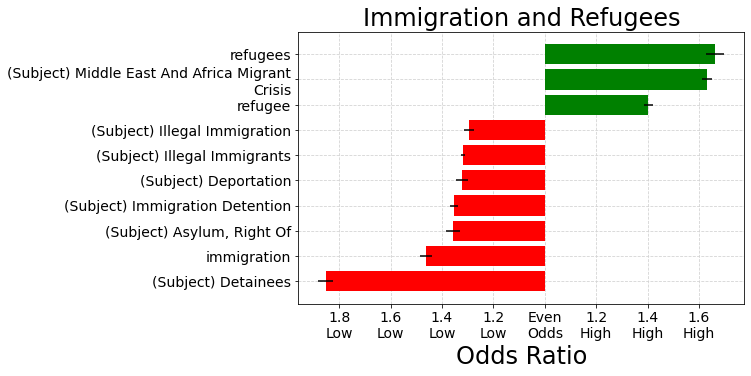

In [283]:
for cat in ['Gun Violence', 'Minority Groups and Social Equality',
           'Social Causes', 'Immigration and Refugees']:

    plot_topfeatures_w_se(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'std_error', pos_neg=True)

## Post content outside the paywall

- Posts added as videos or photos uploaded to Facebook instead of links (or added to the Facebook Timeline) get more engagement than posts that have the words "watch" or "video" in them but are posted as links back to the Times' site. I think this is likely because links to the site will often be behind the paywall.

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/matplotlib/patches.py:781: RuntimeWarning: invalid value encountered in double_scalars
  self._y1 = self._y0 + self._height
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/matplotlib/transforms.py:1978: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


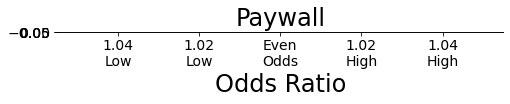

In [284]:
for cat in ['No Paywall']:

    plot_topfeatures_w_se(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   "Paywall", 'std_error', pos_neg=True)

### Video Posts

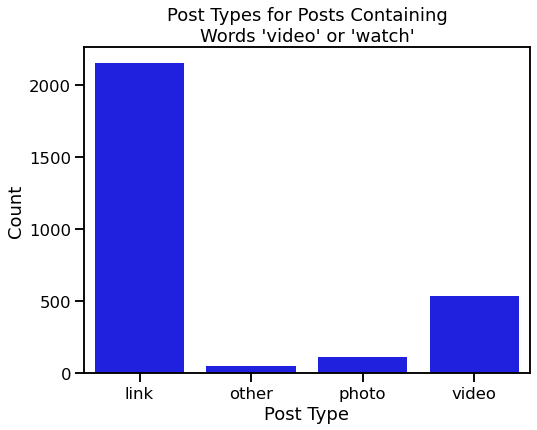

In [285]:
df_vid = df.loc[(df['cleaned'].str.contains('video', regex=False, case=False)) | 
      (df['cleaned'].str.contains('watch', regex=False, case=False))]

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(8, 6))

    sns.countplot(data=df_vid, x='post_type', ax=ax, color='blue')
    ax.set_title("Post Types for Posts Containing\nWords 'video' or 'watch'")
    ax.set_xlabel('Post Type')
    ax.set_ylabel('Count')

    ;

OK so only 18% of posts that contain the word "video" or "watch" were actually posted as videos; 75% were posted as links.

Video posts are more popular, but it makes sense why the top predictors of average included the words "watch" and "video".

## Tell More than you Ask

- When posts use words related to what people have said, these get high engagement. It seems like people like hearing others' words directly.
- However, posts that include words where the Times seems to be asking questions of readers seem to get less engagement.

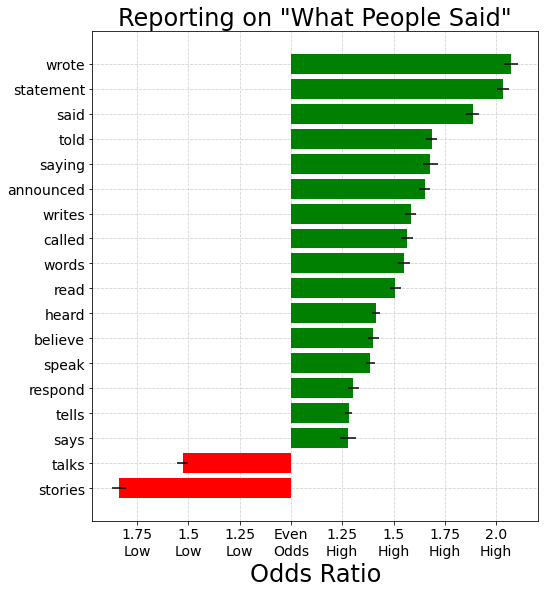

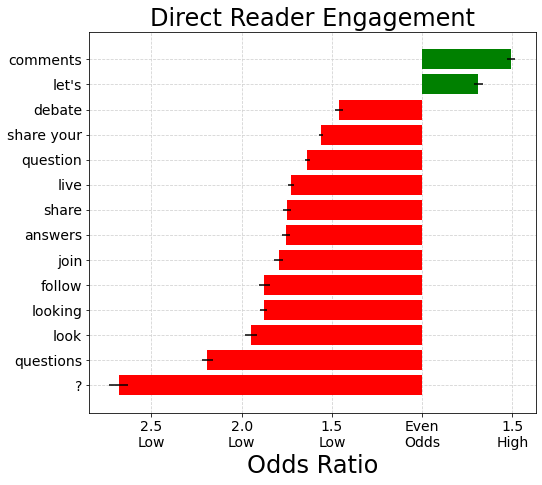

In [286]:
for cat in ['Reporting on "What People Said"', 'Direct Reader Engagement']:

    plot_topfeatures_w_se(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'std_error', pos_neg=True)

## Popular Topics to Prioritize:

- Opinion and Editorial Board (Ethics and Op-Ed get less engagement)
- Parenting and Children
- Recipes and Cooking
- Diet and Nutrition
- Obituaries
- Mental Health
- Beauty and Self Care
- Exercise
- Marriage and Relationships
- Religion

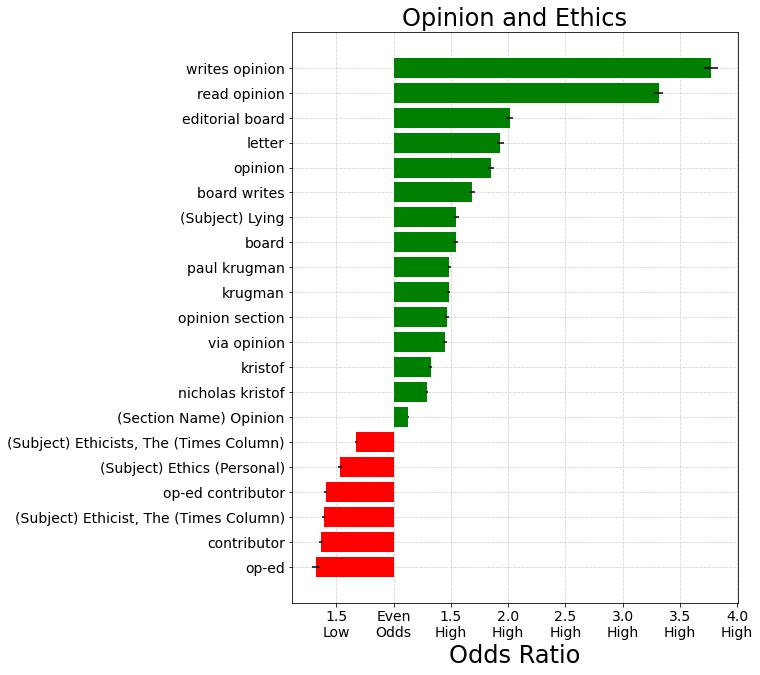

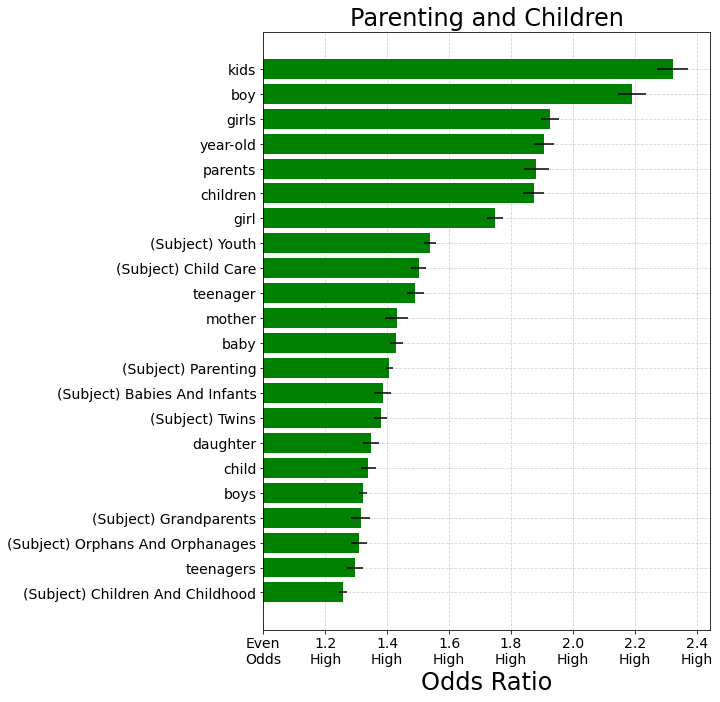

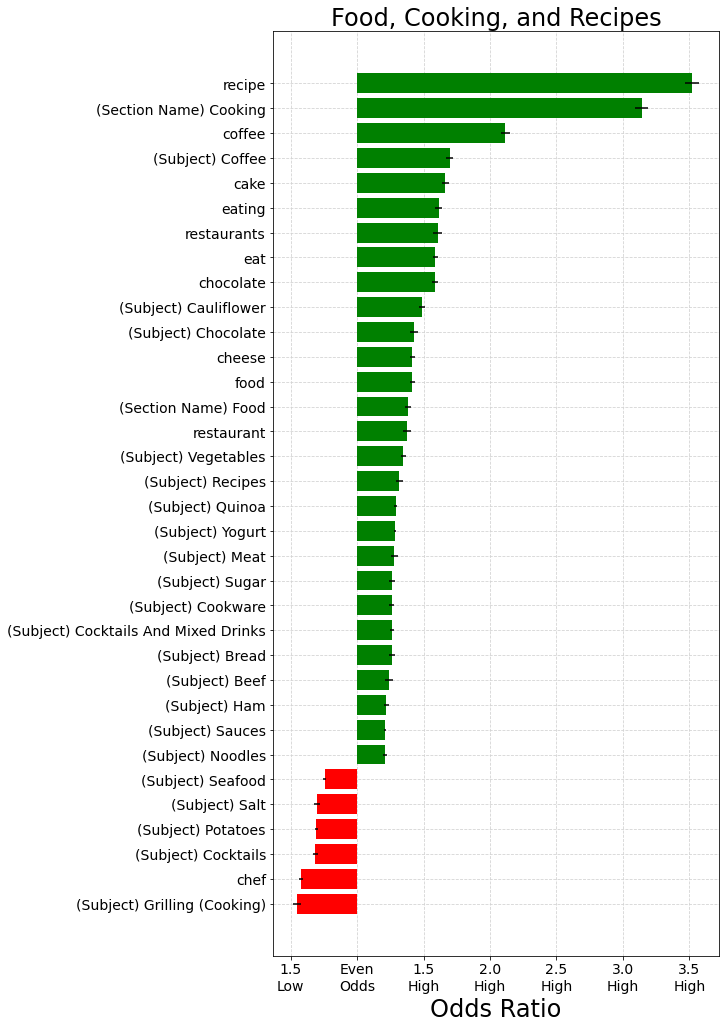

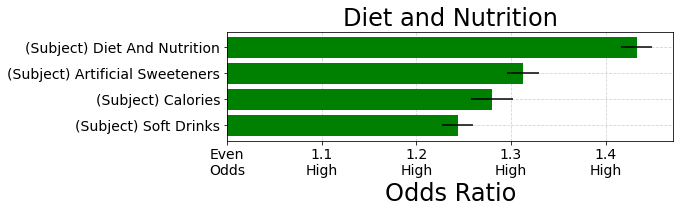

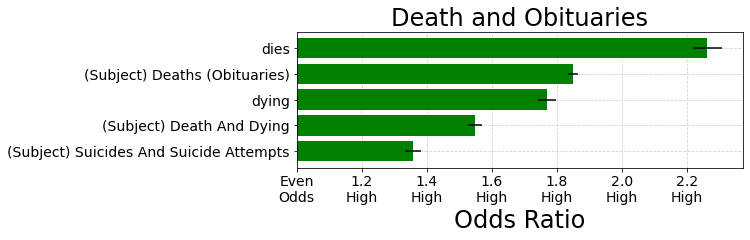

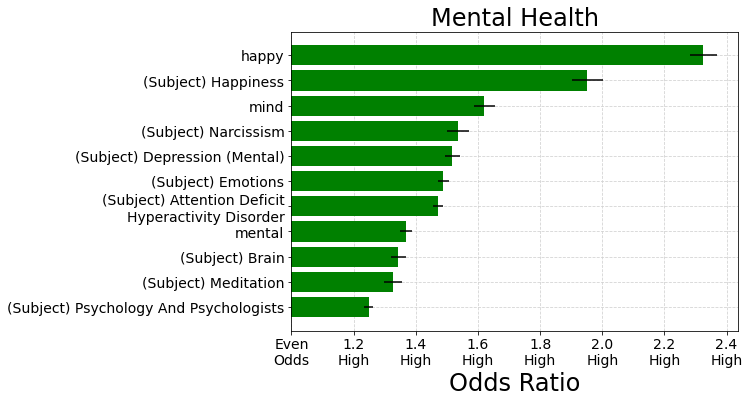

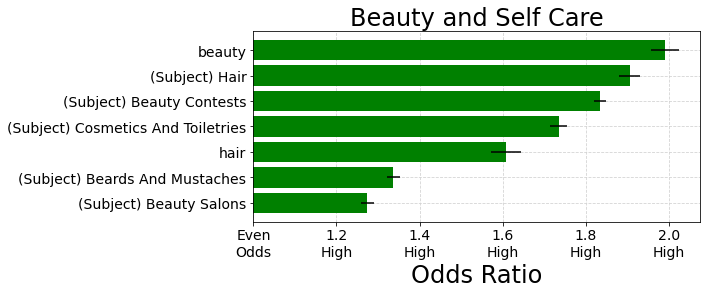

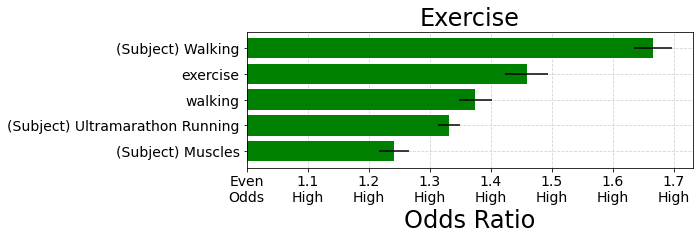

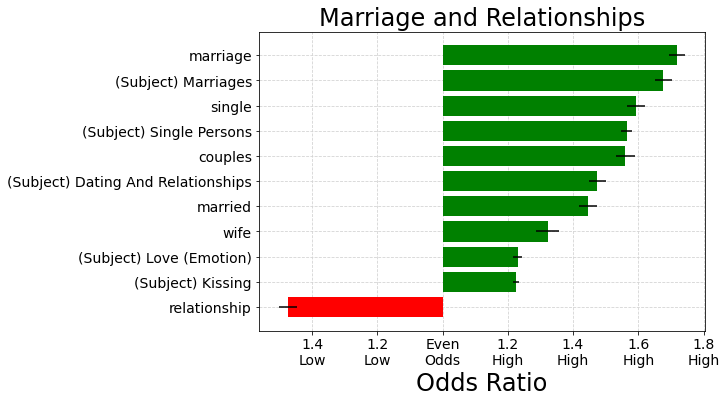

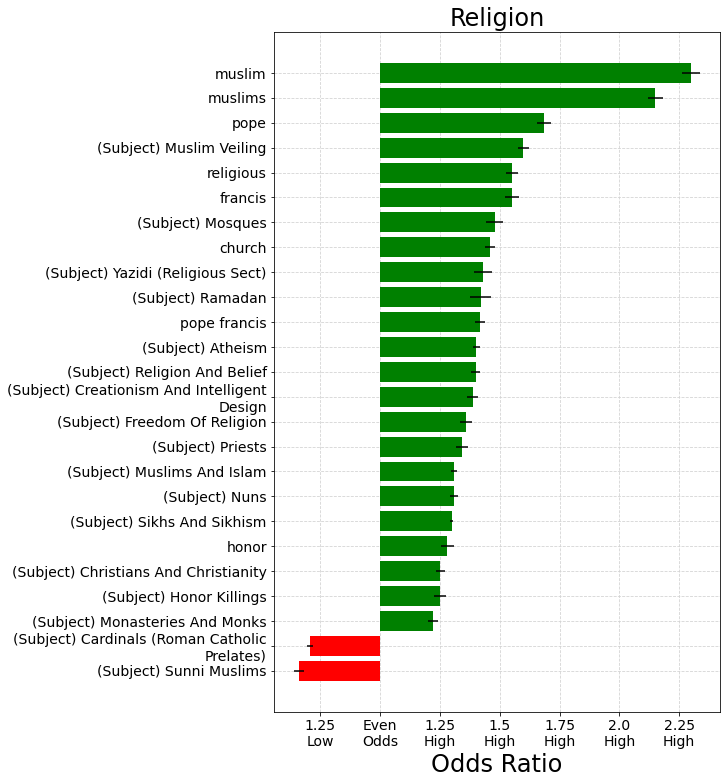

In [287]:
for cat in ['Opinion and Ethics', 'Parenting and Children', 'Food, Cooking, and Recipes', 
            'Diet and Nutrition', 'Death and Obituaries', 'Mental Health', 
            'Beauty and Self Care', 'Exercise', 'Marriage and Relationships',
            'Religion']:

    plot_topfeatures_w_se(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'std_error', pos_neg=True)

## Less Popular Topics to Scale Back on:

- Business and Commerce
- Economics
- Surveillance, Privacy, and Security
- Fashion and Clothing
- General Sports (although some global sports events do pretty well)
- Holidays
- Miltary and Warfare
- Modern Tech

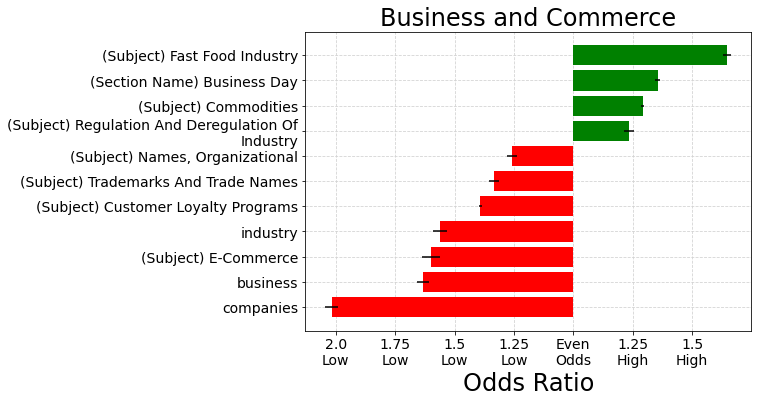

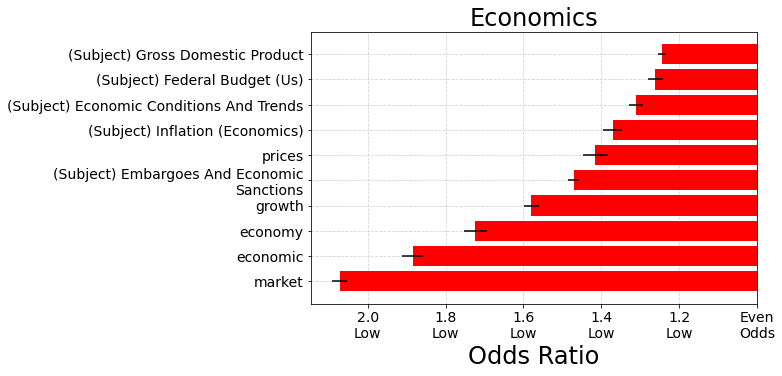

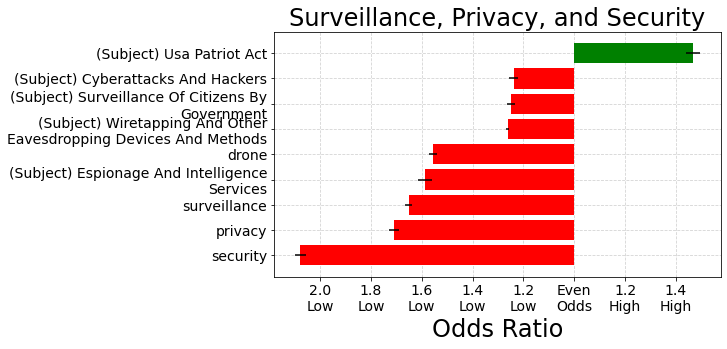

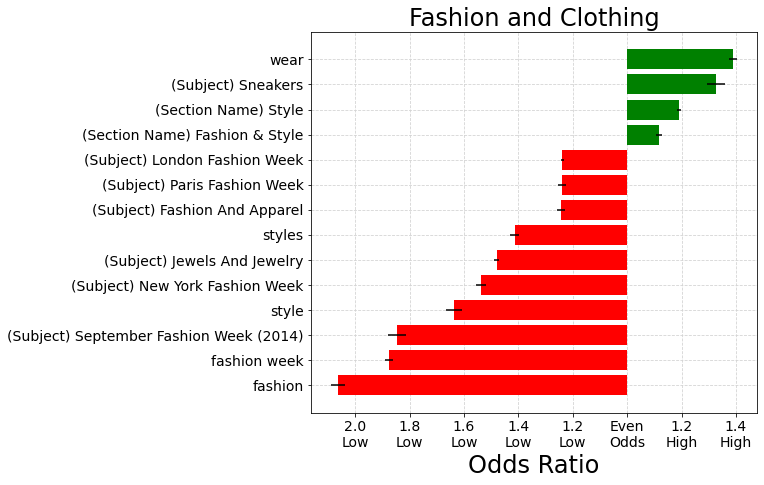

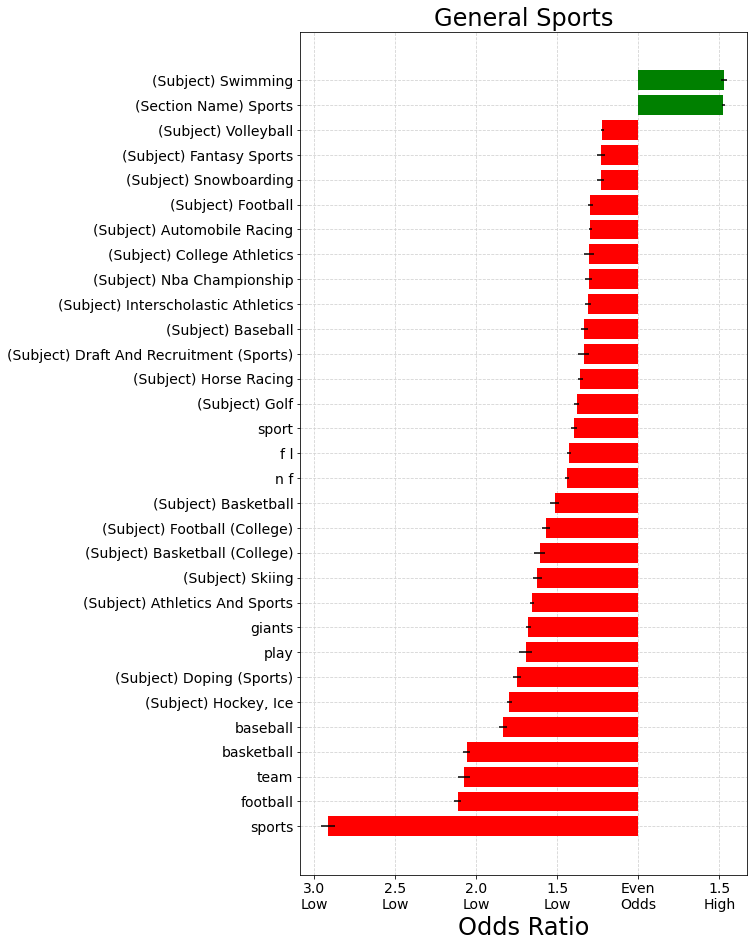

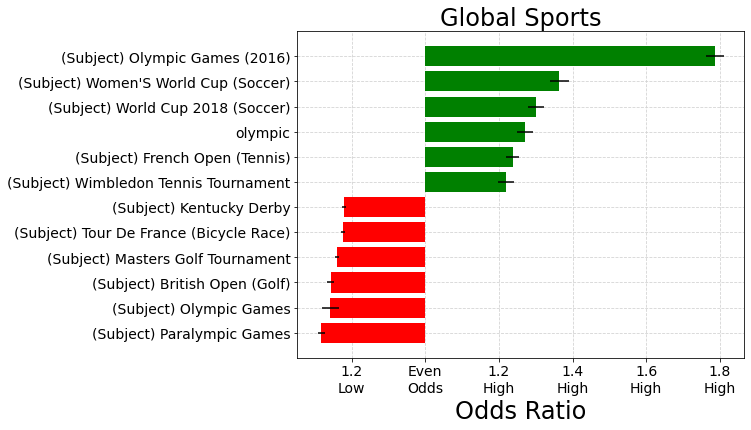

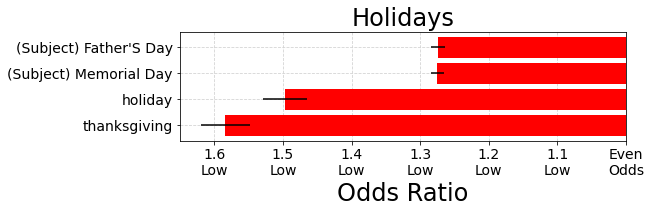

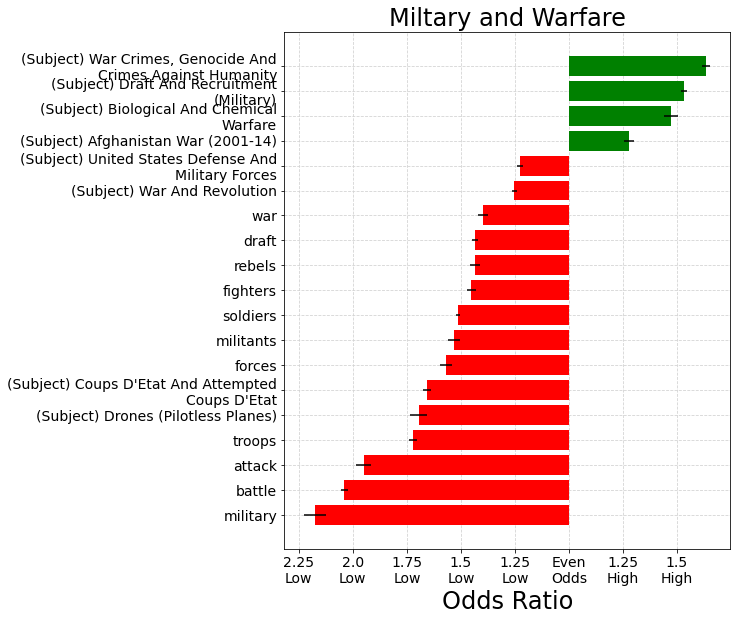

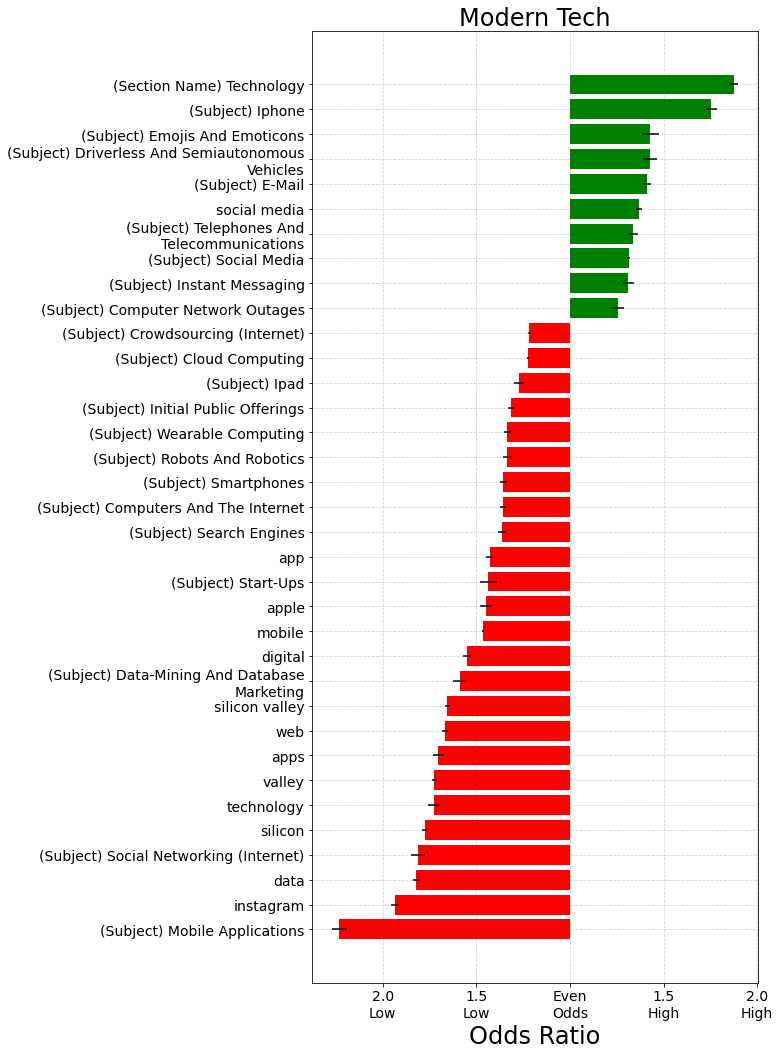

In [288]:
for cat in ['Business and Commerce', 'Economics','Surveillance, Privacy, and Security', 
            'Fashion and Clothing', 'General Sports', 'Global Sports', 
            'Holidays', 'Miltary and Warfare', 'Modern Tech']:

    plot_topfeatures_w_se(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'std_error', pos_neg=True)

## Add Posts on the Weekends and in Evenings when Appropriate

- Posts have slightly higher odds of high engagement when added in the evening (from 7 - 11 PM Eastern) versus at other times of day.
- They also have slightly higher odds of high engagement if posted on the weekend versus on weekdays.
- This is likely because the News Feed algorithm prioritizes more recently added content, and people may tend to engage with Facebook more in evenings and on weekends.

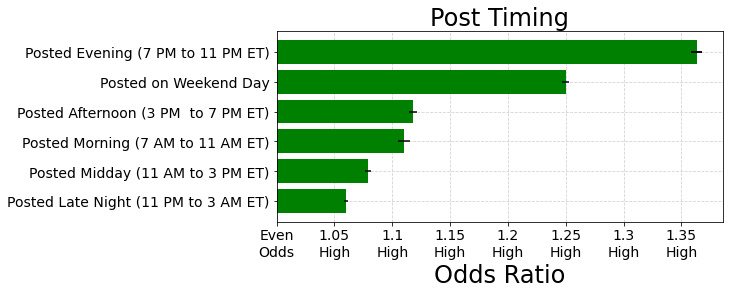

In [289]:
for cat in ['Post Timing']:

    plot_topfeatures_w_se(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'std_error', pos_neg=True)

## Caveats

The model results are more useful to understand themes as opposed to making accurate predictions. Key terms and names will change, so a model trained to pick up on high engagement using the names of the 2016 presidential election candidates, for instance, would perform worse on the 2020 presidential election.

This analysis defines `high engagement` by taking the percentile for engagement in comments count, shares count and likes/loves count, and then getting the mean of those engagement percentiles. Anything over a mean percentile of 75 was considered high. 
-  Engagement went up over time, and this is not accounted for; all posts were considered as a single corpus and not normalized for level of engagement per year, for example.
- The 75th percentile was somewhat arbitrary, and a different choice may yield different results. The distributions did not have a clear change to indicate the most appropriate cutoff point.
- If the New York Times would benefit more from certain types of engagement (for example shares, which might spread content farther beyond direct followers) these models do not capture that. Modeling individual engagement metrics may provide different results.

The results were pulled from two slightly different populations, since I was not able to match up all of the Facebook posts to NYT articles to get the metadata such as subject keywords and section name. The posts that I could not match  tended to be more highly engaging than low.

Just because a certain type of content drives higher engagement doesn't necessarily mean The New York Times will want to post more of that. Divisive and controversial topics tend to receive more engagement, but focusing primarily on those topics would not necessarily be the right move from a journalistic perspective and may not be aligned with the Times' mission and values. 

## Future Steps

- Perform sentiment analysis on articles with different levels of engagement, to see if that plays a role.
- Compare Facebook engagement to NYT comment counts to see if there is a difference.
- Create an interactive dashboard to show engagement levels and top posts related to custom keywords and subjects.